In [1]:
#####################################################
# Goal of this code is to check KW in nudging experiments
# 2024.6.13
# Mu-Ting Chien
##############################################

In [2]:
import os
import sys
sys.path.append('/glade/work/muting/function/')
import KW_diagnostics as KW
import mjo_mean_state_diagnostics as MJO
import create_my_colormap as mycolor
RWB = mycolor.red_white_blue()
from sklearn import linear_model # for caclulating KW composite lag-lon precip

from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap # for plotting KW composite vertical structure

/glade/u/ssg/ch/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [13]:
dir_out            = '/glade/work/muting/KW/'
CASENAME_LIST2     = list(['SST_AQP3_Qobs_27_-4K',\
                          'SST_AQP3_Qobs_27',\
                          'SST_AQP3_Qobs_27_4K'])
CASENAME_SHORT_LIST = list(['-4K','CTL','4K'])
NUDGE_LIST = list(['3h_20y_CLUBB_new','nudge_qlf_30m','nudge_qbl_30m','nudge_uvbl_30m','nudge_Tlf_30m',\
                  'nudge_Tmf_30m','nudge_Tlmf_30m','nudge_Tuf_30m','nudge_Tbl_30m','nudge_Tlf_30m_half',\
                   'nudge_Tlf_3h','nudge_Tlf_6h','nudge_Tlf_12h','nudge_Tlf_1d','nudge_Tlf_2d',\
                  'nudge_Tlf_4d','nudge_qlf_12h','nudge_qbl_12h','nudge_uvbl_12h','nudge_qlf_1d',\
                   'nudge_qbl_1d','nudge_uvbl_1d','nudge_qlf_2d','nudge_qlf_4d','3h_20y_CLUBB_new_uv_tendency',\
                  '3h_20y_CLUBB_new'])
title = list(['(a) No nudging','(b) q 850-700 hPa','(c) q 1000-850 hPa','(d) uv 1000-850 hPa','(e) T 850-700 hPa',\
             'Nudge Tmf','Nudge Tlmf','Nudge Tuf','Nudge Tbl','Nudge Tlf *0.5',\
              'Nudge Tlf 3h','Nudge Tlf 6h','Nudge Tlf 12h','Nudge Tlf 1d','Nudge Tlf 2d',\
             'Nudge Tlf 4d','Nudge qlf 12h','Nudge qbl 12h','Nudge uvbl 12h','Nudge qlf 1d',\
              'Nudge qbl 1d','Nudge uvbl 1d','Nudge qlf 2d','Nudge qlf 4d','CTL',\
             '+4K'])
# note that if not specified, the above title represents 30 minute nudging timescale

inudge = 15 #12 is Tlf_12h, 15 is Tlf_4d, 16 is qlf_12h #23 is the current last one (16, 19, 22, 23: qlf)
n_nudge = np.size(NUDGE_LIST)

icase          = 0 # 0-2 (-4k, CTL, +4K)
CASENAME       = CASENAME_LIST2[icase]+'_'+NUDGE_LIST[inudge]
print(CASENAME)

if inudge == 0 or inudge ==24 or inudge == 25:
    CASENAME_SHORT = CASENAME_SHORT_LIST[icase]+'_CLUBB_new'
else:
    CASENAME_SHORT = CASENAME_SHORT_LIST[icase]+'_'+NUDGE_LIST[inudge]
print(CASENAME_SHORT)

iyr_min = 2
iyr_max = 4 #3,4 #2:(YEAR 3 ONLY), 3:(YEAR 3-4), 4:(YEAR 3-5)
nyr = iyr_max-iyr_min+1
yr = np.arange(0,nyr)+1

figdir     = dir_out+'figure/Post_general/Nudging/'+CASENAME_SHORT+'/'
figdir_all = dir_out+'figure/Post_general/Nudging/All_30m_nudge_timescale/'
output_dir = dir_out+'output_data/'+CASENAME+'/'
output_dir_all = dir_out+'output_data/Nudge_30m_timescale/' #(no nudging, nudge uvbl, nudge Tlf
os.makedirs(figdir, exist_ok=True)
os.makedirs(figdir_all, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_dir_all, exist_ok=True)
s2d = 86400
nlag = 10*8 #10 day when calculating kw composite precip at (lon, lag)


# Constant used for KW phase composite
pi  = np.pi
PI = '\u03C0'
bin_simple = np.arange(-pi,pi+1/4*pi,1/4*pi)
bin_simple2 = np.arange(-pi,pi+1/2*pi,1/2*pi)

# Parameters for coh^2 figure
s2d = 86400
g  = 9.8
re = 6371*1000 #earth radius (m)
Cp = 1004.64

SST_AQP3_Qobs_27_-4K_nudge_Tlf_4d
-4K_nudge_Tlf_4d


In [14]:
#################################
# KW band for each simulation
if icase == 0: #-4K
    freq_min = 1/8
    freq_max = 1/2.5
    wnum_min = 1
    wnum_max = 15
    h_min    = 8
    h_max    = 50

#####################
# Dispersion curve and CCKW band
d = np.array([4,8])#([3,6]) # mark 3, 6, 20 day in WK1999
dname = list(['4d','8d'])#(['3d','6d'])
he = np.array([8,25,50]) 
hname = list(['8m','25m','50m'])
he_all = np.array([8, 12, 25, 50, 150])

# dispersion curve
xloc = np.array([12,12,4.9])
yloc = np.array([0.29,0.47,0.47])
cp = (g*he_all)**0.5
zwnum_goal = 0.5/s2d/cp*2*np.pi*re
# CCKW band
s_min = (g*he[0])**0.5/(2*np.pi*re)*s2d #slope of he = 8m
s_max = (g*he[2])**0.5/(2*np.pi*re)*s2d #slope of he = 90m
kw_tmax_list = np.array([8,7,4])
kw_tmax = kw_tmax_list[icase]
fmax = np.array([0.4,1/2.25,0.5])
kw_x = np.array([1/kw_tmax/s_max, 1/kw_tmax/s_min,     15,  15, fmax[icase]/s_max, 1/kw_tmax/s_max])
kw_y = np.array([1/kw_tmax,             1/kw_tmax,  15*s_min, fmax[icase],      fmax[icase],  1/kw_tmax])

In [15]:
###########################################
# 0-2. Calculate zonal mean T, uvw
#################################
mean_uvwT_saved = 0
latmax  = 90
if mean_uvwT_saved == 0:

    # (0) Get nfile_skip
    nfile_skip = KW.find_nfile_skip(CASENAME, CASENAME_SHORT, iyr_min, iyr_max, from_cheyenne=0)

    # (1) Load u
    vname = list(['U'])
    um, plev, lat = KW.load_3D_data_as_mean_state(CASENAME, CASENAME_SHORT, vname, iyr_min, iyr_max, latmax, nfile_skip, from_cheyenne=0)
    print('finish loading u')

    # Load T
    vname = list(['T'])
    Tm, plev, lat = KW.load_3D_data_as_mean_state(CASENAME, CASENAME_SHORT, vname, iyr_min, iyr_max, latmax, nfile_skip, from_cheyenne=0)
    print('finish loading T')

    # Load omega
    vname = list(['OMEGA'])
    wm, plev, lat = KW.load_3D_data_as_mean_state(CASENAME, CASENAME_SHORT, vname, iyr_min, iyr_max, latmax, nfile_skip, from_cheyenne=0)
    print('finish loading W')

    # Load v
    vname = list(['V'])
    vm, plev, lat = KW.load_3D_data_as_mean_state(CASENAME, CASENAME_SHORT, vname, iyr_min, iyr_max, latmax, nfile_skip, from_cheyenne=0)
    print('finish loading V')

    # Load q
    vname = list(['Q'])
    qm, plev, lat = KW.load_3D_data_as_mean_state(CASENAME, CASENAME_SHORT, vname, iyr_min, iyr_max, latmax, nfile_skip, from_cheyenne=0)
    print('finish loading Q')

    np.savez(output_dir+'mean_state_Tuvwq_all.npz', plev=plev, lat=lat, um=um, Tm=Tm, vm=vm, qm=qm, wm=wm)
    print('finish loading all variables')

finish loading u
finish loading T
finish loading W
finish loading V
finish loading Q
finish loading all variables


In [36]:
####################################
# 0. Calculate zonal mean precip (Supplementary)
##########################################
precip_saved_zm = 1
if precip_saved_zm == 0:

    # (0) Get nfile_skip
    #nfile_skip = 11*8 # if just 1 month
    #nfile_skip = 8*8+1 # if just 4 month
    nfile_skip = KW.find_nfile_skip(CASENAME, CASENAME_SHORT, iyr_min, iyr_max, from_cheyenne=0)
    #nfile_skip = 9 #(year 1) 13(year 1-3)
    print(nfile_skip)

    # (1) Load precip
    precip, time, lat, lon = KW.load_2D_data_as_1variable(CASENAME, 'PRECL','PRECC', iyr_min, iyr_max, 90, \
                                                          1000*s2d, nfile_skip, 0, from_cheyenne=0)
    print('finish loading')

    # (1.5) Calculate time mean zonal mean
    pr_zm = np.mean(np.mean(precip,2),0)
    del precip
    
    # Save precip
    np.savez(output_dir+'precip_zm.npz', pr_zm = pr_zm, lat=lat)
else:
    data = np.load(output_dir+'precip_zm.npz')
    pr_zm = data['pr_zm']
    lat   = data['lat']

13
YEAR: 0003
YEAR: 0004
YEAR: 0005
finish loading


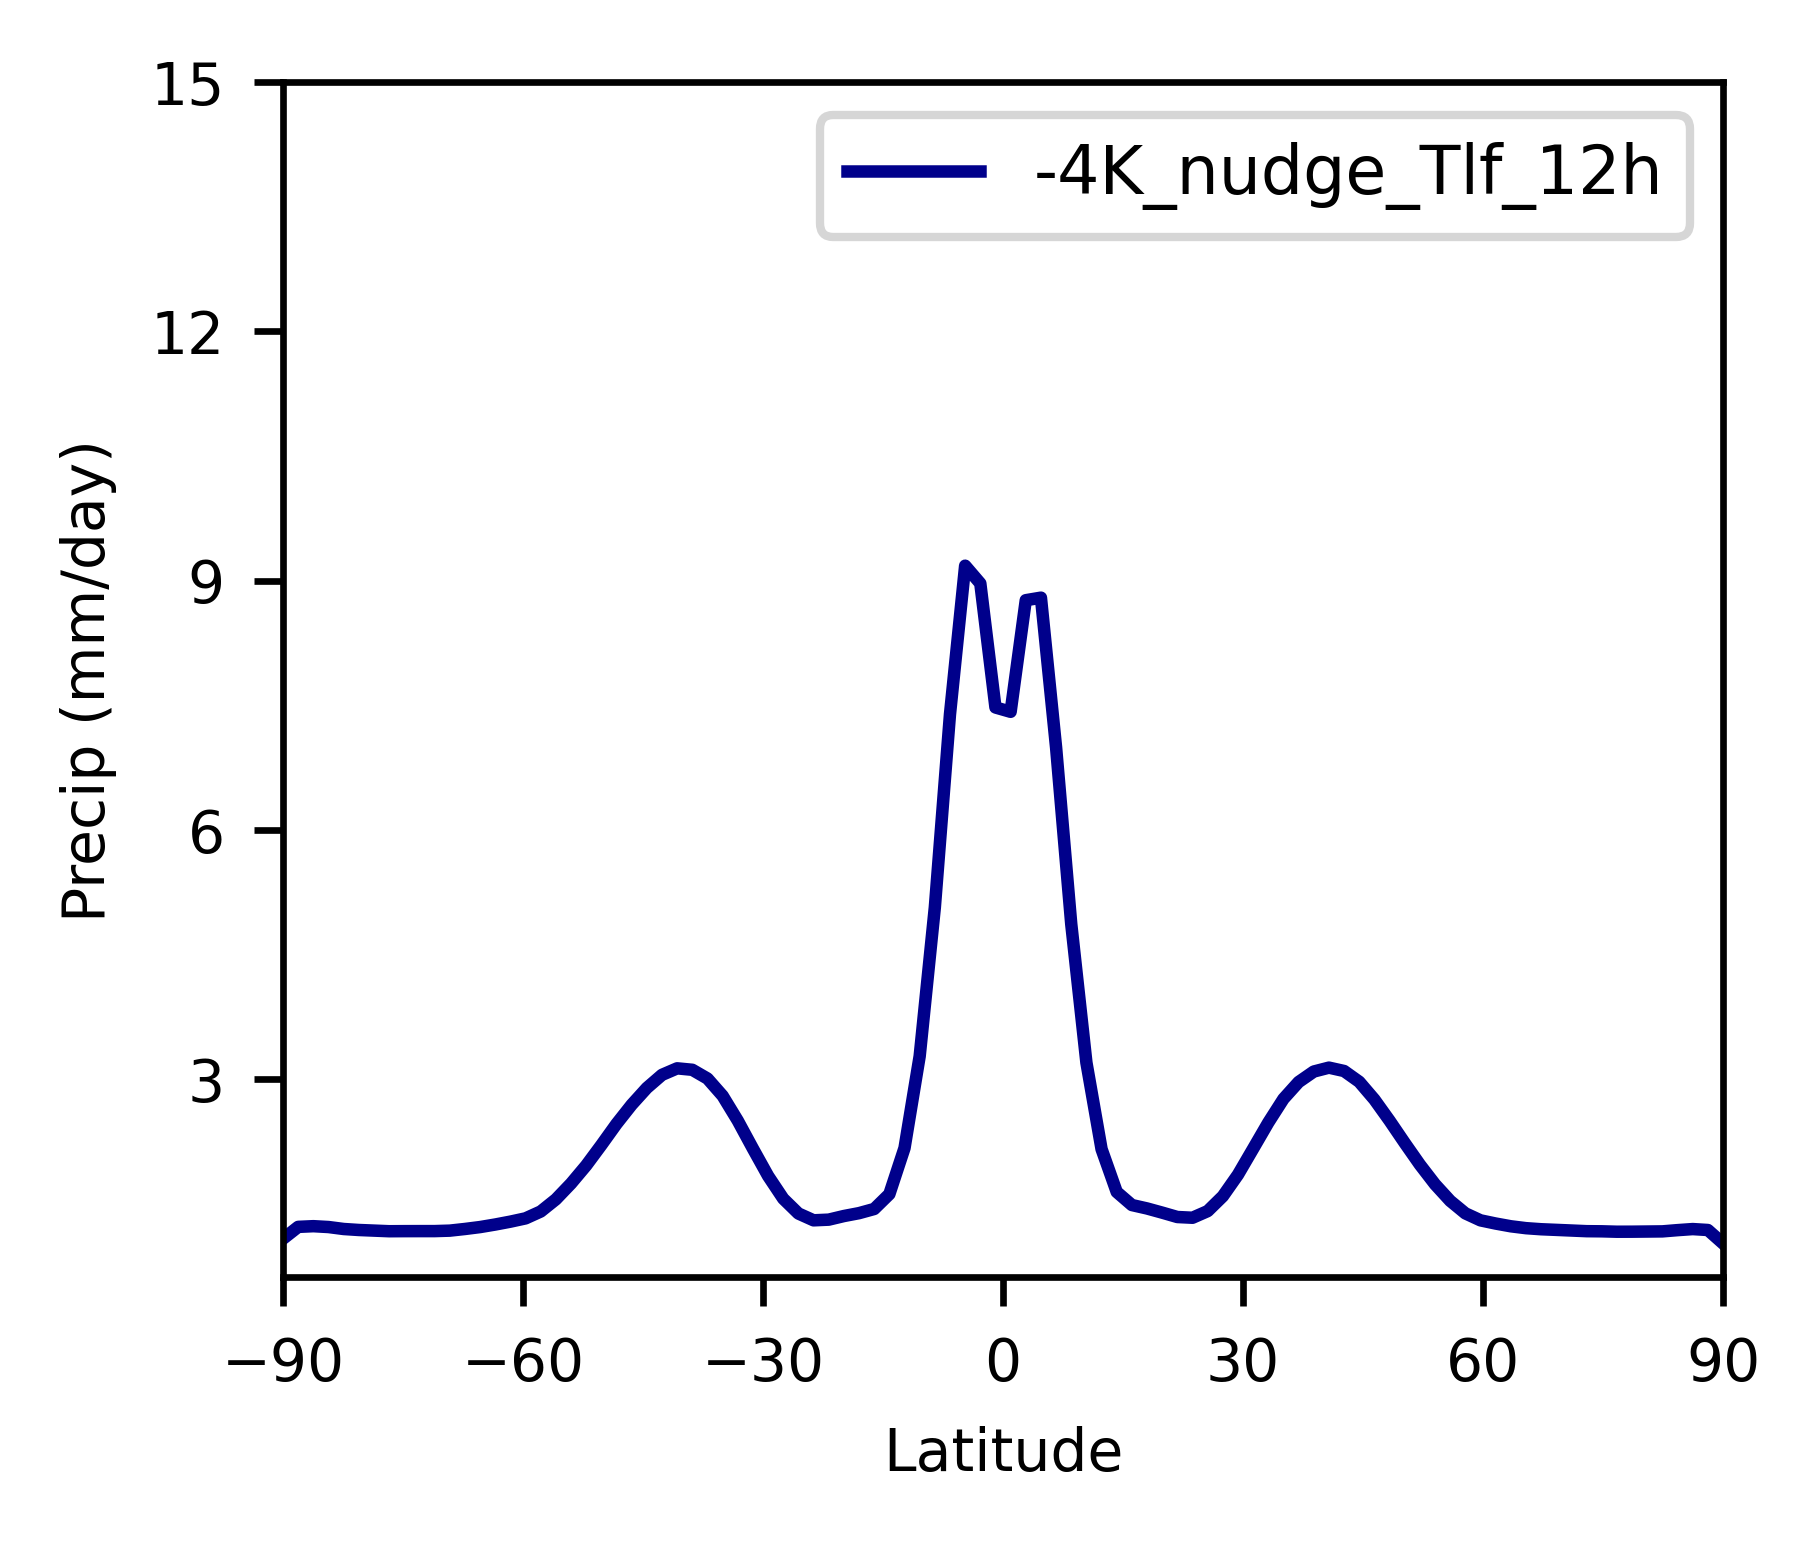

In [37]:
###############################
# Plot zonal mean precip (individual exp)
##############################
plot_zm_precip = 1
if plot_zm_precip == 1:
    fig_name = 'fig2_pr_zm.png'
    fig = plt.subplots(1,1,figsize=(3.2, 2.4),dpi=600)
    plt.subplots_adjust(left=0.15,right=0.9,top=0.95,bottom=0.12,hspace=0.4)
    plt.rcParams.update({'font.size': 8})
    #
    plt.subplot(1,1,1)
    plt.plot(lat, pr_zm,color='darkblue')
    plt.legend([CASENAME_SHORT])
    plt.xlim([-90,90])
    plt.xticks(np.arange(-90,120,30))
    plt.xlabel('Latitude')
    plt.ylabel('Precip (mm/day)')
    plt.yticks(np.arange(3,18,3))
    plt.savefig(figdir+fig_name,format='png', dpi=600)
    plt.show()
    plt.close()

In [14]:
#################################
# 1. Obtain KW amplitude
#################################
precip_saved = 1
latmax = 10
if precip_saved == 0:
    
    # (0) Get nfile_skip
    #nfile_skip = KW.find_nfile_skip(CASENAME, CASENAME_SHORT, iyr_min, iyr_max, from_cheyenne=0)
    #nfile_skip = 11*8 # if just 1 month
    #nfile_skip = 8*8+1 # if just 4 month
    nfile_skip = 9 #1 year
    print(nfile_skip)
    
    # (1) Load precip
    precip, time, lat, lon = KW.load_2D_data_as_1variable(CASENAME, 'PRECL','PRECC', iyr_min, iyr_max, latmax, \
                                                          1000*s2d, nfile_skip, 0, from_cheyenne=0)
    print('finish loading')

    # (1.5) Calculate non-projected precip anomaly, used for signal strength
    nt    = np.size(precip,0)
    pr_m2 = np.mean(precip,0)
    pr_m2 = np.tile(pr_m2,(nt,1,1))
    pr_ano = precip - pr_m2
    del pr_m2
    
    # Save precip
    np.savez(output_dir+'precip.npz', precip=precip, pr_ano=pr_ano, time=time, lat=lat, lon=lon)

else:
    data = np.load(output_dir+'precip.npz')
    precip = data['precip']
    pr_ano = data['pr_ano']
    time   = data['time']
    lon    = data['lon']
    lat    = data['lat']
    print(np.size(time))

9
YEAR: 0003
finish loading


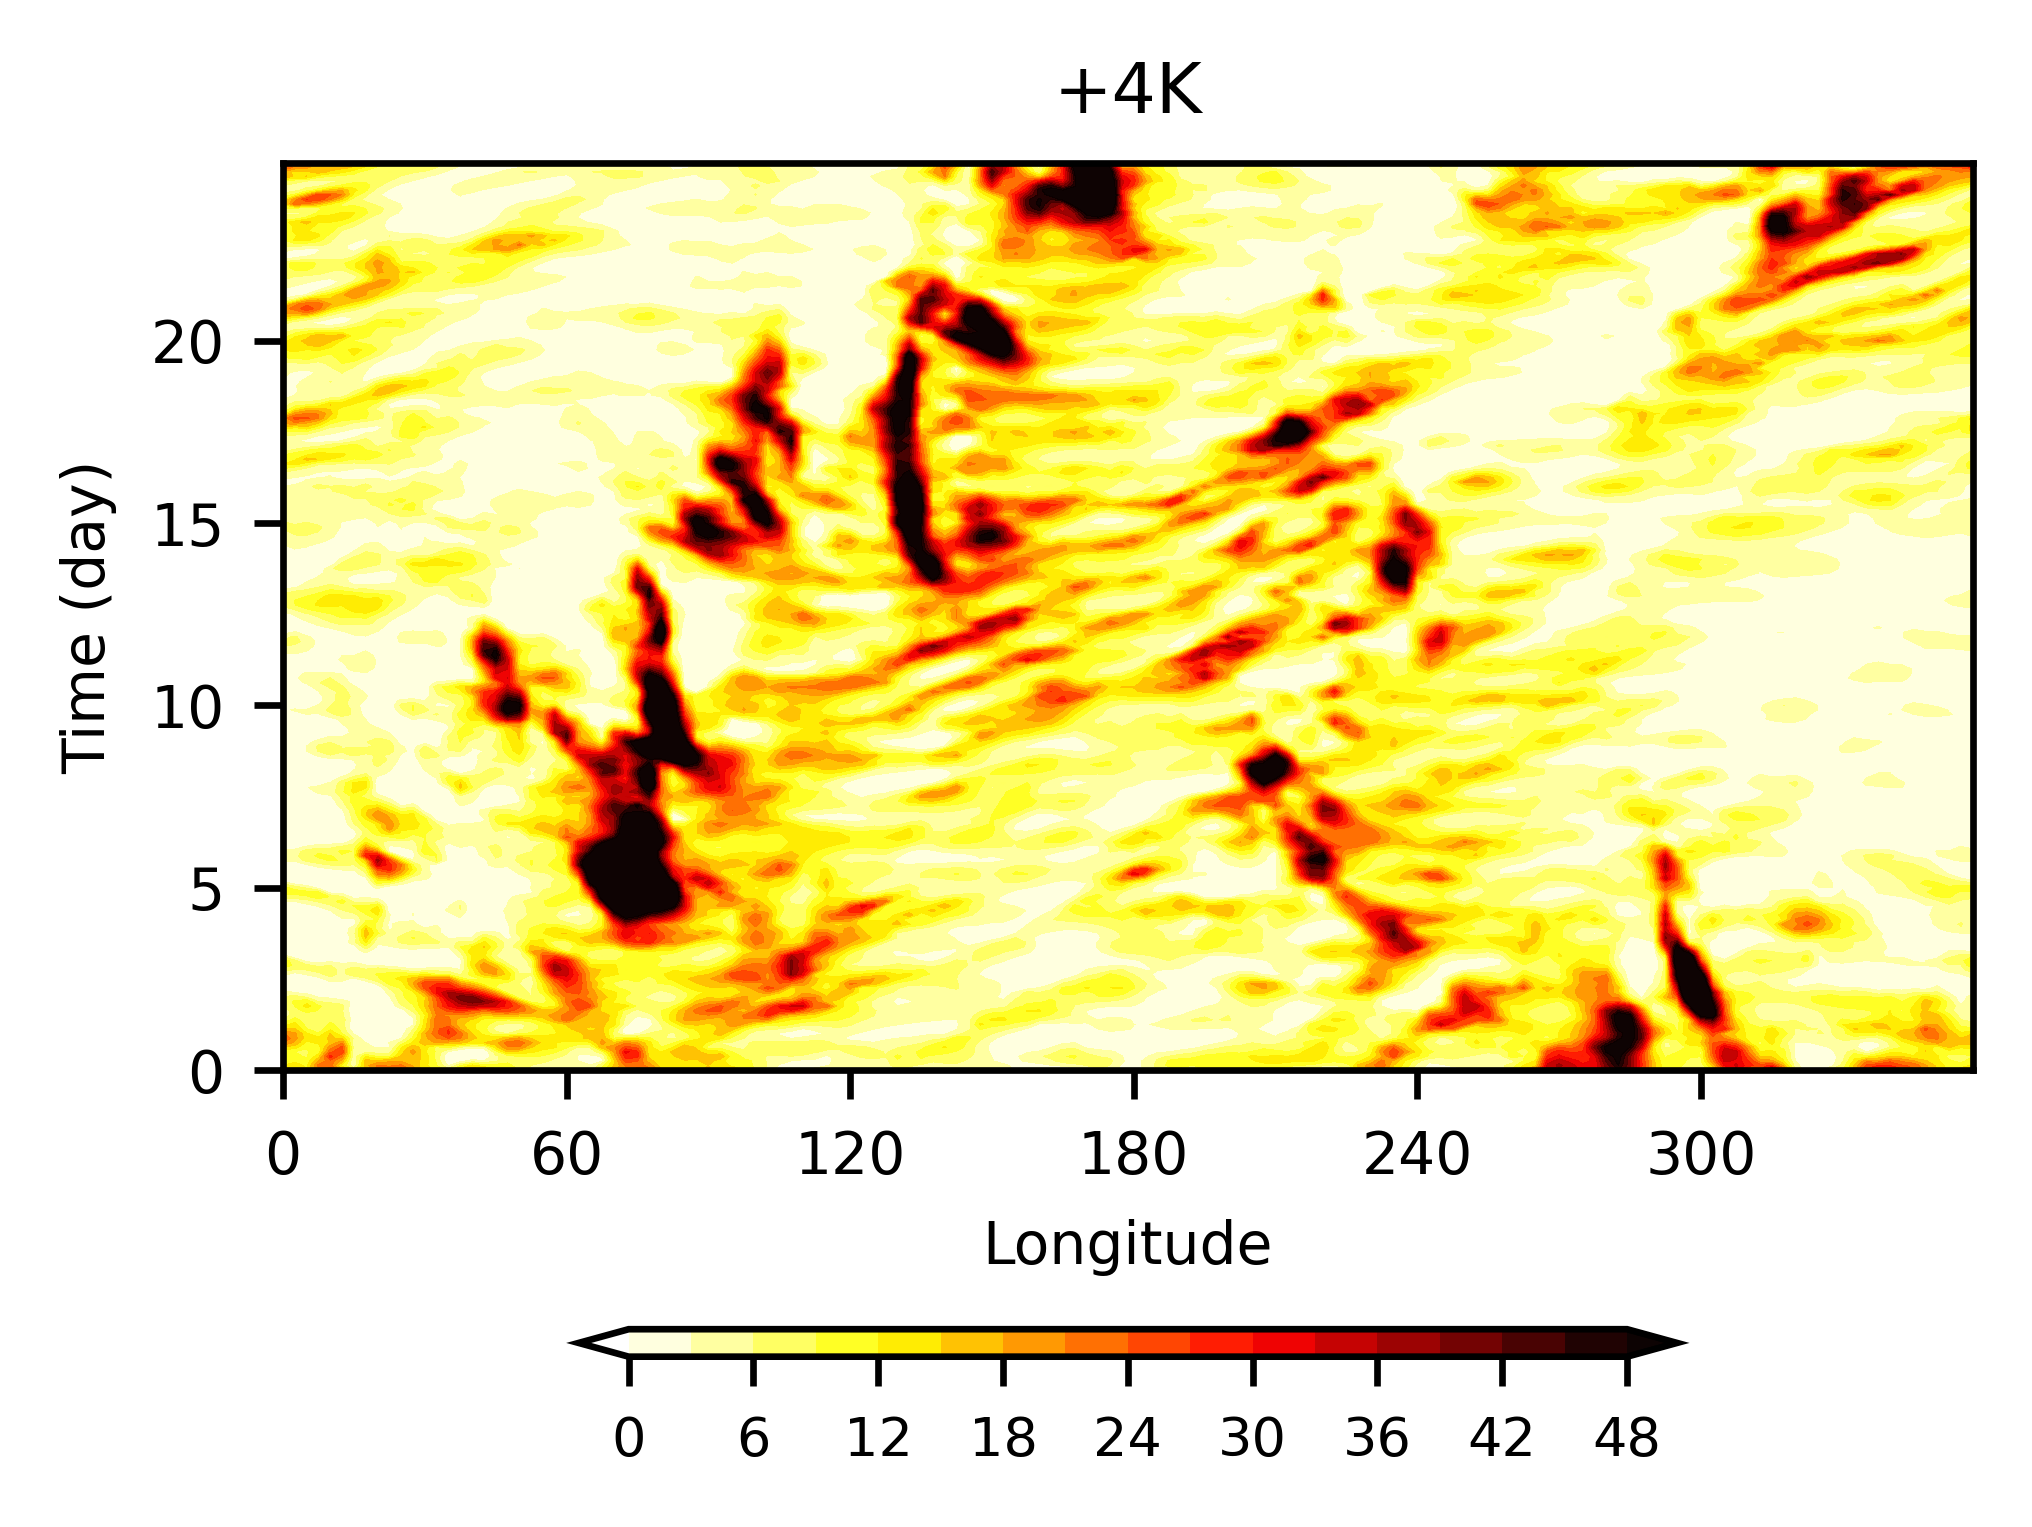

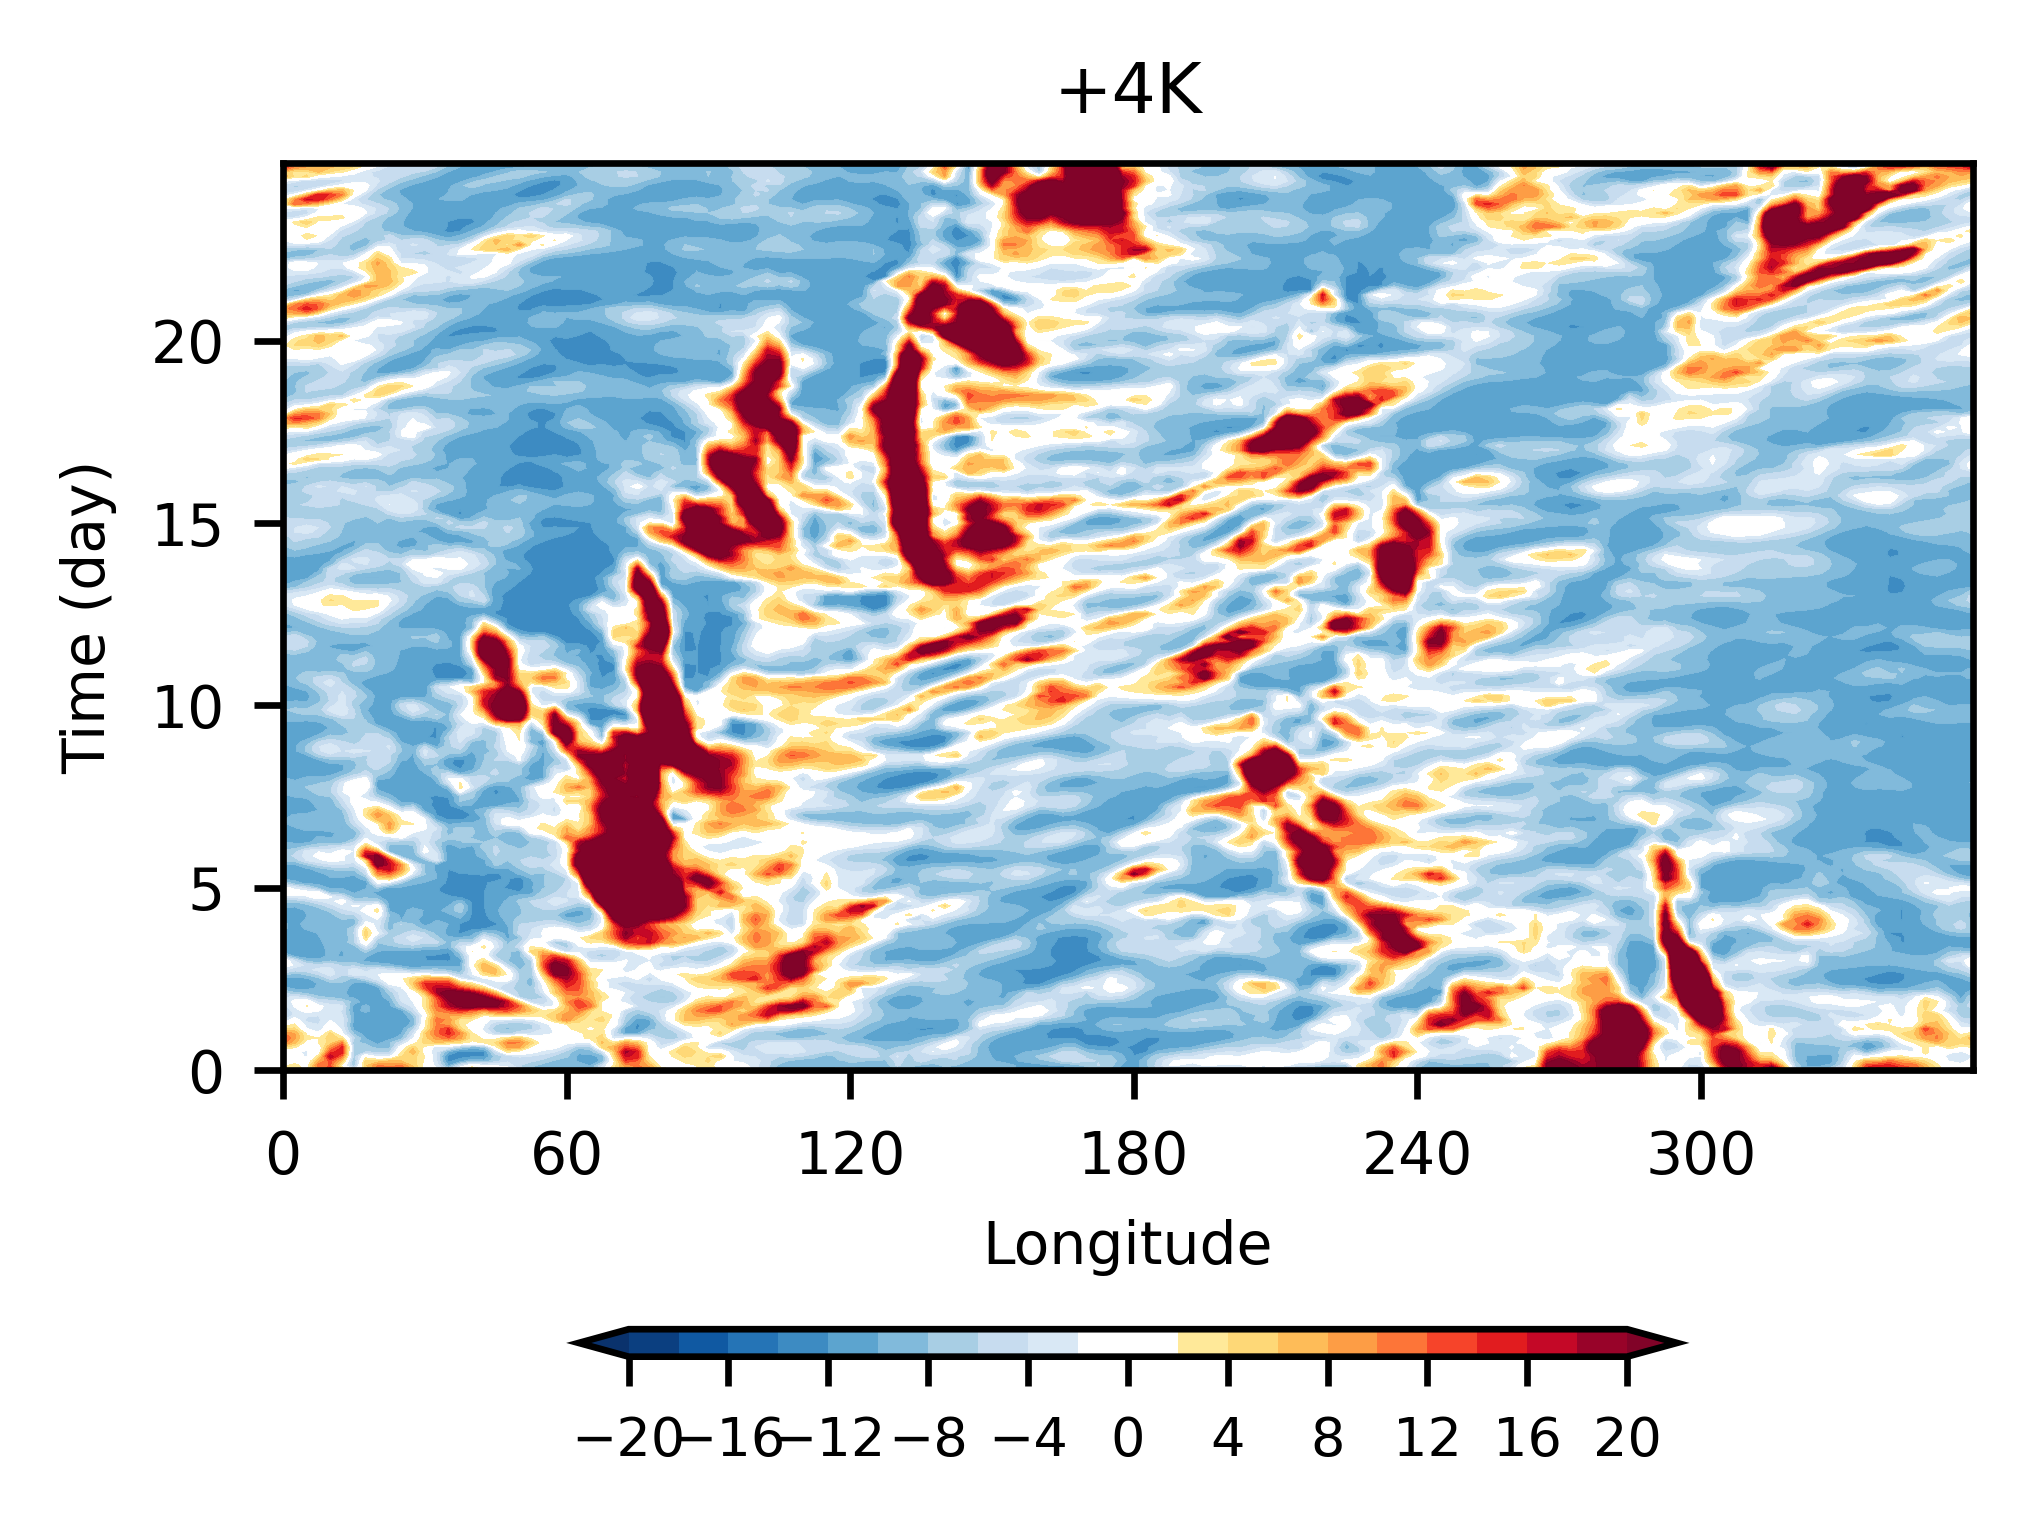

In [25]:
#######################
# Plot hovmoller diagram
###################
# Plot precip hovmoller at the equator
font = 7
for plot_raw_ano in range(0,2):
    for inug in range(inudge,inudge+1):
        CASENAME   = CASENAME_LIST2[icase]+'_'+NUDGE_LIST[inug]
        output_dir = dir_out+'output_data/'+CASENAME+'/'
        data = np.load(output_dir+'precip.npz')

        # Make sure all exp start from the same day
        tmin = 0
        
        precip = data['precip'][tmin:,:,:]
        pr_ano = data['pr_ano'][tmin:,:,:]
        time   = data['time'][:-tmin]
        lon    = data['lon']
        lat    = data['lat']
        nlat   = np.size(lat)
        
        pr_equator = np.mean(precip[:,int(nlat/2-1):int(nlat/2+1),:],1)
        pr_ano_equator = np.mean(pr_ano[:,int(nlat/2-1):int(nlat/2+1),:],1)
        day_max = 25 #50 # how many days to plot
        t = np.arange(0,8*day_max)
        time_day = t*3/24
        clev = np.arange(0,51,3)
        cticks = np.arange(0,54,6)
        clev_ano = np.arange(-20,22,2)
        cticks_ano = np.arange(-20,24,4)
        lont, tlon = np.meshgrid(lon, time_day[t])
    
        fig,axes = plt.subplots(1,1,figsize=(3.2, 2.4),dpi=600)
        plt.rcParams.update({'font.size': 7})
        plt.subplots_adjust(left=0.1,right=0.98,top=0.95,bottom=0.05,wspace = 0.23, hspace = 0.35)
        if plot_raw_ano == 0:
            figname = 'fig4_lon_t_hovmoller_pr_qbl.png'
            ax = plt.subplot(1,1,1)
            cf = plt.contourf(lont, tlon, pr_equator[t,:], levels = clev, cmap='hot_r', zorder=2, alpha=0.99,extend = 'both' )
        else:
            figname = 'fig4_lon_t_hovmoller_pr_ano_qbl.png'
            ax = plt.subplot(1,1,1)
            cf = plt.contourf(lont, tlon, pr_ano_equator[t,:], levels = clev_ano, cmap=get_cmap(RWB), zorder=2, alpha=0.99,extend = 'both' )        
        plt.title(title[inug])
        plt.xlabel('Longitude',fontsize=font)
        plt.ylabel('Time (day)',fontsize=font)
        cb = fig.colorbar(cf,ax=axes,orientation='horizontal',shrink=.65,fraction=0.1, pad=0.2,aspect=40*1)
        cb.ax.tick_params(labelsize=6.5)
        plt.yticks(np.arange(0,25,5),fontsize=font)
        plt.xticks(np.arange(0,360,60),fontsize=font)
        if plot_raw_ano == 0:
            cb.set_ticks(cticks)
        else:
            cb.set_ticks(cticks_ano)    
        plt.savefig(figdir+figname,format='png', dpi=600)
        plt.show()
        plt.close()

In [26]:
precip_kw_saved = 1

if precip_kw_saved == 0:

    # (2) KW meridional projection / remove 10-day low-pass variability
    pr_kwproj = KW.KW_meridional_projection(precip, lat, tropics_or_midlat=0)
    pr_kwproj_ano = MJO.remove_10d_from_3hr_data(pr_kwproj)

    print('finish KW proj')

    # (4) KW-filtered precip
    KW_filtered_pr, time_pr = KW.KW_wavenumber_frequency_filter(pr_kwproj_ano, wnum_min, wnum_max,\
                    freq_min, freq_max, h_min, h_max)
    print('finish KW filtering')

    # Make sure time dimension is the same as phase_kw
    pr_kwproj_ano_short = pr_kwproj_ano[time_pr[0]:time_pr[-1]+1,:]

    # Calculate KW composite
    pr_kw, phase_bin, phase_correct = KW.calculate_KW_phase(KW_filtered_pr, 'pr', 'mm/day', figdir)
    
    # Save kw precip
    np.savez(output_dir+'precip_kw.npz', pr_kwproj_ano_short=pr_kwproj_ano_short, KW_filtered_pr=KW_filtered_pr, \
         time_pr=time_pr, lon=lon, phase_bin=phase_bin, phase_correct=phase_correct, pr_kw = pr_kw)

else:
    data          = np.load(output_dir+'precip_kw.npz')
    pr_kw         = data['pr_kw']
    phase_bin     = data['phase_bin']
    time_pr       = data['time_pr']
    phase_correct = data['phase_correct']

kw_amp  = (np.max(pr_kw)-np.min(pr_kw))/2  
print('KW amp:',kw_amp)
phase = phase_bin
print(np.shape(time_pr))

KW amp: 2.155324171241986
(8306,)


he: [ 25  90 150]
Cp: [15.65247584 29.69848481 38.34057903]


/glade/u/home/muting/.local/lib/python3.7/site-packages/numpy/ma/core.py:2830: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


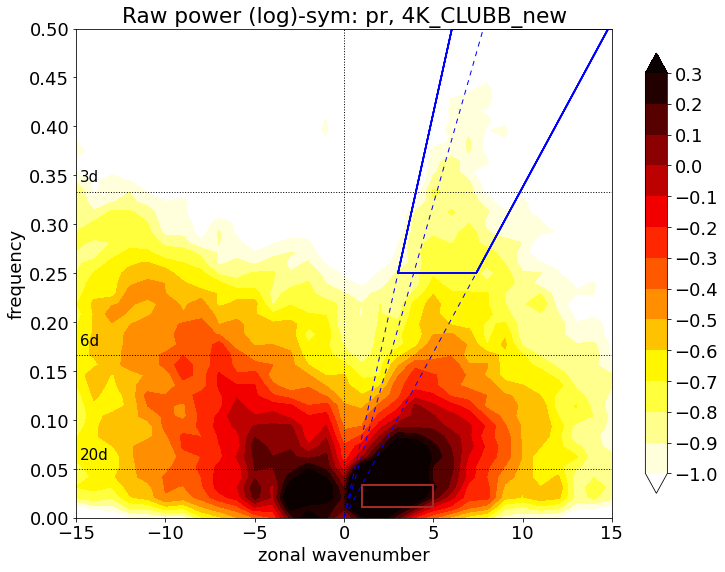

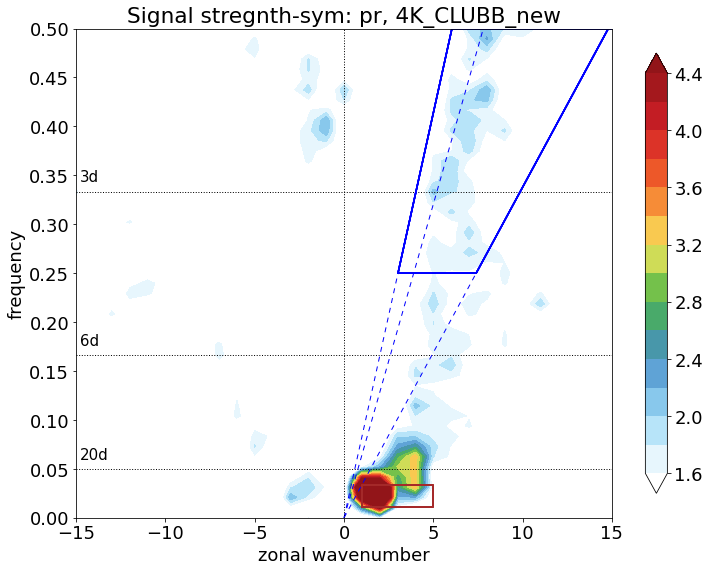

In [27]:
################################
# 2. Plot wavenumber-frequency spectrum
####################################
calc_plot_rsym = 1

if calc_plot_rsym == 1:
    # (1) Calculate and Plot precip specturm (for the sake of obataining KW amplitude, this step can be ignored.

    power_pr, r_sym, x, y, freq, zonalwnum, dof = KW.calculate_power_spectrum(pr_ano[:,:,:], 0)

    # PLotting, CHANGE ICASE & CASE_SHORT:
    clev = np.arange(-1,0.4,0.1)
    cticks = clev
    vname = 'pr'

    # clev for signal strength
    clev_r = np.arange(1.6,4.6,0.2)
    cticks_r = np.arange(1.6,4.8,0.4)
    
    KW.plot_raw_sym_spectrum(power_pr, x, y, clev, cticks, figdir, vname, icase, CASENAME_SHORT)
    KW.plot_signal_strength_sym(r_sym, x, y, clev_r, cticks_r, figdir, vname, icase, CASENAME_SHORT)
    
    # save data
    np.savez(output_dir+'pr_wavenum_freq.npz', power_pr=power_pr, r_sym=r_sym, x=x, y=y, freq=freq, zonalwnum=zonalwnum)

6


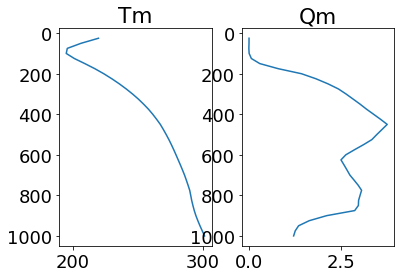

In [28]:
############################
# 3. Check vertical structure of KWs
#####################################
QTUVWZq_saved = 0
latmax = 10
if QTUVWZq_saved == 0:
    
    # (0) Get nfile_skip
    nfile_skip = KW.find_nfile_skip(CASENAME, CASENAME_SHORT, iyr_min, iyr_max, from_cheyenne=0)
    #nfile_skip = 11*8 # yr03, 1month
    #nfile_skip = 8*8+1
    print(nfile_skip)

    # (1) Load T and Q, U, gph, W & Calculate anomaly
    vname = list(['T'])
    Tproj, Tm, time, plev, lon = KW.load_3D_data_as_1variable(CASENAME, CASENAME_SHORT, vname, iyr_min, iyr_max, latmax, nfile_skip, from_cheyenne=0)
    Ta = MJO.remove_10d_from_3hr_data(Tproj) #(time, plev, lon)
    
    vname = list(['DTCOND'])
    Qproj, Qm, time, plev, lon = KW.load_3D_data_as_1variable(CASENAME, CASENAME_SHORT, vname, iyr_min, iyr_max, latmax, nfile_skip, from_cheyenne=0)
    Qa = MJO.remove_10d_from_3hr_data(Qproj) #(time, plev, lon)
    
    vname = list(['Z3'])
    Zproj, Zm, time, plev, lon = KW.load_3D_data_as_1variable(CASENAME, CASENAME_SHORT, vname, iyr_min, iyr_max, latmax, nfile_skip, from_cheyenne=0)
    Za = MJO.remove_10d_from_3hr_data(Zproj)
    
    vname = list(['OMEGA'])
    Wproj, Wm, time, plev, lon = KW.load_3D_data_as_1variable(CASENAME, CASENAME_SHORT, vname, iyr_min, iyr_max, latmax, nfile_skip, from_cheyenne=0)
    Wa = MJO.remove_10d_from_3hr_data(Wproj)

    vname = list(['U'])
    Uproj, Um, time, plev, lon = KW.load_3D_data_as_1variable(CASENAME, CASENAME_SHORT, vname, iyr_min, iyr_max, latmax, nfile_skip, from_cheyenne=0)
    Ua = MJO.remove_10d_from_3hr_data(Uproj)

    vname = list(['V'])
    Vproj, Vm, time, plev, lon = KW.load_3D_data_as_1variable(CASENAME, CASENAME_SHORT, vname, iyr_min, iyr_max, latmax, nfile_skip, from_cheyenne=0)
    Va = MJO.remove_10d_from_3hr_data(Vproj)

    vname = list(['Q'])
    qproj, qm, time, plev, lon = KW.load_3D_data_as_1variable(CASENAME, CASENAME_SHORT, vname, iyr_min, iyr_max, latmax, nfile_skip, from_cheyenne=0)
    qa = MJO.remove_10d_from_3hr_data(qproj)
    
    # Test: check mean state T makes sense
    plt.subplot(1,2,1)
    plt.title('Tm')
    plt.plot(Tm, plev)
    plt.gca().invert_yaxis()
    plt.subplot(1,2,2)
    plt.title('Qm')
    plt.plot(Qm*s2d, plev)
    plt.gca().invert_yaxis()
    plt.show()
    
    # Save data
    np.savez(output_dir+'QTUVZq.npz', Qproj=Qproj, Qm=Qm, Qa=Qa,\
             Tproj=Tproj, Tm=Tm, Ta=Ta,\
             Uproj=Uproj, Um=Um, Ua=Ua,\
             Vproj=Vproj, Vm=Vm, Va=Va,\
             Wproj=Wproj, Wm=Wm, Wa=Wa,\
             Zproj=Zproj, Zm=Zm, Za=Za,\
             qproj=qproj, qm=qm, qa=qa,\
             time=time, plev=plev, lon=lon)

else:
    data = np.load(output_dir+'QTUVZq.npz')
    Tproj = data['Tproj'] #(time, plev, lon), raw T data projected onto KW meridional structure
    Qproj = data['Qproj'] #(time, plev, lon), raw Q data projected onto KW meridional structure
    Tm    = data['Tm'] #(plev), mean state temperature profile
    Qm    = data['Qm'] #(plev), mean state Q profile
    Ta    = data['Ta'] #(time, plev, lon), projected T, without 10-day low pass filtered variability
    Qa    = data['Qa'] #(time, plev, lon), projected Q, without 10-day low pass filtered variability
    time  = data['time']
    plev  = data['plev']
    lon   = data['lon']
    print(np.shape(Tproj))

In [29]:
#####################################
# 2.3 Calculate KW composite vertical structure of Q and T
################################################
QTUZq_kw_saved = 0
if QTUZq_kw_saved == 0:
    for inug in range(inudge,inudge+1):#0,n_nudge):
        
        CASENAME   = CASENAME_LIST2[icase]+'_'+NUDGE_LIST[inug]
        output_dir = dir_out+'output_data/'+CASENAME+'/'

        # Load variables to be composited
        data = np.load(output_dir+'QTUVZq.npz')
        Ta   = data['Ta'] #(time, plev, lon), projected T, without 10-day low pass filtered variability
        Qa   = data['Qa']
        Ua   = data['Ua']
        Va   = data['Va']
        Za   = data['Za']
        qa   = data['qa']
        Wa   = data['Wa']
        plev = data['plev']

        # Load KW phase info
        data          = np.load(output_dir+'precip_kw.npz')
        time_pr       = data['time_pr']
        phase_correct = data['phase_correct']
        
        # Make sure Ta and Qa have the same size as kw-filtered precip
        Ta_trim = Ta[time_pr[0]:time_pr[-1]+1, :, :]
        Qa_trim = Qa[time_pr[0]:time_pr[-1]+1, :, :]
        Ua_trim = Ua[time_pr[0]:time_pr[-1]+1, :, :]
        Va_trim = Va[time_pr[0]:time_pr[-1]+1, :, :]
        Za_trim = Za[time_pr[0]:time_pr[-1]+1, :, :]
        qa_trim = qa[time_pr[0]:time_pr[-1]+1, :, :]
        Wa_trim = Wa[time_pr[0]:time_pr[-1]+1, :, :]
            
        T_KW, phase = KW.composite_by_kw_phase(Ta_trim[:,:,:], phase_correct[:,:], time_pr[:]) #(phase, plev)
        Q_KW, phase = KW.composite_by_kw_phase(Qa_trim[:,:,:], phase_correct[:,:], time_pr[:])
        U_KW, phase = KW.composite_by_kw_phase(Ua_trim[:,:,:], phase_correct[:,:], time_pr[:])
        V_KW, phase = KW.composite_by_kw_phase(Va_trim[:,:,:], phase_correct[:,:], time_pr[:])
        q_KW, phase = KW.composite_by_kw_phase(qa_trim[:,:,:], phase_correct[:,:], time_pr[:])
        Z_KW, phase = KW.composite_by_kw_phase(Za_trim[:,:,:], phase_correct[:,:], time_pr[:])
        W_KW, phase = KW.composite_by_kw_phase(Wa_trim[:,:,:], phase_correct[:,:], time_pr[:])
        np.savez(output_dir+'QTUVZq_kw.npz', Q_KW=Q_KW, T_KW=T_KW, U_KW=U_KW, V_KW=V_KW, q_KW=q_KW, Z_KW=Z_KW, W_KW=W_KW, plev=plev, phase=phase)
else:
    data = np.load(output_dir+'QTUVZq_kw.npz')
    Q_KW = data['Q_KW']
    T_KW = data['T_KW']
    U_KW = data['U_KW']
    Z_KW = data['Z_KW']
    W_KW = data['W_KW']
    plev = data['plev']
    phase = data['phase']

2.155324171241986


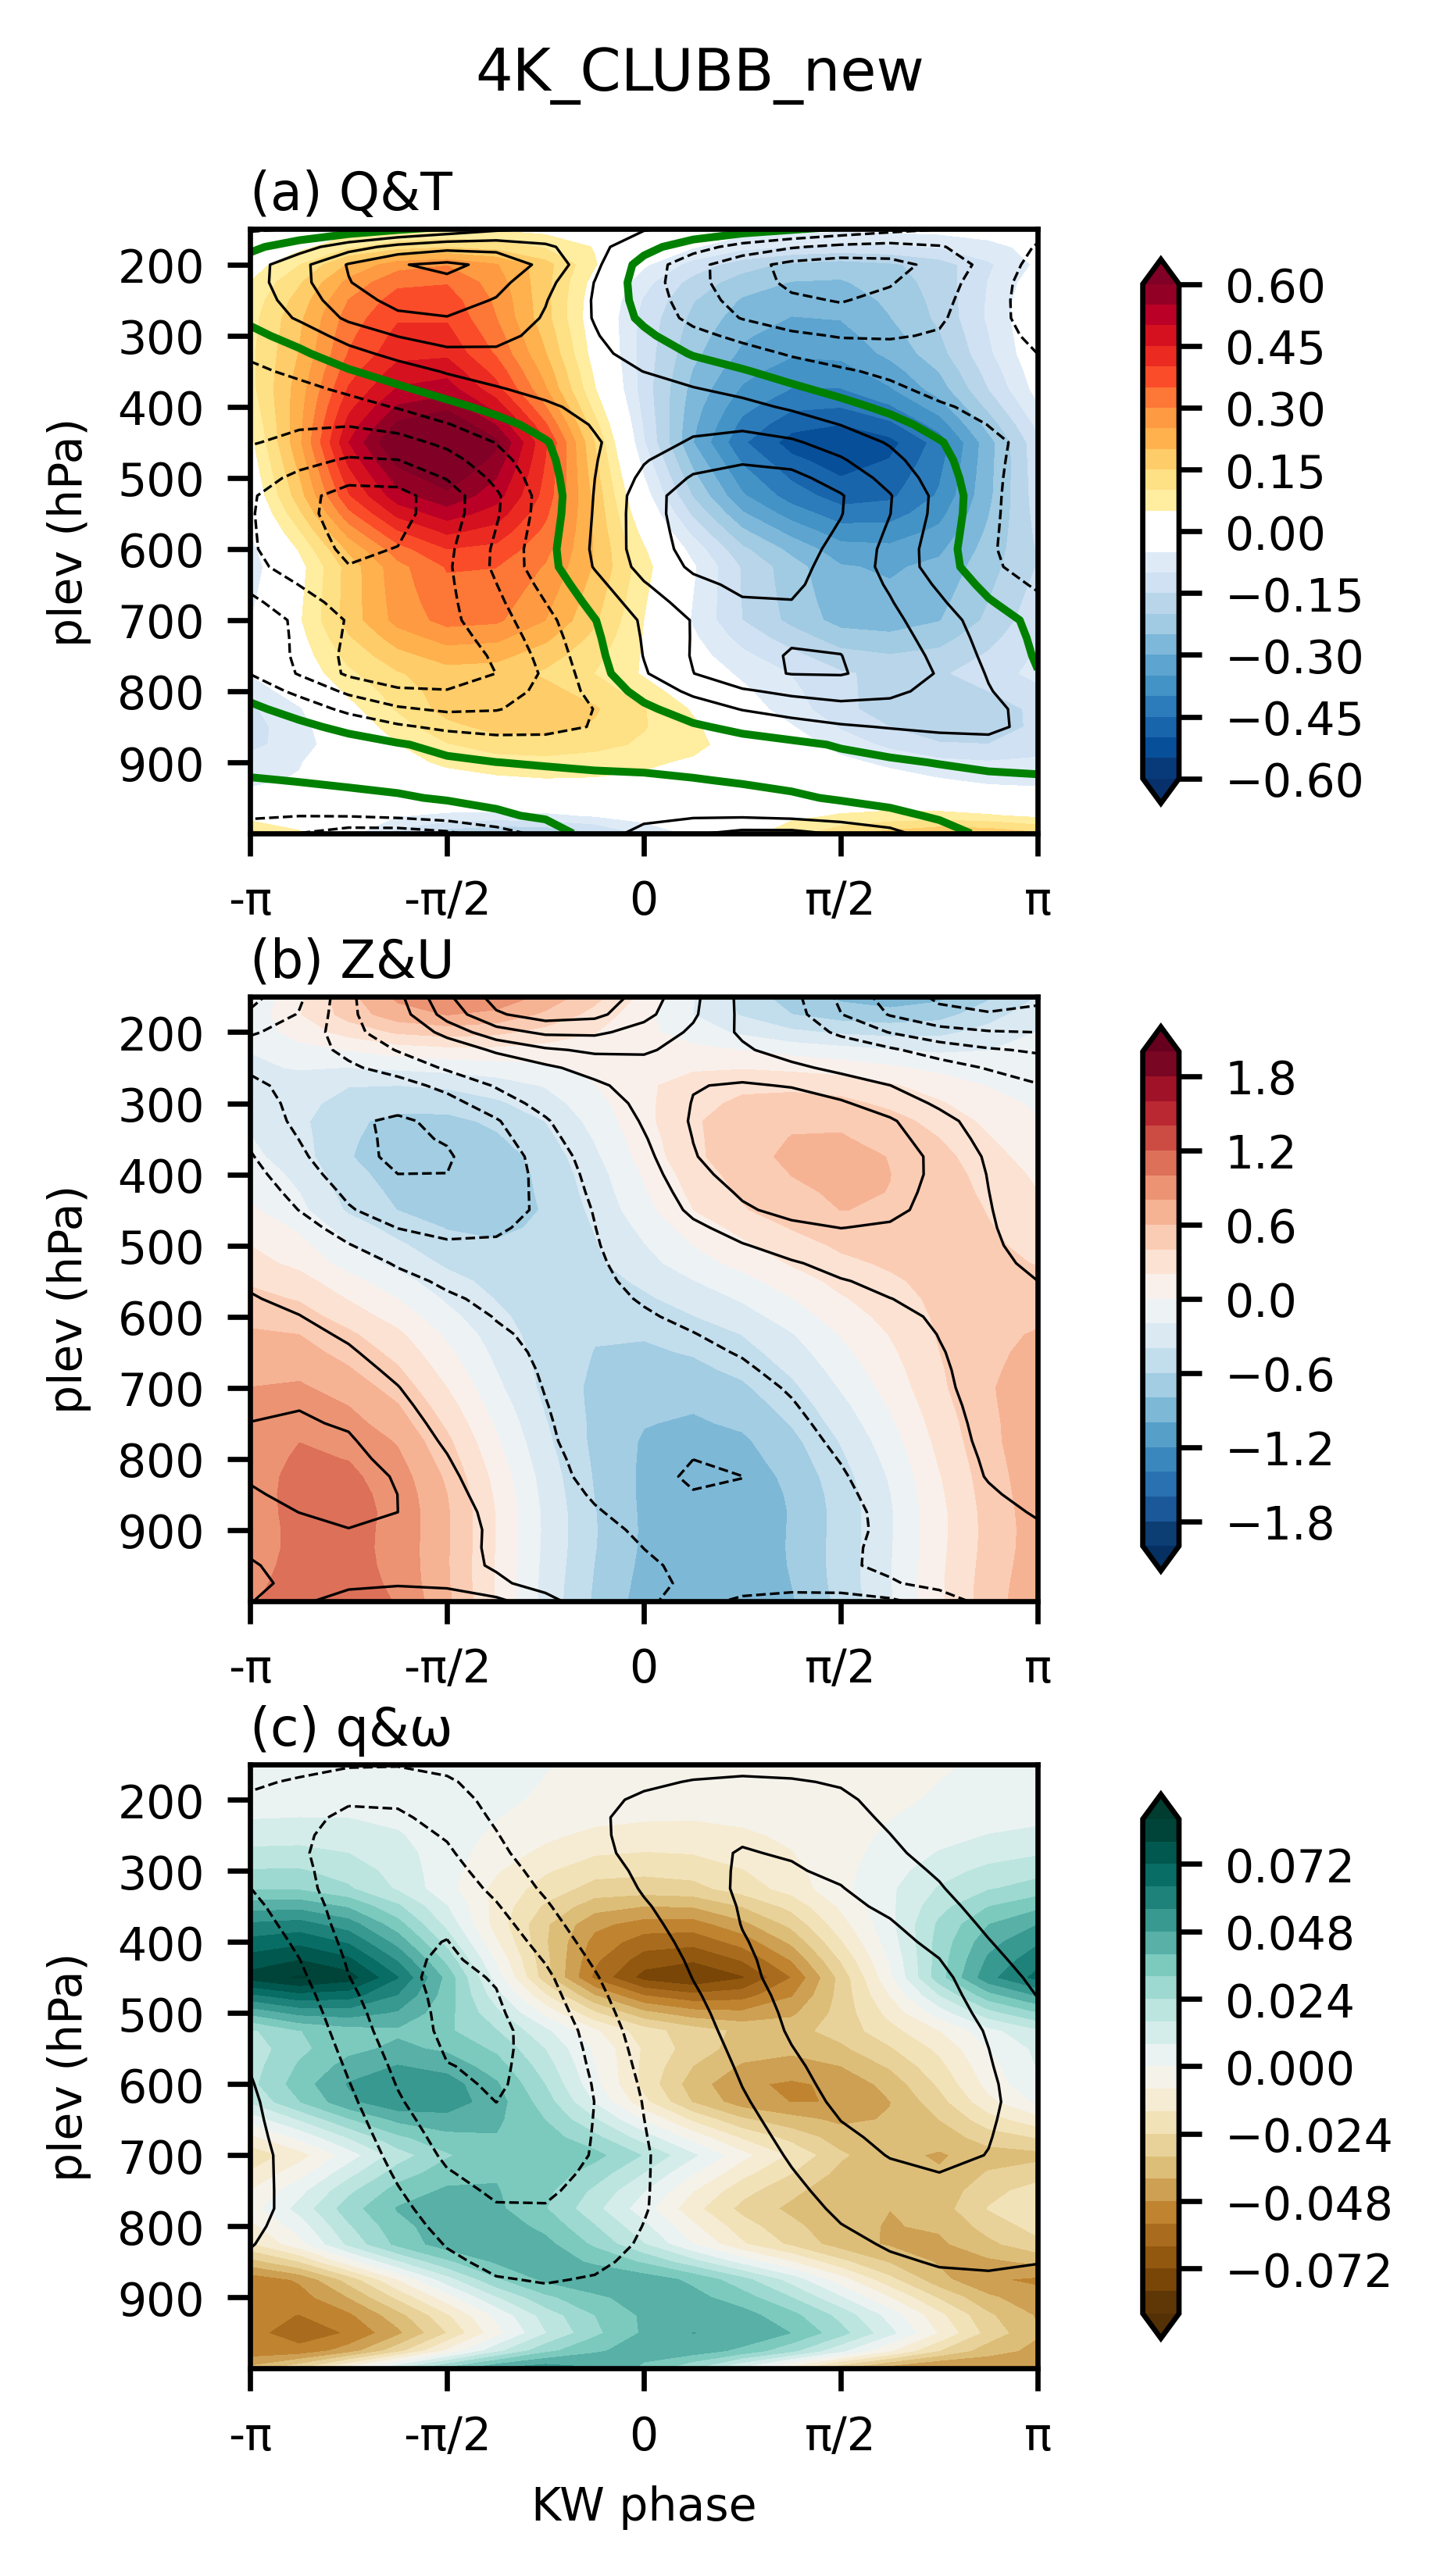

In [30]:
# Plot the vertical structure of KW
font = 7
plot_kwcomposite_vert_struct = 1
normalize_by_kwpr = 1 # or 0
norm = list(['','_normalize_by_kwpr'])

if plot_kwcomposite_vert_struct == 1:
    
    if inudge == 0 or inudge == 24 or inudge == 25:
        CASENAME_SHORT = CASENAME_SHORT_LIST[icase]+'_CLUBB_new'
    else:
        CASENAME_SHORT = CASENAME_SHORT_LIST[icase]+'_'+NUDGE_LIST[inudge]
    figdir     = dir_out+'figure/Post_general/Nudging/'+CASENAME_SHORT+'/'
    
    ######################
    # Calculate vertical mode decomp
    ilevmin_Q = 0 #np.argwhere(plev==75).squeeze() 
    ilevmax_Q = np.size(plev) #np.argwhere(plev==950).squeeze()
        
    # PLotting
    plot_fignum = 3 
    clev_0 = 0
    txt_xloc = -6
    txt_yloc = (np.min(plev)+np.max(plev))/2
    row_name = list(['(a) Q&T','(b) Z&U','(c) q&\u03C9'])

    for iplt in range(0,1): # if iplt == 0, plot QT, if iplt == 1, plot uF

        xx, yy = np.meshgrid(phase, plev)
        if normalize_by_kwpr == 1:
            c = kw_amp
            const_clev = 2.5
        else:
            c = 1
            const_clev = 1
        print(c)
        
        # Set contour and contourf levels
        if iplt == 0: # plot Q,T
            clev_n  = np.arange(-6,0,0.5)*0.5/4/const_clev #T
            clev_p  = np.arange(0.5,6.5,0.5)*0.5/4/const_clev #T
            clev    = np.arange(-6,6.5,0.5)/4/const_clev#*0.5 #Q
            clev1_n = np.arange(-3.3,0,0.3)/const_clev #U
            clev1_p = np.arange(0.3,3.3,0.3)/const_clev #U
            clev1   = np.arange(-5,5.5,0.5)/const_clev #Z
            clev2   = np.arange(-0.22,0.24,0.02)/const_clev #q
            clev2_n = np.arange(-0.06,0,0.01)/const_clev #W
            clev2_p = np.arange(0.01,0.06,0.01)/const_clev #W

            VAR_cf  = Q_KW[:,ilevmin_Q:ilevmax_Q+1]*s2d/c
            VAR_cn  = T_KW[:,ilevmin_Q:ilevmax_Q+1]/c                
            VAR1_cf = Z_KW[:,ilevmin_Q:ilevmax_Q+1]/c
            VAR2_cf = q_KW[:,ilevmin_Q:ilevmax_Q+1]*1000/c
            VAR1_cn = U_KW[:,ilevmin_Q:ilevmax_Q+1]/c
            VAR2_cn = W_KW[:,ilevmin_Q:ilevmax_Q+1]/c

        fig,axes = plt.subplots(plot_fignum,1,figsize=(3.2, 5.5),dpi=600)
        plt.subplots_adjust(left=0.2,right=0.9,top=0.93,bottom=0.1,hspace=0.27)
        plt.rcParams.update({'font.size': font})

        plt.subplot(plot_fignum,1,1)
        ax = plt.gca()
        plt.suptitle(CASENAME_SHORT, fontsize=9, y=1.001)
        plt.title(row_name[0],pad=3, loc='left',fontsize=8)
        cf  = plt.contourf(xx, yy, VAR_cf.T, levels=clev, cmap=get_cmap(RWB), extend='both' )
        cn_p = plt.contour(xx, yy, VAR_cn.T, levels=clev_p, colors='k', linewidths=0.4)
        cn_0 = plt.contour(xx, yy, VAR_cn.T, levels=clev_0, colors='g', linewidths=1.2)
        cn_n = plt.contour(xx, yy, VAR_cn.T, levels=clev_n, colors='k', linestyles='dashed',linewidths=0.4)
        plt.ylim([150, np.max(plev)])
        plt.yticks(np.arange(200,1000,100),fontsize=font)
        plt.gca().invert_yaxis()
        plt.xticks(np.arange(-pi,pi+pi/2,pi/2),('-'+PI,'-'+PI+'/2','0',PI+'/2',PI),fontsize=font)
        plt.tick_params(bottom=True,top=False,left=True,right=False)
        plt.tick_params(labelbottom=True,labeltop=False,labelleft=True,labelright=False)
        #plt.text(txt_xloc,txt_yloc,row_name[0],fontsize=8,horizontalalignment='center',verticalalignment='center') 
        #ax.yaxis.set_label_position("right")
        ax.set_ylabel('plev (hPa)',fontsize=font)
        cb = plt.colorbar(cf,ax=axes[0],orientation = 'vertical', shrink=.9, aspect=15,pad=0.1)
        
        plt.subplot(plot_fignum,1,2)
        plt.title(row_name[1],pad=3, loc='left',fontsize=8)
        ax = plt.gca()
        cf  = plt.contourf(xx, yy, VAR1_cf.T, levels=clev1, cmap='RdBu_r', extend='both' )
        cn_p = plt.contour(xx, yy, VAR1_cn.T, levels=clev1_p, colors='k', linewidths=0.4)
        cn_n = plt.contour(xx, yy, VAR1_cn.T, levels=clev1_n, colors='k', linestyles='dashed',linewidths=0.4)
        plt.ylim([150, np.max(plev)])
        plt.yticks(np.arange(200,1000,100),fontsize=font)
        plt.gca().invert_yaxis()
        plt.xticks(np.arange(-pi,pi+pi/2,pi/2),('-'+PI,'-'+PI+'/2','0',PI+'/2',PI),fontsize=font)
        plt.tick_params(bottom=True,top=False,left=True,right=False)
        plt.tick_params(labelbottom=True,labeltop=False,labelleft=True,labelright=False)
        #plt.text(txt_xloc,txt_yloc,row_name[1],fontsize=8,horizontalalignment='center',verticalalignment='center') 
        #ax.yaxis.set_label_position("right")
        ax.set_ylabel('plev (hPa)',fontsize=font)
        cb = plt.colorbar(cf,ax=axes[1],orientation = 'vertical', shrink=.9, aspect=15,pad=0.1)

        plt.subplot(plot_fignum,1,3)
        plt.title(row_name[2],pad=3, loc='left',fontsize=8)
        ax = plt.gca()
        cf  = plt.contourf(xx, yy, VAR2_cf.T, levels=clev2, cmap='BrBG', extend='both' )
        cn_p = plt.contour(xx, yy, VAR2_cn.T, levels=clev2_p, colors='k', linewidths=0.4)
        cn_n = plt.contour(xx, yy, VAR2_cn.T, levels=clev2_n, colors='k', linestyles='dashed',linewidths=0.4) 
        plt.ylim([150, np.max(plev)])
        plt.yticks(np.arange(200,1000,100),fontsize=font)
        plt.gca().invert_yaxis()
        plt.xticks(np.arange(-pi,pi+pi/2,pi/2),('-'+PI,'-'+PI+'/2','0',PI+'/2',PI),fontsize=font)
        plt.tick_params(bottom=True,top=False,left=True,right=False)
        plt.tick_params(labelbottom=True,labeltop=False,labelleft=True,labelright=False)
        #plt.text(txt_xloc,txt_yloc,row_name[2],fontsize=8,horizontalalignment='center',verticalalignment='center') 
        #ax.yaxis.set_label_position("right")
        ax.set_ylabel('plev (hPa)',fontsize=font)
        plt.xlabel('KW phase',fontsize=font)
        cb = plt.colorbar(cf,ax=axes[2],orientation = 'vertical', shrink=.9, aspect=15,pad=0.1)
        if iplt == 0:
            plt.savefig(figdir+'QTZUq_KW'+norm[normalize_by_kwpr]+'.png',dpi=600)
        plt.show()
        plt.close()

finish vertical integration
Theta before adjustment: 0.39269908169872414
Theta final: 0.39269908169872414


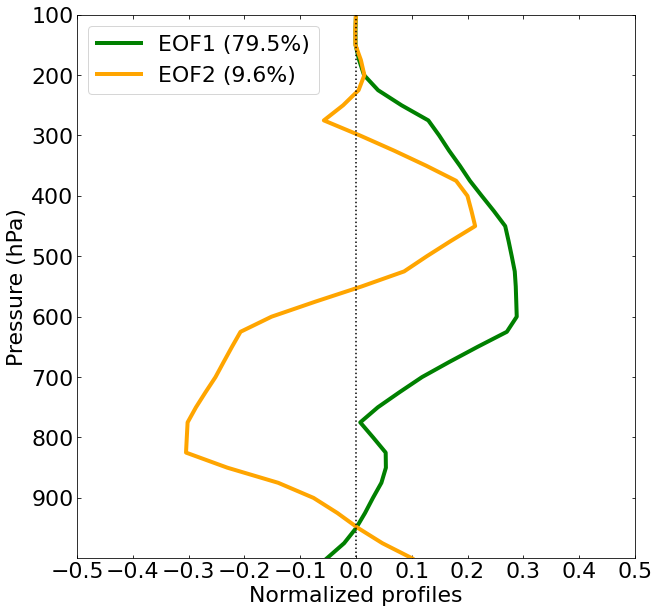

In [36]:
###############################
# Calculate EOF
############################
saved_eof = 0

if saved_eof == 0:

    # Load Qa
    data = np.load(output_dir+'QTUVZq.npz')
    Qa    = data['Qa'] #(time, plev, lon), projected Q, without 10-day low pass filtered variability
    
    EOF1, EOF2, PC1, PC2 = KW.calculate_plot_eof(Qa[:,:,:], plev, 0, figdir)

    # Rotation of EOF
    R_EOF1_raw, R_EOF2_raw, th = KW.rotate_eof(EOF1, EOF2, plev, icase, figdir)

    # Apply 10 passes of 1-2-1 filter for smoothing of EOF
    R_EOF1_smooth = KW.smoothing_121(R_EOF1_raw)
    R_EOF2_smooth = KW.smoothing_121(R_EOF2_raw)

    np.savez(output_dir+'EOF.npz', R_EOF1_raw=R_EOF1_raw, R_EOF2_raw=R_EOF2_raw,\
        R_EOF1_smooth=R_EOF1_smooth, R_EOF2_smooth=R_EOF2_smooth, plev=plev) 
else:
    data = np.load(output_dir+'EOF.npz')
    R_EOF1_smooth = data['R_EOF1_smooth']
    R_EOF2_smooth = data['R_EOF2_smooth']
    plev          = data['plev']

In [37]:
#############################################
# Calculate vertical mode decomposition
###########################################
calc_vmd = 1

if calc_vmd == 1:
    for inug in range(inudge, inudge+1):
    
        CASENAME   = CASENAME_LIST2[icase]+'_'+NUDGE_LIST[inug]
        output_dir = dir_out+'output_data/'+CASENAME+'/'
    
        # lOAD EOF
        data = np.load(output_dir+'EOF.npz')
        EOF1 = data['R_EOF1_smooth']
        EOF2 = data['R_EOF2_smooth']
        plev = data['plev']
        nlev = np.size(plev)
    
        # lOAD KW COMPOSITE QT
        data = np.load(output_dir+'QTUVZq_kw.npz')
        phase = data['phase']
        nphase = np.size(phase)
        if inug == inudge:
            Q1_KW = np.empty([nphase, nlev])
            Q2_KW = np.empty([nphase, nlev])
            T1_KW = np.empty([nphase, nlev])
            T2_KW = np.empty([nphase, nlev])
            PCT1_KW = np.empty([nphase])
            PCT2_KW = np.empty([nphase])
            PCQ1_KW = np.empty([nphase])
            PCQ2_KW = np.empty([nphase])
        Q_KW = data['Q_KW']
        T_KW = data['T_KW']
        
        if np.size(Q_KW,1)!=np.size(plev):
            print('Vertical dimension mismatch between Q_KW and EOF1!')
        else:
            T1_KW[:,:], T2_KW[:,:] = KW.vertical_mode_decomposition(T_KW[:,:], EOF1, EOF2)
            Q1_KW[:,:], Q2_KW[:,:] = KW.vertical_mode_decomposition(Q_KW[:,:], EOF1, EOF2)
            PCT1_KW[:] = np.inner(T_KW[:,:], EOF1)
            PCQ1_KW[:] = np.inner(Q_KW[:,:], EOF1)
            PCT2_KW[:] = np.inner(T_KW[:,:], EOF2)
            PCQ2_KW[:] = np.inner(Q_KW[:,:], EOF2)

    
    np.savez(output_dir+'kw_composite_PC1_PC2.npz', PCQ1_KW=PCQ1_KW, PCQ2_KW=PCQ2_KW,\
             PCT1_KW=PCT1_KW, PCT2_KW=PCT2_KW, phase=phase)
    
    np.savez(output_dir+'kw_composite_QT_vertical_mode_decomposition.npz',
        T1_KW=T1_KW, T2_KW=T2_KW,\
        Q1_KW=Q1_KW, Q2_KW=Q2_KW,\
        plev=plev, phase=phase)
else:
    data = np.load(output_dir+'kw_composite_PC1_PC2.npz')
    PCQ1_KW = data['PCQ1_KW']
    PCQ2_KW = data['PCQ2_KW']
    EAPE_GR1 = 2*np.mean(PCQ1_KW[:]*PCT1_KW[:],0)/np.mean(PCT1_KW[:]**2,0)*s2d
    EAPE_GR2 = 2*np.mean(PCQ2_KW[:]*PCT2_KW[:],0)/np.mean(PCT2_KW[:]**2,0)*s2d
    
    np.savez(output_dir+'EAPE_growth_rate.npz',EAPE_GR1=EAPE_GR1, EAPE_GR2=EAPE_GR2)
    print('EAPE gr1:',EAPE_GR1)
    print('EAPE gr2:',EAPE_GR2)

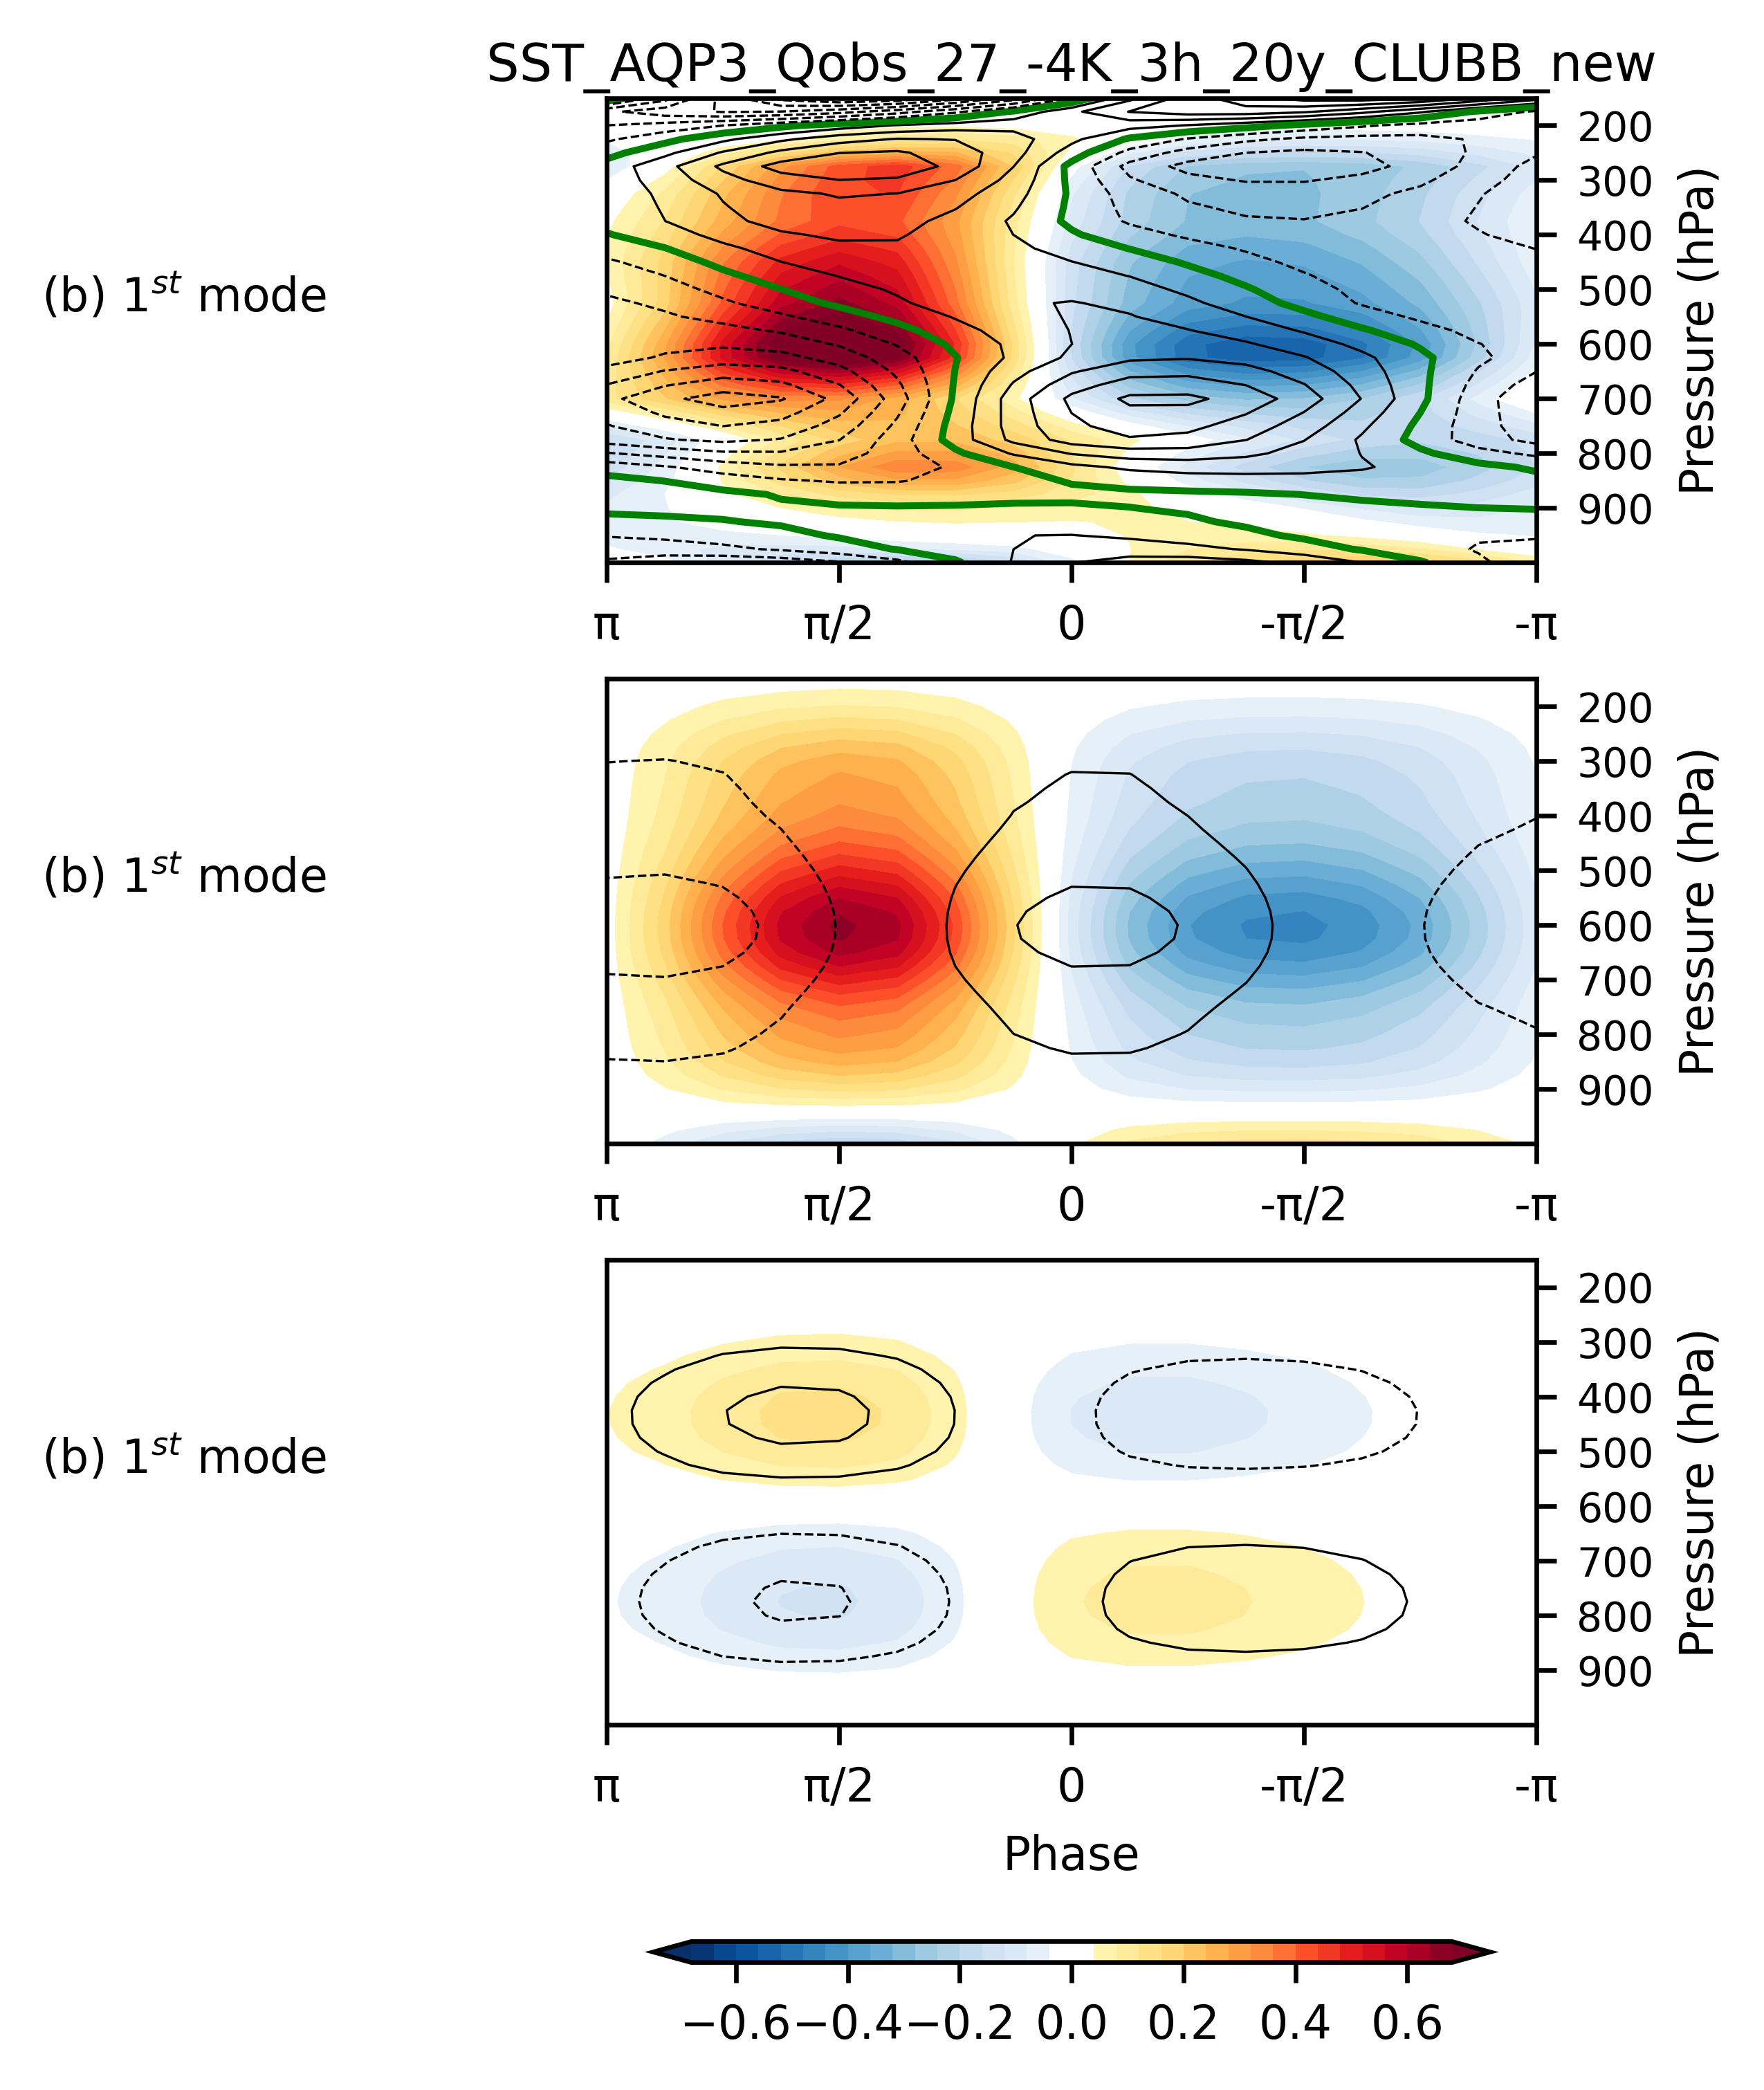

In [38]:
##############################################################
# Plot vertical mode decomposition for no nudge, nudge Q, nudge T
#################################################################
normalize_by_kwpr = 1
if normalize_by_kwpr == 1:
    c = 2.5 # divide by this constant for clev
else:
    c = 1

plot_fignum = 3 # how many rows
txt_xloc = -6
txt_yloc = (np.min(plev)+np.max(plev))/2
row_name = list(['(a) Total','(b) 1$^{st}$ mode','(c) 2$^{nd}$ mode'])
title_noabc = list([CASENAME])
clev_0 = 0
font = 8
plev_min = 150

# Load KW amplitude
data          = np.load(output_dir+'precip_kw.npz')
pr_kw         = data['pr_kw']
phase_bin     = data['phase_bin']
kw_amp  = (np.max(pr_kw)-np.min(pr_kw))/2  

for iplt in range(0,1): #(iplt=0, QT)
    
    fig,axes = plt.subplots(3,1,figsize=(3.2, 5.5),dpi=600)
    plt.subplots_adjust(left=0.2,right=0.9,top=0.95,bottom=0,hspace=0.25,wspace=0.1)
    plt.rcParams.update({'font.size': font})
    
    if iplt == 0:
        clev = np.arange(-1.7,1.8,0.1)/c
        clev_n = np.arange(-0.96,0,0.08)/c
        clev_p = np.arange(0.08,1.04,0.08)/c
        cticks = np.arange(-0.6,0.8,0.2)
        var_cf  = globals()['Q_KW']*s2d
        var_cn  = globals()['T_KW']
        var1_cf = globals()['Q1_KW']*s2d
        var2_cf = globals()['Q2_KW']*s2d
        var1_cn = globals()['T1_KW']
        var2_cn = globals()['T2_KW']
    
    if normalize_by_kwpr == 1:
        var_cf[:,:]  = var_cf[:,:]/kw_amp
        var_cn[:,:]  = var_cn[:,:]/kw_amp
        var1_cf[:,:] = var1_cf[:,:]/kw_amp
        var2_cf[:,:] = var2_cf[:,:]/kw_amp
        var1_cn[:,:] = var1_cn[:,:]/kw_amp
        var2_cn[:,:] = var2_cn[:,:]/kw_amp

    for i in range(0,1): #icase

        
        plt.subplot(plot_fignum,1,i+1)
        ax = plt.gca()
        plt.title(title_noabc[i], pad=3, loc='center',fontsize=9)
        xx, yy = np.meshgrid(phase, plev)
        cf  = plt.contourf(xx, yy, var_cf[:,:].T, levels=clev, cmap=get_cmap(RWB), extend='both' )
        cn_p = plt.contour(xx, yy, var_cn[:,:].T, levels=clev_p, colors='k', linewidths=0.4)
        cn_0 = plt.contour(xx, yy, var_cn[:,:].T, levels=clev_0, colors='g', linewidths=1.2)
        cn_n = plt.contour(xx, yy, var_cn[:,:].T, levels=clev_n, colors='k', linestyles='dashed',linewidths=0.4)
        plt.ylim([plev_min,np.max(plev)])
        plt.yticks(np.arange(200,1000,100))
        plt.gca().invert_yaxis()
        plt.xticks(bin_simple2,(PI,PI+'/2','0','-'+PI+'/2','-'+PI),fontsize=font)
        plt.tick_params(bottom=True,top=False,left=False,right=True)
        if i == 0:
            plt.text(txt_xloc,txt_yloc,row_name[1],fontsize=8,horizontalalignment='center',verticalalignment='center') 
            plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=True)
            ax.yaxis.set_label_position("right")
            ax.set_ylabel('Pressure (hPa)',fontsize=font)

        plt.subplot(plot_fignum,1,i+1+1)
        ax = plt.gca()
        cf  = plt.contourf(xx, yy, var1_cf[:,:].T, levels=clev, cmap=get_cmap(RWB), extend='both' )
        cn_p = plt.contour(xx, yy, var1_cn[:,:].T, levels=clev_p, colors='k', linewidths=0.4)
        cn_n = plt.contour(xx, yy, var1_cn[:,:].T, levels=clev_n, colors='k', linestyles='dashed',linewidths=0.4)
        plt.ylim([plev_min,np.max(plev)])
        plt.yticks(np.arange(200,1000,100))
        plt.gca().invert_yaxis()
        plt.xticks(bin_simple2,(PI,PI+'/2','0','-'+PI+'/2','-'+PI),fontsize=font)
        plt.tick_params(bottom=True,top=False,left=False,right=True)
        if i == 0:
            plt.text(txt_xloc,txt_yloc,row_name[1],fontsize=8,horizontalalignment='center',verticalalignment='center') 
            plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=True)
            ax.yaxis.set_label_position("right")
            ax.set_ylabel('Pressure (hPa)',fontsize=font)

        plt.subplot(plot_fignum,1,i+1+2)
        ax = plt.gca()
        cf  = plt.contourf(xx, yy, var2_cf[:,:].T, levels=clev, cmap=get_cmap(RWB), extend='both' )
        cn_p = plt.contour(xx, yy, var2_cn[:,:].T, levels=clev_p, colors='k', linewidths=0.4)
        cn_n = plt.contour(xx, yy, var2_cn[:,:].T, levels=clev_n, colors='k', linestyles='dashed',linewidths=0.4) 
        plt.ylim([plev_min, np.max(plev)])
        plt.yticks(np.arange(200,1000,100))
        plt.gca().invert_yaxis()
        plt.xticks(bin_simple2,(PI,PI+'/2','0','-'+PI+'/2','-'+PI),fontsize=font)
        plt.tick_params(bottom=True,top=False,left=False,right=True)
        if i == 0:
            plt.text(txt_xloc,txt_yloc,row_name[1],fontsize=8,horizontalalignment='center',verticalalignment='center') 
            plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=True)
            ax.yaxis.set_label_position("right")
            ax.set_ylabel('Pressure (hPa)',fontsize=font)

        plt.xlabel('Phase',fontsize=font)
    cb = plt.colorbar(cf,ax=axes[:],orientation = 'horizontal', shrink=.9, aspect=40,pad=0.1) 
    cb.set_ticks(cticks) 
    if iplt == 0:
        plt.savefig(figdir+'fig7_QT_KW_1st_2nd.png',dpi=600)
    plt.show()

In [ ]:
####################
# The above is more essential, while the below is more supplementary
#############################################

In [108]:
#######################################
# Calculate Cp1 and Cp2, start here!
########################################
saved_Cp12 = 0
if saved_Cp12 == 0:

    # Load Qa
    data = np.load(output_dir+'QTUVZq.npz')
    Ta    = data['Qa'] #(time, plev, lon), projected T, without 10-day low pass filtered variability
    Za    = data['Za']
    Wa    = data['Wa']
    
    # Load EOF
    data = np.load(output_dir+'EOF.npz')
    R_EOF1_smooth = data['R_EOF1_smooth']
    R_EOF2_smooth = data['R_EOF2_smooth']
    plev = data['plev']
    
    #PCWS1_raw, PCWS2_raw = KW.calculate_PCWS(Ta[:,:,:], Za[:,:,:],\
    #                        Wa[:,:,:], R_EOF1_smooth[2:-2], R_EOF2_smooth[2:-2], plev[ilevmin_Q:ilevmax_Q+1])
    PCWS1_raw, PCWS2_raw = KW.calculate_PCWS(Ta[:,:,:], Za[:,:,:],\
                            Wa[:,:,:], R_EOF1_smooth, R_EOF2_smooth, plev)

    # Calculate N^2
    
    ilev_N2_min = np.argwhere(plev_N2 == 75).squeeze()
    ilev_N2_max = np.argwhere(plev_N2 == 950).squeeze()
        
        
    data = np.load(output_dir+'W_Z.npz') 
    plev = data['plev']
        
    # Find pressure level of the lower boundary of TTL 
    ilev_STbot = np.argwhere(plev==75).squeeze()
    ilev_300   = np.argwhere(plev==300).squeeze()
    ilev_TTL, plev_TTL = KW.find_plev_tropopause(T_KW[:,:], plev, ilev_STbot, ilev_300)

        
    Cp1, Cp2, He1, He2, Lz1, Lz2, N2_1, N2_2, a1, a2 = KW.calculate_Cp1_Cp2(Tm, Zm, ilev_TTL, N2[ilev_N2_min:ilev_N2_max+1], R_EOF1_smooth[2:-2], R_EOF2_smooth[2:-2], \
                        PCQ1_raw[:,:], PCQ2_raw[:,:], PCWS1_raw[:,:], PCWS2_raw[:,:], time_pr[:], phase_correct[:,:])
        
    np.savez(output_dir+'Cp.npz', Cp1=Cp1, Cp2=Cp2, He1=He1, He2=He2, Lz1=Lz1, Lz2=Lz2, N2_1=N2_1, N2_2=N2_2, a1=a1, a2=a2)

In [35]:
###############################
# Moisture analysis 1: Check correlation coefficient between precip and moisture for each vertical level
################################
# 1. Load precip anomaly (KW-meridional projection)
data          = np.load(output_dir+'precip_kw.npz')
print(output_dir)
pr_kwproj_ano = data['pr_kwproj_ano_short']
lon           = data['lon']
time_pr       = data['time_pr']
phase_correct = data['phase_correct']
nt_new        = np.size(time_pr)
nlon          = np.size(lon)

# Load qv anomaly (KW-meridional projection)
data    = np.load(output_dir+'QTUVZq.npz')
time_q  = data['time'][time_pr[0]:time_pr[-1]+1]
q_ano   = data['qa'][time_pr[0]:time_pr[-1]+1,:,:]
T_ano   = data['Ta'][time_pr[0]:time_pr[-1]+1,:,:]
plev    = data['plev']
ilevmin = np.argwhere(plev==200).squeeze()
ilevmax = np.argwhere(plev==950).squeeze()
q_ano_small = q_ano[:,ilevmin:ilevmax+1,:]
T_ano_small = T_ano[:,ilevmin:ilevmax+1,:]
plev_small  = plev[ilevmin:ilevmax+1]

if np.shape(pr_kwproj_ano)!=np.shape(q_ano_small[:,0,:]):
    print('Shape mismatches between q and precip!')
else:
    # Seperate vertical level of moisture
    plev_st = np.arange(200,950,50)
    plev_end = plev_st+50
    nlev_new = np.size(plev_st) # average over each layer (200-250, 250-300,.....900-950)
    #qv_kw_new = np.empty([nph, nlev_new, 3])
    q_ano_new = np.empty([nt_new, nlev_new, nlon])
    T_ano_new = np.empty([nt_new, nlev_new, nlon])
    
    for i in range(0,nlev_new):
        #print(plev[i*3-i], plev[(i+1)*3-i-1])
        #qv_kw_new[:,i,:]    = np.mean(qv_kw_all[:, i*3-i:(i+1)*3-i, :],1)
        q_ano_new[:,i,:] = np.mean(q_ano_small[:, i*3-i:(i+1)*3-i, :,],1)
        T_ano_new[:,i,:]  = np.mean(T_ano_small[:, i*3-i:(i+1)*3-i, :,],1)
    
    # Calculate correlation coefficient between qv and precip
    r_qv_pr = np.empty([nlev_new])
    r_T_pr  = np.empty([nlev_new])
    for i in range(0,nlev_new):
        #tmp = np.corrcoef(qv_kw_new[:,i,icase], pr_kw_all[:,icase])
        #r_kw[i,icase] = tmp[0,1]
            
        tmp = np.corrcoef( np.ndarray.flatten(q_ano_new[:,i,:]), np.ndarray.flatten(pr_kwproj_ano[:,:]) )
        r_qv_pr[i] = tmp[0,1]

        tmp = np.corrcoef( np.ndarray.flatten(T_ano_new[:,i,:]), np.ndarray.flatten(pr_kwproj_ano[:,:]) )
        r_T_pr[i] = tmp[0,1]
    plev_new = (plev_st+plev_end)/2
    np.savez(output_dir+'corrcoef_qv_T_pr_level.npz', r_qv_pr=r_qv_pr, r_T_pr=r_T_pr, plev=plev_new)

/glade/work/muting/KW/output_data/SST_AQP3_Qobs_27_-4K_nudge_qlf_12h/


In [ ]:
# Plot correlation coefficient
r_below_500_q = np.empty([nlev_new])
r_below_500_q = np.where(plev_new<550, np.nan, r_qv_pr)

r_below_500_T = np.empty([nlev_new])
r_below_500_T = np.where(plev_new<550, np.nan, r_T_pr)

font = 7
fig,axes = plt.subplots(1,2,figsize=(5.5, 2.4),dpi=600)
plt.subplots_adjust(left=0.2,right=0.9,top=0.9,bottom=0.15,wspace=0.4)
plt.rcParams.update({'font.size': font})
for iplt in range(0,2):
    plt.subplot(1,2,iplt+1)
    if iplt == 0:
        plt.plot(r_below_500_q[:], plev_new, color='darkblue',marker='o',markersize=5, linewidth=2)
    else:
        plt.plot(r_below_500_T[:], plev_new, color='darkblue',marker='o',markersize=5, linewidth=2)
    plt.ylim([550,np.max(plev_new)])
    plt.yticks( np.arange(550, 1000, 50) )
    #plt.plot(r_below_500[:,1], plev_r, color='green',marker='o',markersize=5, linewidth=2)
    #plt.plot(r_below_500[:,2], plev_r, color='orangered',marker='o',markersize=5, linewidth=2)
    plt.tick_params(bottom=True,top=False,left=True,right=True)
    plt.tick_params(labelbottom=True,labeltop=False,labelleft=True,labelright=False)
    plt.gca().invert_yaxis()
    plt.xlabel('r')
    if iplt == 0:
        plt.title('Correlation coefficient: q & precip')
        plt.legend([CASENAME_SHORT])
        plt.ylabel('Pressure (hPa)')
    else:
        plt.title('Correlation coefficient: T & precip')
        
plt.savefig(figdir+'fig10_corrcoef_q_T_pr_level.png',dpi=600)
plt.show()

In [66]:
##################################################
# Moisture analysis 2: KW composite moisture budget (dqdt, udqdx, vdqdy, wdqdp, Q2)
################################################
# Load KW phase
data          = np.load(output_dir+'precip_kw.npz')
time_pr       = data['time_pr']
phase_correct = data['phase_correct']
pr_kw         = data['pr_kw']
kw_amp  = (np.max(pr_kw)-np.min(pr_kw))/2  
print('KW amp:',kw_amp)
print('Shape of time_pr:',np.shape(time_pr))

calc_kw_q_budget = 1 # or 1

if calc_kw_q_budget == 1:
    # Load moisture budget 
    data  = np.load(output_dir+'Q2.npz')
    dqdt  = data['dqdt'] #(time[1:-1], plev_mid, lat[1:-1], lon)
    udqdx = data['udqdx']
    vdqdy = data['vdqdy']
    wdqdp = data['wdqdp']
    Q2    = data['Q2']
    time_new = data['time']
    plev_new = data['plev']
    lat_new  = data['lat']
    lon      = data['lon']
    print('Shape of dqdt:',np.shape(dqdt))
    
    ##################################################################################
    # 1. Meridional projection and calculate anomaly by removing 10-day low pass variability
    # Term 1: dqdt
    tmp_kwproj = KW.KW_meridional_projection(dqdt, lat_new, tropics_or_midlat=0)
    del dqdt
    dqdt_ano = MJO.remove_10d_from_3hr_data(tmp_kwproj)
    
    # Term 2: udqdx
    tmp_kwproj = KW.KW_meridional_projection(udqdx, lat_new, tropics_or_midlat=0)
    del udqdx
    udqdx_ano = MJO.remove_10d_from_3hr_data(tmp_kwproj)
    
    # Term 3: vdqdy
    tmp_kwproj = KW.KW_meridional_projection(vdqdy, lat_new, tropics_or_midlat=0)
    del vdqdy
    vdqdy_ano = MJO.remove_10d_from_3hr_data(tmp_kwproj)
    
    # Term 4: wdqdp
    tmp_kwproj = KW.KW_meridional_projection(wdqdp, lat_new, tropics_or_midlat=0)
    del wdqdp
    wdqdp_ano = MJO.remove_10d_from_3hr_data(tmp_kwproj)
    
    # Term 5: Q2
    tmp_kwproj = KW.KW_meridional_projection(Q2, lat_new, tropics_or_midlat=0)
    del Q2
    Q2_ano = MJO.remove_10d_from_3hr_data(tmp_kwproj)
    
    ##############################################################
    # 2. Make sure each term have the same size as kw-filtered precip
    print(time_pr[0], time_pr[-1])
    dqdt_trim  = dqdt_ano[ time_pr[0]-1:time_pr[-1], :, :]
    del dqdt_ano
    udqdx_trim = udqdx_ano[time_pr[0]-1:time_pr[-1], :, :]
    del udqdx_ano
    vdqdy_trim = vdqdy_ano[time_pr[0]-1:time_pr[-1], :, :]
    del vdqdy_ano
    wdqdp_trim = wdqdp_ano[time_pr[0]-1:time_pr[-1], :, :]
    del wdqdp_ano
    Q2_trim    = Q2_ano[   time_pr[0]-1:time_pr[-1], :, :]
    del Q2_ano
    
    #####################################################
    # 3. Calculate KW composite
    dqdt_KW,   phase = KW.composite_by_kw_phase(dqdt_trim,  phase_correct, time_pr) #(phase, plev)
    del dqdt_trim
    udqdx_KW,  phase = KW.composite_by_kw_phase(udqdx_trim, phase_correct, time_pr)
    del udqdx_trim
    vdqdy_KW,  phase = KW.composite_by_kw_phase(vdqdy_trim, phase_correct, time_pr)
    del vdqdy_trim
    wdqdp_KW,  phase = KW.composite_by_kw_phase(wdqdp_trim, phase_correct, time_pr)
    del wdqdp_trim
    Q2_KW,     phase = KW.composite_by_kw_phase(Q2_trim,    phase_correct, time_pr)
    del Q2_trim
    
    ##################################################
    # Calculate the midpoint value so that the pressure coordinate is the same as previous figures, but only 1:-1
    Q2_KW    = ( Q2_KW[:,1:]+Q2_KW[:,:-1] )/2
    dqdt_KW  = ( dqdt_KW[:,1:]+dqdt_KW[:,:-1] )/2
    udqdx_KW = ( udqdx_KW[:,1:]+udqdx_KW[:,:-1] )/2
    vdqdy_KW = ( vdqdy_KW[:,1:]+vdqdy_KW[:,:-1] )/2
    wdqdp_KW = ( wdqdp_KW[:,1:]+wdqdp_KW[:,:-1] )/2
    plev_KW  = (plev_new[1:]+plev_new[:-1])/2
    
    np.savez(output_dir+'dqdt_udqdx_vdqdy_wdqdp_Q2_kwcomposite.npz', dqdt_KW=dqdt_KW, udqdx_KW=udqdx_KW,\
             vdqdy_KW=vdqdy_KW, wdqdp_KW=wdqdp_KW, Q2_KW=Q2_KW,\
                 plev=plev_KW, phase=phase)
else:
    data     = np.load(output_dir+'dqdt_udqdx_vdqdy_wdqdp_Q2_kwcomposite.npz')
    dqdt_KW  = data['dqdt_KW']
    udqdx_KW = data['udqdx_KW']
    vdqdy_KW = data['vdqdy_KW']
    wdqdp_KW = data['wdqdp_KW']
    Q2_KW    = data['Q2_KW']
    plev_KW  = data['plev']
    phase    = data['phase']

KW amp: 3.599426036635519
Shape of time_pr: (2563,)
Shape of dqdt: (2695, 38, 12, 144)
67 2629


[ 1.00000000e+00 -7.35783791e-01  3.74339158e-02  1.21881213e+00
  4.79537748e-01 -2.44249065e-15]


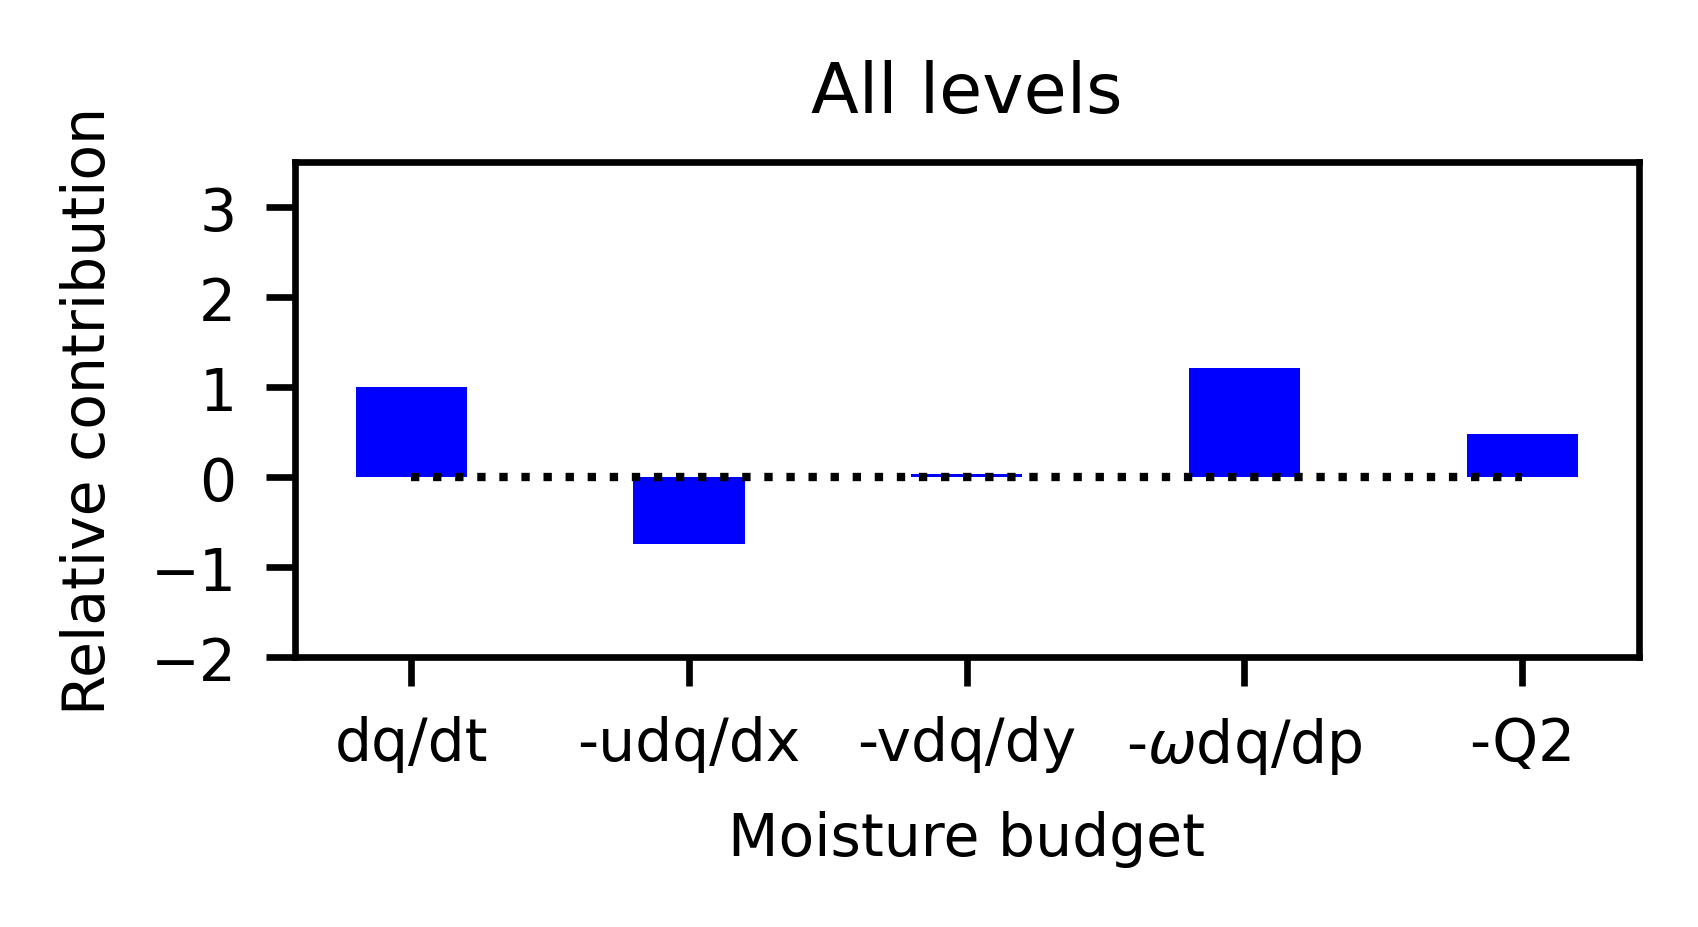

[ 1.00000000e+00 -8.30885721e-01 -1.84709932e-02  1.22504575e+00
  6.24310961e-01  6.46038778e-13]


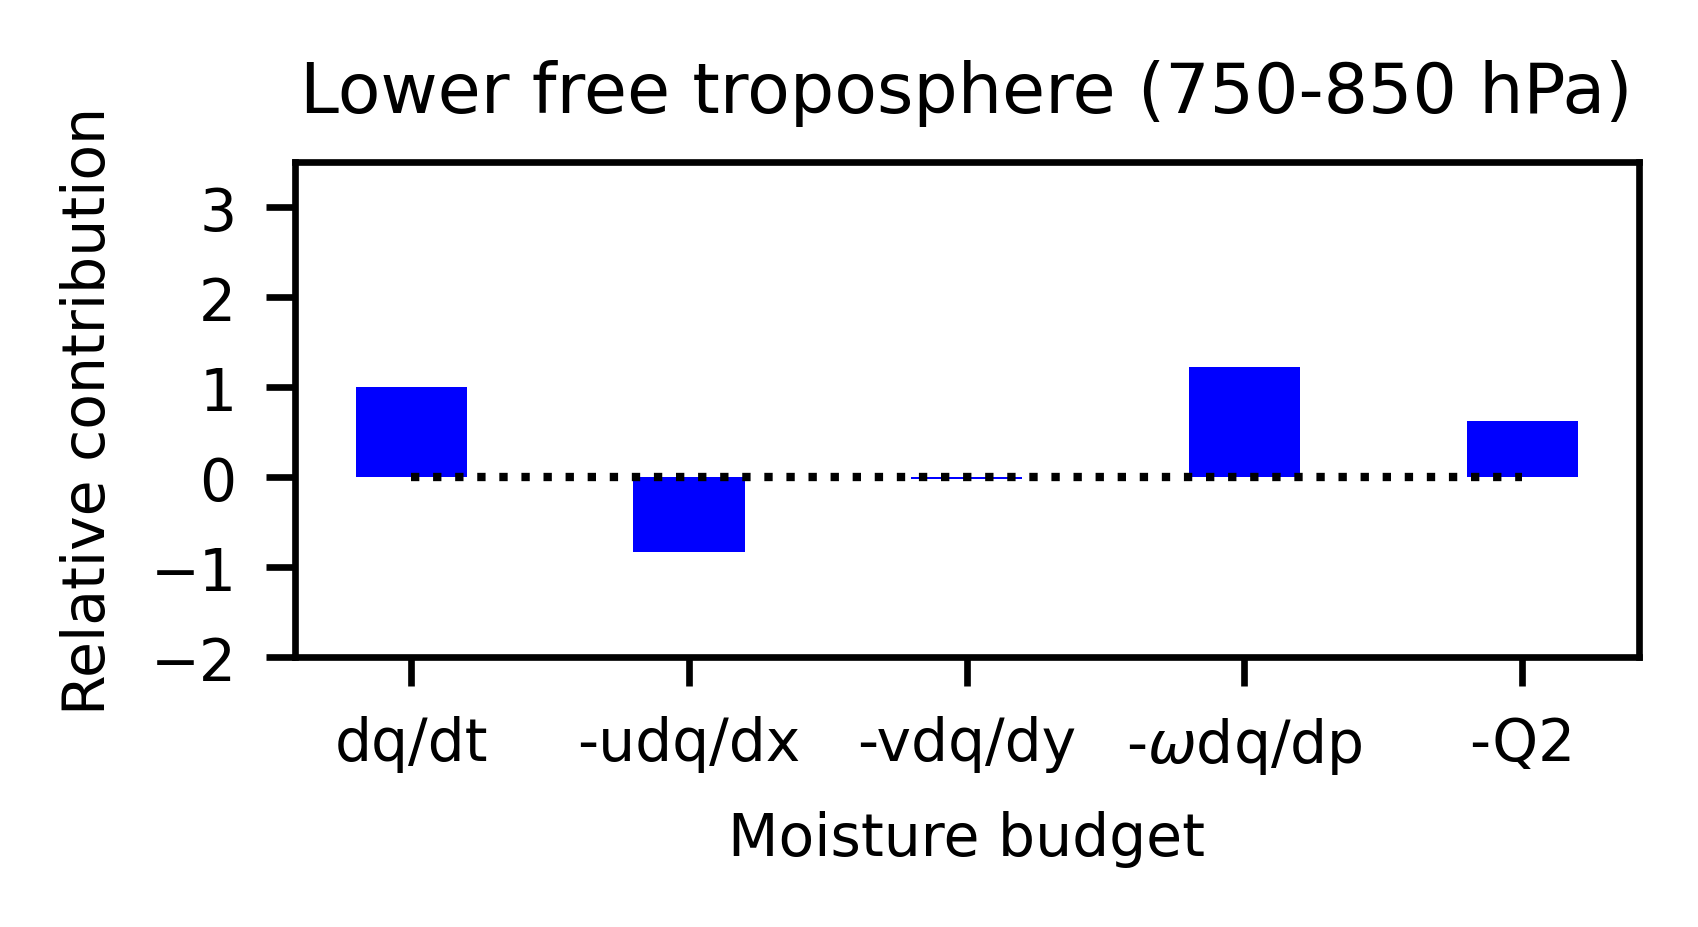

[ 1.00000000e+00 -7.92488715e-01  3.55268991e-02 -5.87180525e-01
  2.34414234e+00 -7.54951657e-15]


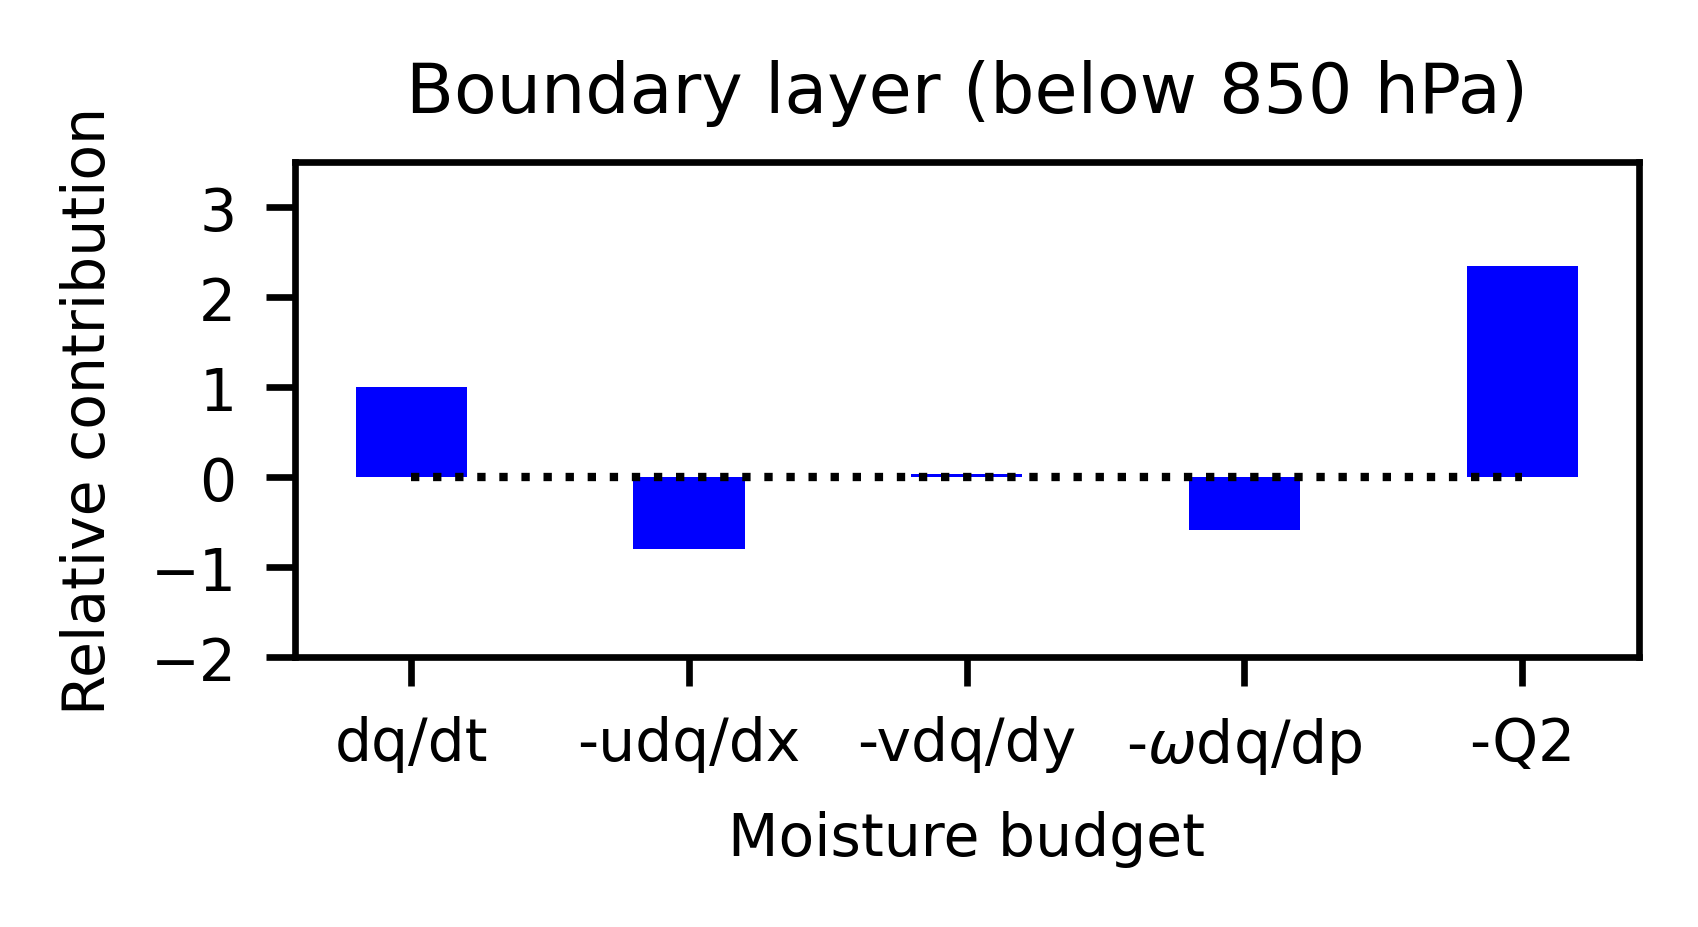

In [67]:
###################
# Calculate contribution of each term to maintenance and propagation
###################################
nlev_KW = np.size(plev_KW)
title_list = list(['All levels','Lower free troposphere (750-850 hPa)','Boundary layer (below 850 hPa)','Mid troposphere (450-650 hPa)'])
figname_list = list(['all_level','750_850','850_1000','450_650'])
# contributino to dqdt
for i in range(0,3): # or 4
    
    if i==0: # All levels
        ilev_min = 0
        ilev_max = nlev_KW
    elif i==1: # Lower free troposphere (750-850 hPa)
        ilev_min = np.argwhere(plev_KW==750).squeeze()
        ilev_max = np.argwhere(plev_KW==850).squeeze()
    elif i == 2: # Boundary layer (850- hPa)
        ilev_min = np.argwhere(plev_KW==850).squeeze()
        ilev_max = nlev_KW
    elif i == 3:
        ilev_min = np.argwhere(plev_KW==450).squeeze()
        ilev_max = np.argwhere(plev_KW==650).squeeze()
    
    r_dqdt  = np.sum(dqdt_KW[:,ilev_min:ilev_max+1]*dqdt_KW[:,ilev_min:ilev_max+1])/np.sum(dqdt_KW[:,ilev_min:ilev_max+1]**2)
    r_udqdx = np.sum(dqdt_KW[:,ilev_min:ilev_max+1]*(-udqdx_KW[:,ilev_min:ilev_max+1]))/np.sum(dqdt_KW[:,ilev_min:ilev_max+1]**2)
    r_vdqdy = np.sum(dqdt_KW[:,ilev_min:ilev_max+1]*(-vdqdy_KW[:,ilev_min:ilev_max+1]))/np.sum(dqdt_KW[:,ilev_min:ilev_max+1]**2)
    r_wdqdp = np.sum(dqdt_KW[:,ilev_min:ilev_max+1]*(-wdqdp_KW[:,ilev_min:ilev_max+1]))/np.sum(dqdt_KW[:,ilev_min:ilev_max+1]**2)
    r_Q2    = np.sum(dqdt_KW[:,ilev_min:ilev_max+1]*(-Q2_KW[:,ilev_min:ilev_max+1]))/np.sum(dqdt_KW[:,ilev_min:ilev_max+1]**2)
    r_res   = 1-r_udqdx-r_vdqdy-r_wdqdp-r_Q2
    r = np.array([r_dqdt, r_udqdx, r_vdqdy, r_wdqdp, r_Q2, r_res])
    print(r)

    font = 7
    # Plot bar plot of relative contribution of each buget term
    fig,axes = plt.subplots(1,1,figsize=(3.2, 1.5),dpi=600)
    ax = plt.gca()
    plt.subplots_adjust(left=0.2,right=0.9,top=0.8,bottom=0.25)
    plt.rcParams.update({'font.size': font})
    x = np.arange(0,5)
    zero = np.zeros([np.size(x)])
    plt.bar(x, r[:-1], color='blue',width=0.4)
    plt.plot(x, zero, 'k:', linewidth=1)
    plt.xticks(x,('dq/dt','-udq/dx','-vdq/dy','-$\omega$dq/dp','-Q2'))
    plt.xlabel('Moisture budget')
    plt.ylabel('Relative contribution')
    plt.title(title_list[i])
    if i == 0 or i == 1:
        plt.ylim([-1.5,3.5])
        plt.yticks(np.arange(-2,4,1))
        #plt.yticks(np.arange(-1,4,1))
        #plt.ylim([-1,3])
    elif i == 2:
        plt.ylim([-1.5,3.5])
        plt.yticks(np.arange(-2,4,1))
    elif i == 3:
        plt.ylim([-2,4])
        plt.yticks(np.arange(-2,6,2))        
    plt.savefig(figdir+'dqdt_contribution_'+figname_list[i]+'.png',dpi=600)
    plt.show()

kw_amp: 3.599426036635519


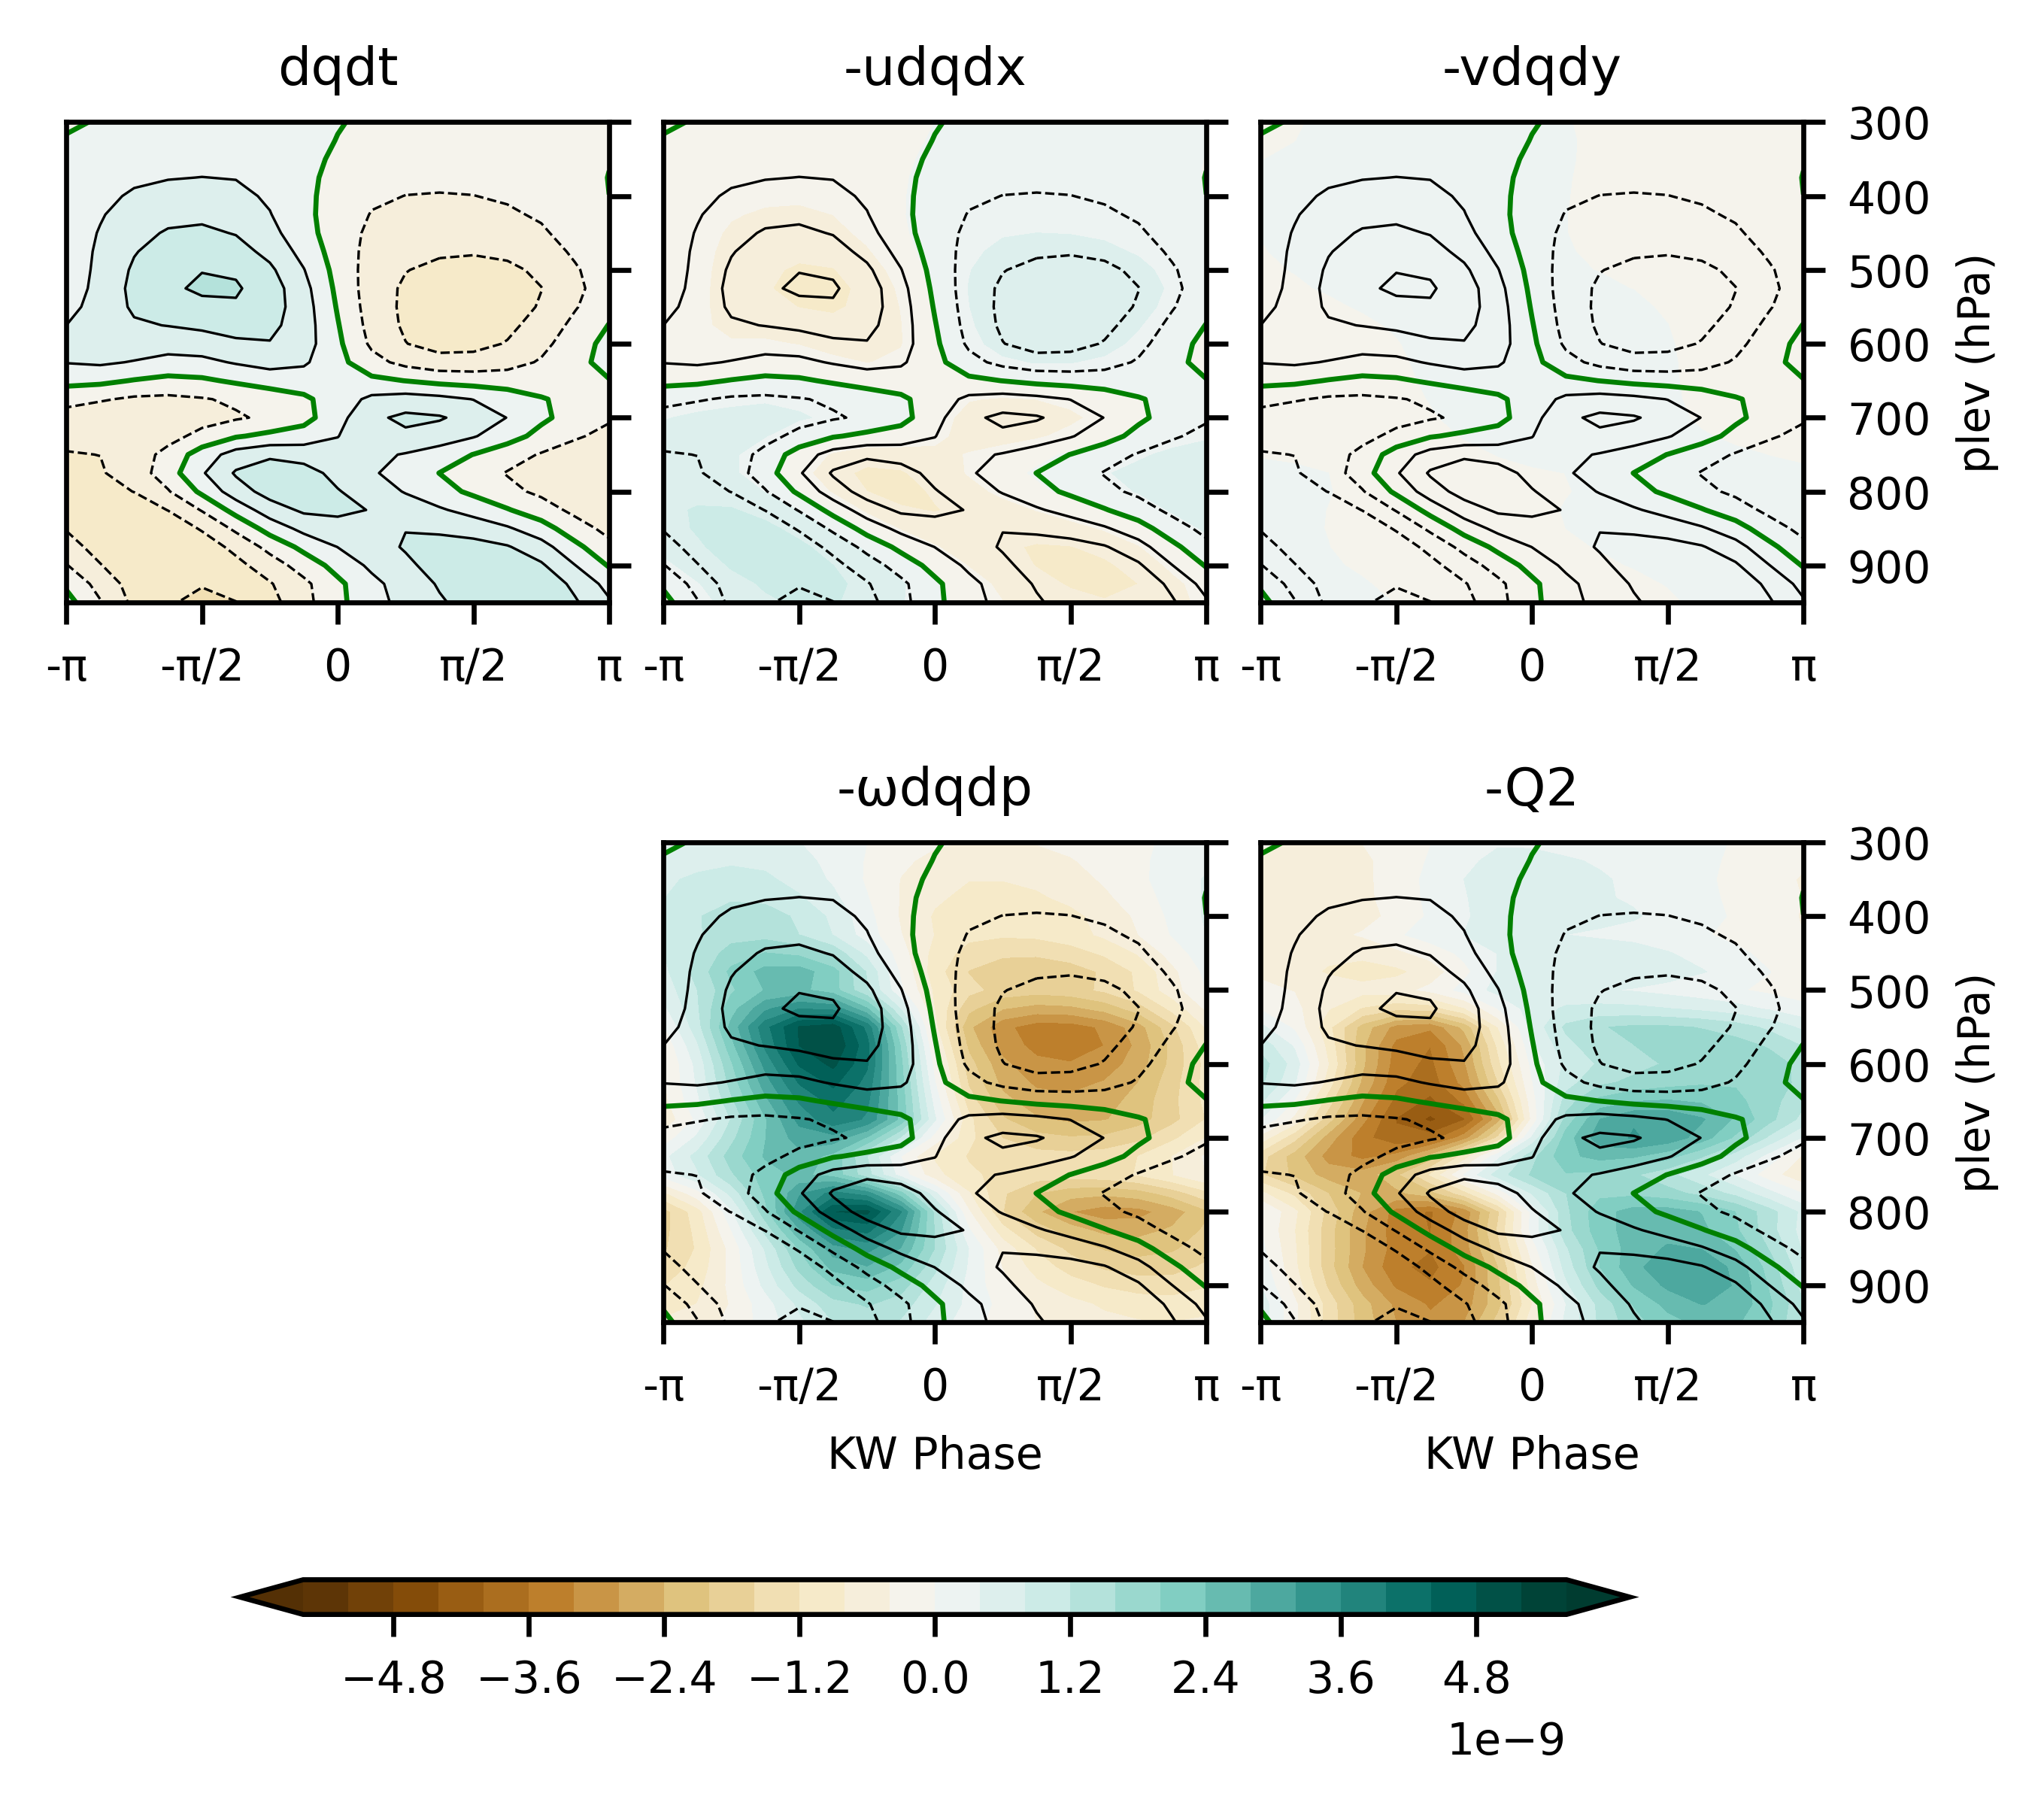

In [68]:
# Plot KW composite vertical structure of each moisture tendency term
vname_q_budget       = list(['dqdt','udqdx','vdqdy','wdqdp','Q2'])
vname_q_budget_title = list(['dqdt','-udqdx','-vdqdy','-\u03C9dqdp','-Q2'])
iplt_list = np.array([1,2,3,5,6])
font = 7

fig,axes = plt.subplots(2,3,figsize=(5.5, 4),dpi=600)
plt.subplots_adjust(left=0.2,right=0.9,top=0.95,bottom=0,hspace=0.5,wspace=0.1)
plt.rcParams.update({'font.size': font})

normalize_by_kwpr = 1
# contour levels
if normalize_by_kwpr == 1:
    c = kw_amp
    const_clev = 2.5
else:
    c = 1
    const_clev = 1
print('kw_amp:',kw_amp)

# Change color level!
clev = np.arange(-14,15,1)*10**(-9)/const_clev
clev_p = np.arange(1,15,1)*10**(-9)/const_clev
clev_n = np.arange(-14,0,1)*10**(-9)/const_clev
clev_0 = 0

xx, yy = np.meshgrid(phase, plev_KW)

for iplt in range(0,5):
    plt.subplot(2,3,iplt_list[iplt])
    ax = plt.gca()
    VAR_cf = globals() [vname_q_budget[iplt]+'_KW']
    VAR_cn = globals() [vname_q_budget[0]+'_KW'] # q budget total
    VAR_cf = VAR_cf/c
    VAR_cn = VAR_cn/c
    if iplt != 0:
        VAR_cf = -VAR_cf
    cf   = plt.contourf(xx, yy, VAR_cf.T, levels=clev, cmap='BrBG', extend='both' )
    cn_p = plt.contour(xx, yy, VAR_cn.T, levels=clev_p, colors='k', linewidths=0.4)
    cn_0 = plt.contour(xx, yy, VAR_cn.T, levels=clev_0, colors='g', linewidths=0.8)
    cn_n = plt.contour(xx, yy, VAR_cn.T, levels=clev_n, colors='k', linestyles='dashed',linewidths=0.4)
    plt.ylim([300, np.max(plev_KW)])
    plt.title(vname_q_budget_title[iplt])
    plt.yticks(np.arange(300,1000,100))
    plt.gca().invert_yaxis()
    plt.xticks(np.arange(-pi,pi+pi/2,pi/2),('-'+PI,'-'+PI+'/2','0',PI+'/2',PI),fontsize=font)
    ax.yaxis.set_label_position("right")
    plt.tick_params(bottom=True,top=False,left=False,right=True)
    if iplt == 2 or iplt == 4:
        plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=True)
        ax.set_ylabel('plev (hPa)',fontsize=font)
    else:
        plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=False)       

    if iplt > 2:
        plt.xlabel('KW Phase',fontsize=font)

cb = plt.colorbar(cf,ax=axes,orientation = 'horizontal', shrink=.8, aspect=40,pad=0.15) 

for ax in axes[1:,0]:
    ax.remove()

plt.savefig(figdir+'dqdt_wdqdp_Q2_KW.png',dpi=600)
plt.show()
plt.close()

In [ ]:
#####################################
# Not used for now: Calculate KW composite 2D structure
##################################
# Load u,v,w,gph (non KW-projected)
latmax_wide = 20
saved_uvwqz = 1
if saved_uvwqz == 0:

    # (0) Get nfile_skip
    nfile_skip = KW.find_nfile_skip(CASENAME, CASENAME_SHORT, iyr_min, iyr_max, from_cheyenne=0)

    # (1) Load zonal and meridional wind & Calculate anomaly
    vname = list(['U'])
    u, u_m, time, plev, lon, lat = KW.load_3D_data_as_1variable(CASENAME, CASENAME_SHORT, vname, iyr_min, iyr_max, latmax_wide, nfile_skip, from_cheyenne=0, kw_proj=0)
    u_ano = MJO.remove_10d_from_3hr_data(u) #(time, plev, lat, lon)
    print('finish u')
    
    vname = list(['V'])
    v, v_m, time, plev, lon, lat = KW.load_3D_data_as_1variable(CASENAME, CASENAME_SHORT, vname, iyr_min, iyr_max, latmax_wide, nfile_skip, from_cheyenne=0, kw_proj=0)
    v_ano = MJO.remove_10d_from_3hr_data(v) #(time, plev, lat, lon)
    print('finish v')
    
    vname = list(['OMEGA'])
    w, w_m, time, plev, lon, lat = KW.load_3D_data_as_1variable(CASENAME, CASENAME_SHORT, vname, iyr_min, iyr_max, latmax_wide, nfile_skip, from_cheyenne=0, kw_proj=0)
    w_ano = MJO.remove_10d_from_3hr_data(w) #(time, plev, lat, lon)
    print('finish w')
    
    vname = list(['Z3'])
    gph, gph_m, time, plev, lon, lat = KW.load_3D_data_as_1variable(CASENAME, CASENAME_SHORT, vname, iyr_min, iyr_max, latmax_wide, nfile_skip, from_cheyenne=0, kw_proj=0)
    gph_ano = MJO.remove_10d_from_3hr_data(gph) #(time, plev, lat, lon)
    print('finish z')

    vname = list(['Q'])    
    q, q_m, time, plev, lon, lat = KW.load_3D_data_as_1variable(CASENAME, CASENAME_SHORT, vname, iyr_min, iyr_max, latmax_wide, nfile_skip, from_cheyenne=0, kw_proj=0)
    q_ano = MJO.remove_10d_from_3hr_data(q) #(time, plev, lat, lon)
    print('finish q')
    
    # Save data
    np.savez(output_dir+'uvwqz_nonKWproj_'+str(latmax_wide)+'SN.npz', \
             u=u, u_ano=u_ano,\
             v=v, v_ano=v_ano,\
             w=w, w_ano=w_ano,\
             gph=gph, gph_ano=gph_ano,\
             q=q, q_ano=q_ano,\
             time=time, plev=plev, lat=lat, lon=lon)
    del u,v,w,q,gph
else:
    data    = np.load(output_dir+'uvwqz_nonKWproj_'+str(latmax_wide)+'SN.npz')
    u_ano   = data['u_ano']
    v_ano   = data['v_ano']
    w_ano   = data['w_ano']
    q_ano   = data['q_ano']
    gph_ano = data['gph_ano']
    print(np.shape(u_ano))

In [92]:
# Calculate KW composite
calc_kw_composite_uvw = 1

if calc_kw_composite_uvw == 1:
    # 1. Make sure time dimension of the composite variables are the same as KW phase
    print(time_pr[0], time_pr[-1])
    u_trim   = u_ano[time_pr[0]:time_pr[-1]+1,   :, :, :]
    v_trim   = v_ano[time_pr[0]:time_pr[-1]+1,   :, :, :]
    w_trim   = w_ano[time_pr[0]:time_pr[-1]+1,   :, :, :]
    gph_trim = gph_ano[time_pr[0]:time_pr[-1]+1, :, :, :]
    q_trim   = q_ano[time_pr[0]:time_pr[-1]+1, :, :, :]
    del u_ano, v_ano, w_ano, gph_ano, q_ano
    
    # 2. Calcualte KW composite
    u_KW_lat,   phase  = KW.composite_by_kw_phase(u_trim,   phase_correct, time_pr)  # change this to KW.composite!
    v_KW_lat,   phase  = KW.composite_by_kw_phase(v_trim,   phase_correct, time_pr)
    w_KW_lat,   phase  = KW.composite_by_kw_phase(w_trim,   phase_correct, time_pr)
    gph_KW_lat, phase  = KW.composite_by_kw_phase(gph_trim, phase_correct, time_pr)
    q_KW_lat,   phase  = KW.composite_by_kw_phase(q_trim,   phase_correct, time_pr)
    del u_trim, v_trim, w_trim, gph_trim, q_trim
    
    np.savez(output_dir+'uvwz_kwcomposite_lat_plev_20SN.npz', u_KW_lat=u_KW_lat, v_KW_lat=v_KW_lat, w_KW_lat=w_KW_lat, gph_KW_lat=gph_KW_lat, q_KW_lat=q_KW_lat,\
                 plev=plev, lat=lat, phase=phase)
else:
    data   = np.load(output_dir+'uvwz_kwcomposite_lat_plev_20SN.npz')
    u_KW_lat   = data['u_KW_lat']
    v_KW_lat   = data['v_KW_lat']
    w_KW_lat   = data['w_KW_lat']
    gph_KW_lat = data['gph_KW_lat']
    q_KW_lat   = data['q_KW_lat']
    lat        = data['lat']
    phase      = data['phase']
    print(np.shape(u_KW_lat))

218 8523


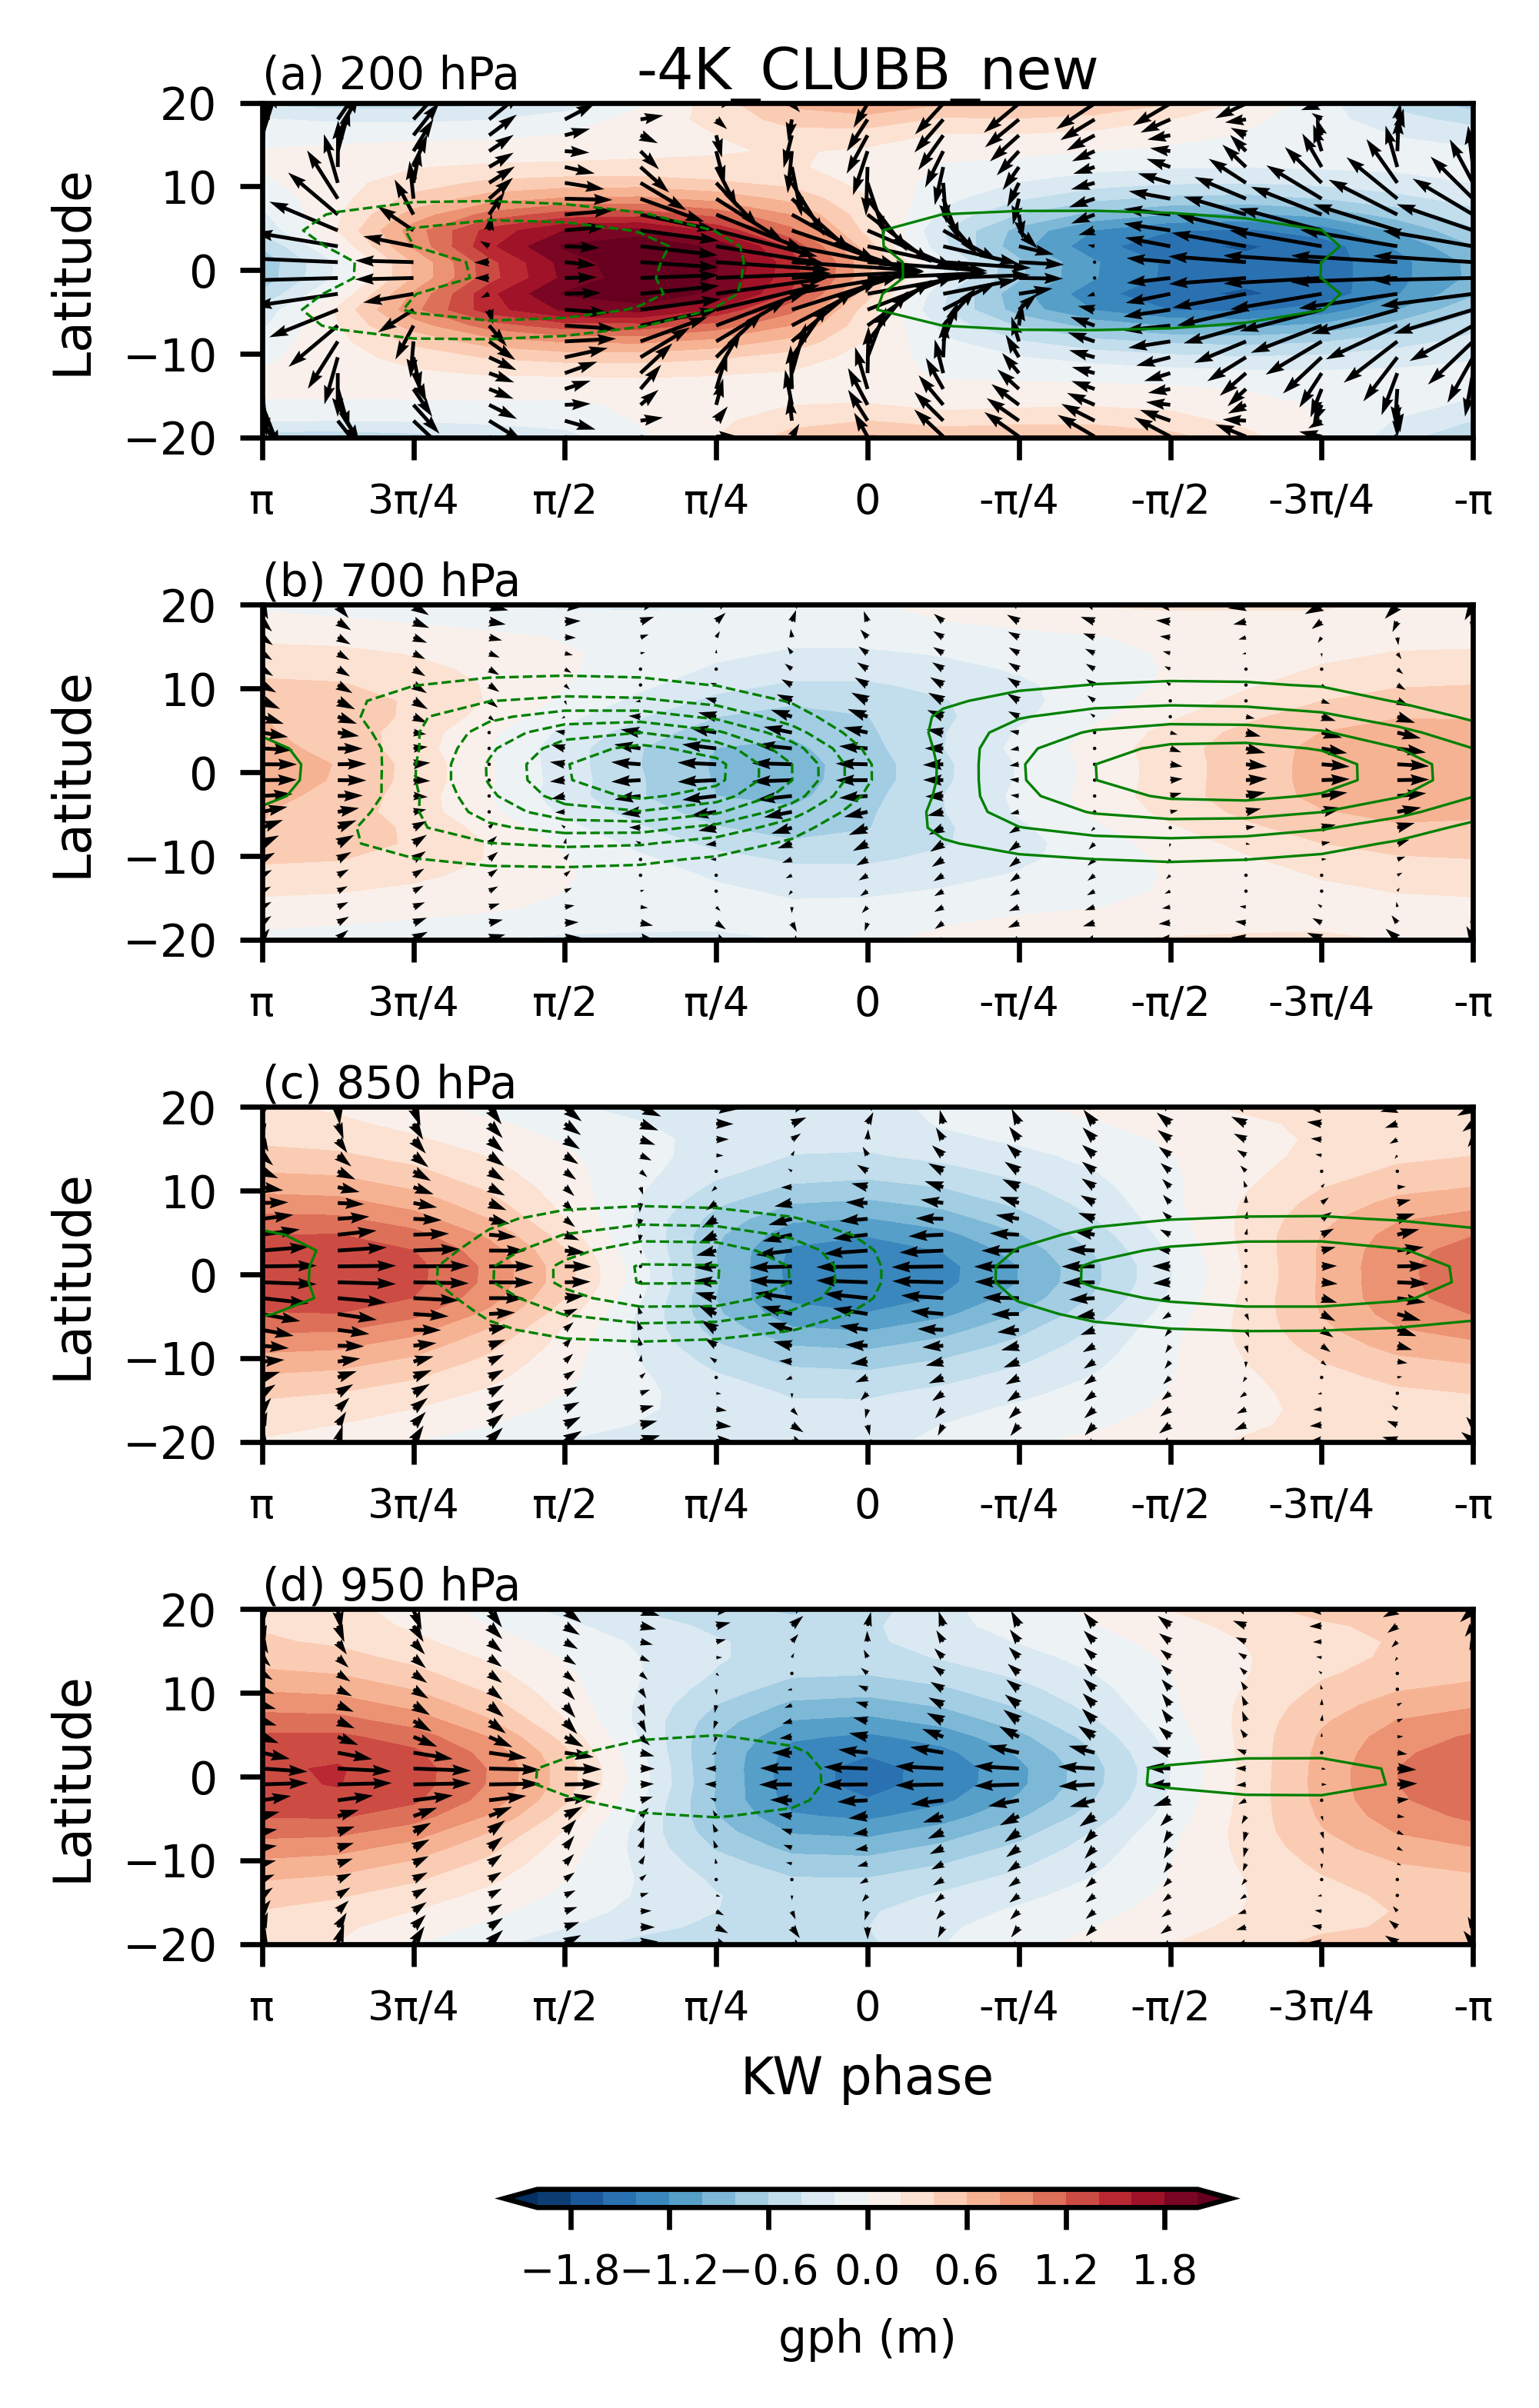

In [93]:
# Plot KW horizontal structure
ncase = 1
normalize_by_kwpr = 1 # or 0

plev_goal = np.array([200,700,850,950])
cmap_list = list(['RdBu_r'])
subtitle = list(['(a) 200 hPa','(b) 700 hPa', '(c) 850 hPa','(d) 950 hPa'])
latmax_plt = 15 #15 #20, 40 #np.max(lat)

xx, yy = np.meshgrid(phase, lat)
title = list(['-4K','CTL','+4K'])
pltnum = np.size(title)
font = 8
fig_name = 'KW_composite_uvz_plev_lat_'+str(latmax_plt)+'SN.png'
fig,axes = plt.subplots(np.size(plev_goal),ncase,figsize=(3.2, 7),dpi=600)
plt.subplots_adjust(left=0.13,right=0.95,top=0.9,bottom=0.14,wspace=0.2, hspace=0.5)
plt.rcParams.update({'font.size': font})


# contour levels
if normalize_by_kwpr == 1:
    c = kw_amp
    const_clev = 2.5
else:
    c = 1
    const_clev = 1

clev = np.arange(-5,5.5,0.5)/const_clev
clev_p = np.arange(0.01,0.07,0.01)/const_clev
clev_n = np.arange(-0.06,0,0.01)/const_clev

VAR_cf = gph_KW_lat/c
VAR_u  = u_KW_lat/c
VAR_v  = v_KW_lat/c
VAR_cn = w_KW_lat/c

for irow in range(0, np.size(plev_goal)):
    ilev_goal = np.argwhere(plev==plev_goal[irow]).squeeze()
    
        
    for icase in range(0,ncase):
        plt.subplot(np.size(plev_goal),ncase,icase+1+irow*ncase)
        ax = plt.gca()
        if irow == 0:
            plt.title(CASENAME_SHORT, pad=5, loc='center', fontsize=9)
        if icase == 0:
            plt.title(subtitle[irow], pad=1, loc='left',fontsize=7)
        cf  = plt.contourf(xx, yy, VAR_cf[:,ilev_goal,:].T, levels=clev, cmap=cmap_list[0], extend='both' )
        #if latmax == 15:
        plt.quiver(phase[:],lat[:],VAR_u[:,ilev_goal,:].T,VAR_v[:,ilev_goal,:].T,units='inches',scale=5)
        #elif latmax > 30:
        #    plt.quiver(phase[::2],lat[::2],VAR_u[::2,ilev_goal,::2,icase].T,VAR_v[::2,ilev_goal,::2,icase].T,units='inches',scale=10)
        cn_p = plt.contour(xx, yy, VAR_cn[:,ilev_goal,:].T, levels=clev_p, colors='g', linewidths=0.4)
        cn_n = plt.contour(xx, yy, VAR_cn[:,ilev_goal,:].T, levels=clev_n, colors='g', linestyles='dashed',linewidths=0.4) 
        plt.ylim([-latmax_plt,latmax_plt])
        if latmax_plt == 15:
            plt.yticks(np.arange(-10,20,10))
        elif latmax_plt == 20:
            plt.yticks(np.arange(-20,30,10))
        elif latmax_plt > 30:
            plt.yticks(np.arange(-30,45,15))
        plt.xticks(bin_simple,(PI,'3'+PI+'/4',PI+'/2',PI+'/4','0','-'+PI+'/4','-'+PI+'/2','-3'+PI+'/4','-'+PI),\
                       fontsize=6.5)
        plt.tick_params(bottom=True,top=False,left=True,right=False)
        plt.tick_params(labelbottom=True,labeltop=False,labelleft=True,labelright=False)
        ax.set_ylabel('Latitude',fontsize=font)
        if irow == np.size(plev_goal)-1:
            ax.set_xlabel('KW phase',fontsize=font)

cb = plt.colorbar(cf, ax = axes, orientation = 'horizontal', shrink=.6, aspect=40,pad=0.1) 
cb.set_label('gph (m)',fontsize=7)
cb.ax.tick_params(labelsize=6.5)
plt.savefig(figdir+fig_name,format='png', dpi=600)
plt.show()    

In [67]:
###############################################
# A. Temperature budget analysis (dT/dt, udT/dx, vdT/dy, wdT/dp, Q1)
###############################################
calc_kw_composite_dTdt = 0

# Load KW phase
data          = np.load(output_dir+'precip_kw.npz')
time_pr       = data['time_pr']
phase_correct = data['phase_correct']
pr_kw         = data['pr_kw']
kw_amp  = (np.max(pr_kw)-np.min(pr_kw))/2  
print('KW amp:',kw_amp)
print('Shape of time_pr:',np.shape(time_pr))

if calc_kw_composite_dTdt == 1:

    # Load temperature budget 
    data  = np.load(output_dir+'Q1.npz')
    #(time[1:-1], plev_mid, lat[1:-1], lon)
    time_new = data['time']
    plev_new = data['plev']
    lat_new  = data['lat']
    lon      = data['lon']
    
    ##################################################################################
    # 1. Meridional projection and calculate anomaly by removing 10-day low pass variability
    # Term 1: dTdt
    dTdt  = data['dTdt'] 
    tmp_kwproj = KW.KW_meridional_projection(dTdt, lat_new, tropics_or_midlat=0)
    dTdt_ano = MJO.remove_10d_from_3hr_data(tmp_kwproj)
    print('Shape of dTdt:',np.shape(dTdt))
    del dTdt
    print('finish dTdt')
    
    # Term 2: udTdx
    udTdx = data['udTdx']
    tmp_kwproj = KW.KW_meridional_projection(udTdx, lat_new, tropics_or_midlat=0)
    udTdx_ano = MJO.remove_10d_from_3hr_data(tmp_kwproj)
    del udTdx
    print('finish udTdx')
    
    # Term 3: vdTdy
    vdTdy = data['vdTdy']
    tmp_kwproj = KW.KW_meridional_projection(vdTdy, lat_new, tropics_or_midlat=0)
    vdTdy_ano = MJO.remove_10d_from_3hr_data(tmp_kwproj)
    del vdTdy
    print('finish vdTdy')
    
    # Term 4: wdTdp
    wdTdp = data['wdTdp']
    tmp_kwproj = KW.KW_meridional_projection(wdTdp, lat_new, tropics_or_midlat=0)
    wdTdp_ano = MJO.remove_10d_from_3hr_data(tmp_kwproj)
    del wdTdp
    print('finish wdTdp')
    
    # Term 5: Q1
    Q1    = data['Q1']
    tmp_kwproj = KW.KW_meridional_projection(Q1, lat_new, tropics_or_midlat=0)
    Q1_ano = MJO.remove_10d_from_3hr_data(tmp_kwproj)
    del Q1
    print('Finish meridional projection')
    
    ##############################################################
    # 2. Make sure each term have the same size as kw-filtered precip
    #print(time_pr[0], time_pr[-1])
    dTdt_trim  = dTdt_ano[ time_pr[0]-1:time_pr[-1], :, :]
    udTdx_trim = udTdx_ano[time_pr[0]-1:time_pr[-1], :, :]
    vdTdy_trim = vdTdy_ano[time_pr[0]-1:time_pr[-1], :, :]
    wdTdp_trim = wdTdp_ano[time_pr[0]-1:time_pr[-1], :, :]
    Q1_trim    = Q1_ano[   time_pr[0]-1:time_pr[-1], :, :]
    del dTdt_ano, udTdx_ano, vdTdy_ano, wdTdp_ano, Q1_ano
    
    #####################################################
    # 3. Calculate KW composite
    dTdt_KW,   phase = KW.composite_by_kw_phase(dTdt_trim,  phase_correct, time_pr) #(phase, plev)
    del dTdt_trim
    udTdx_KW,  phase = KW.composite_by_kw_phase(udTdx_trim, phase_correct, time_pr)
    del udTdx_trim
    vdTdy_KW,  phase = KW.composite_by_kw_phase(vdTdy_trim, phase_correct, time_pr)
    del vdTdy_trim
    wdTdp_KW,  phase = KW.composite_by_kw_phase(wdTdp_trim, phase_correct, time_pr)
    del wdTdp_trim
    Q1_KW,     phase = KW.composite_by_kw_phase(Q1_trim,    phase_correct, time_pr)
    del Q1_trim
    
    ##################################################
    # Calculate the midpoint value so that the pressure coordinate is the same as previous figures, but only 1:-1
    Q1_KW    = ( Q1_KW[:,1:]+Q1_KW[:,:-1] )/2
    dTdt_KW  = ( dTdt_KW[:,1:]+dTdt_KW[:,:-1] )/2
    udTdx_KW = ( udTdx_KW[:,1:]+udTdx_KW[:,:-1] )/2
    vdTdy_KW = ( vdTdy_KW[:,1:]+vdTdy_KW[:,:-1] )/2
    wdTdp_KW = ( wdTdp_KW[:,1:]+wdTdp_KW[:,:-1] )/2
    plev_KW  = (plev_new[1:]+plev_new[:-1])/2
    
    np.savez(output_dir+'dTdt_udTdx_vdTdy_wdTdp_Q1_kwcomposite.npz', dTdt_KW=dTdt_KW, udTdx_KW=udTdx_KW,\
             vdTdy_KW=vdTdy_KW, wdTdp_KW=wdTdp_KW, Q1_KW=Q1_KW,\
                 plev=plev_KW, phase=phase)

else:

    data     = np.load(output_dir+'dTdt_udTdx_vdTdy_wdTdp_Q1_kwcomposite.npz')
    dTdt_KW  = data['dTdt_KW']
    udTdx_KW = data['udTdx_KW']
    vdTdy_KW = data['vdTdy_KW']
    wdTdp_KW = data['wdTdp_KW']
    Q1_KW    = data['Q1_KW']
    plev_KW  = data['plev']
    phase    = data['phase']

KW amp: 3.3006483773384074
Shape of time_pr: (8306,)


In [10]:
print(np.min(Q1_KW)*s2d)

-1.6091810570340355


kw_amp: 3.3006483773384074
udTdx change sign
vdTdy change sign
wdTdp change sign


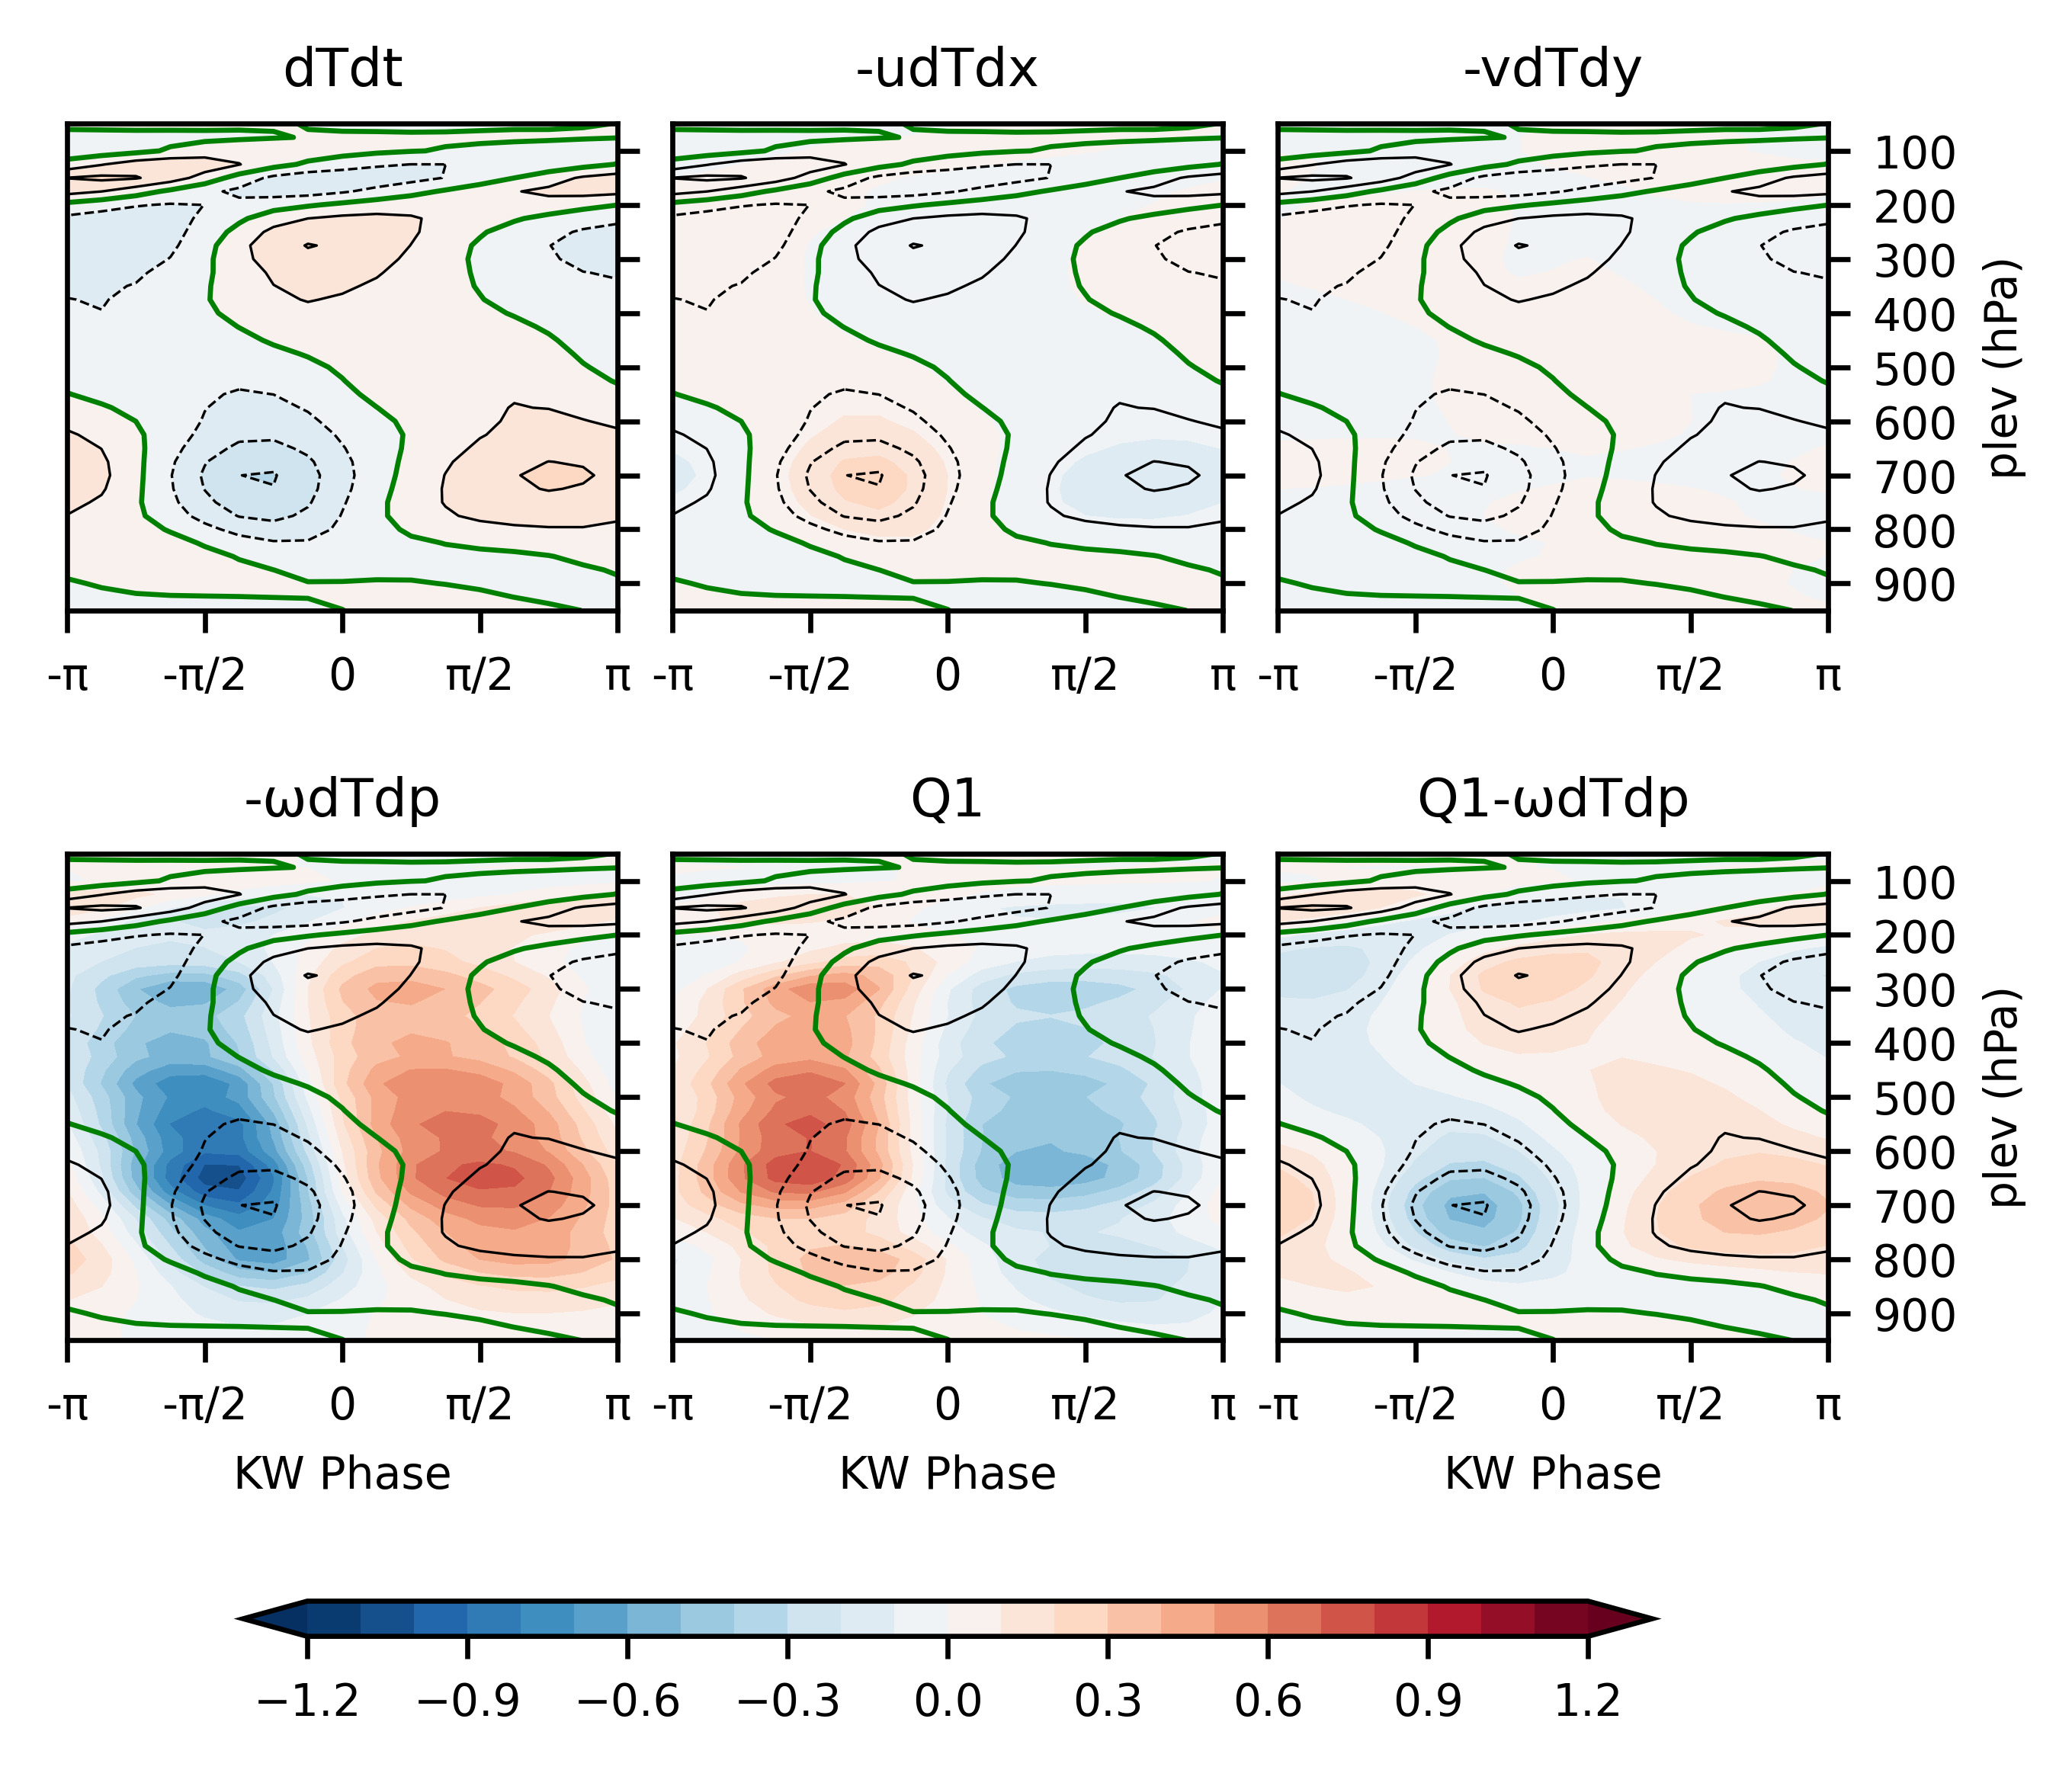

In [69]:
# Plot KW composite vertical structure of each moisture tendency term
Q1_wdTdp_KW = Q1_KW-wdTdp_KW

vname_T_budget       = list(['dTdt','udTdx','vdTdy','wdTdp','Q1','Q1_wdTdp'])
vname_T_budget_title = list(['dTdt','-udTdx','-vdTdy','-\u03C9dTdp','Q1','Q1-\u03C9dTdp'])
#iplt_list = np.array([1,2,3,5,6])
iplt_list = np.array([1,2,3,4,5,6])
font = 7

fig,axes = plt.subplots(2,3,figsize=(5.5, 4),dpi=600)
plt.subplots_adjust(left=0.2,right=0.9,top=0.95,bottom=0,hspace=0.5,wspace=0.1)
plt.rcParams.update({'font.size': font})

another_colorbar = 1 # or 1 (1 is larger maximum in colorbar)

normalize_by_kwpr = 1
# contour levels
if normalize_by_kwpr == 1:
    c = kw_amp
    const_clev = 2.5
else:
    c = 1
    const_clev = 1
print('kw_amp:',kw_amp)

# Contour level!
clev = np.arange(-6,6.5,0.5)/4/const_clev
clev_p = np.arange(0.5,6.5,0.5)/4/const_clev
clev_n = np.arange(-6,0,0.5)/4/const_clev
if another_colorbar == 1:
    clev = clev*2
    clev_p = clev_p*2
    clev_n = clev_n*2
clev_0 = 0

xx, yy = np.meshgrid(phase, plev_KW)

for iplt in range(0,6): #previously it was 5
    plt.subplot(2,3,iplt_list[iplt])
    ax = plt.gca()
    VAR_cf = globals() [vname_T_budget[iplt]+'_KW']
    VAR_cn = globals() [vname_T_budget[0]+'_KW'] # q budget total
    VAR_cf = VAR_cf/c*s2d
    VAR_cn = VAR_cn/c*s2d
    if iplt != 0 and iplt !=4 and iplt!=5:
        print(vname_T_budget[iplt], 'change sign')
        VAR_cf = -VAR_cf
    cf   = plt.contourf(xx, yy, VAR_cf.T, levels=clev, cmap='RdBu_r', extend='both' )
    cn_p = plt.contour(xx, yy, VAR_cn.T, levels=clev_p, colors='k', linewidths=0.4)
    cn_0 = plt.contour(xx, yy, VAR_cn.T, levels=clev_0, colors='g', linewidths=0.8)
    cn_n = plt.contour(xx, yy, VAR_cn.T, levels=clev_n, colors='k', linestyles='dashed',linewidths=0.4)
    plt.ylim([np.min(plev_KW), np.max(plev_KW)])
    plt.title(vname_T_budget_title[iplt])
    plt.yticks(np.arange(100,1000,100))
    plt.gca().invert_yaxis()
    plt.xticks(np.arange(-pi,pi+pi/2,pi/2),('-'+PI,'-'+PI+'/2','0',PI+'/2',PI),fontsize=font)
    ax.yaxis.set_label_position("right")
    plt.tick_params(bottom=True,top=False,left=False,right=True)
    if iplt == 2 or iplt == 5: #previously, iplt = 4
        plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=True)
        ax.set_ylabel('plev (hPa)',fontsize=font)
    else:
        plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=False)       

    if iplt > 2:
        plt.xlabel('KW Phase',fontsize=font)

cb = plt.colorbar(cf,ax=axes,orientation = 'horizontal', shrink=.8, aspect=40,pad=0.15) 

#for ax in axes[1:,0]:
#    ax.remove()

if another_colorbar == 1:
    plt.savefig(figdir+'dTdt_wdTdp_Q1_wdTdp-Q1_KW_another_colorbar.png',dpi=600)
else:
    plt.savefig(figdir+'dTdt_wdTdp_Q1_wdTdp-Q1_KW.png',dpi=600)
plt.show()
plt.close()

[ 1.00000000e+00 -7.58351454e-01 -1.07443167e-04  2.96829963e+00
 -1.20984073e+00 -1.54321000e-13]


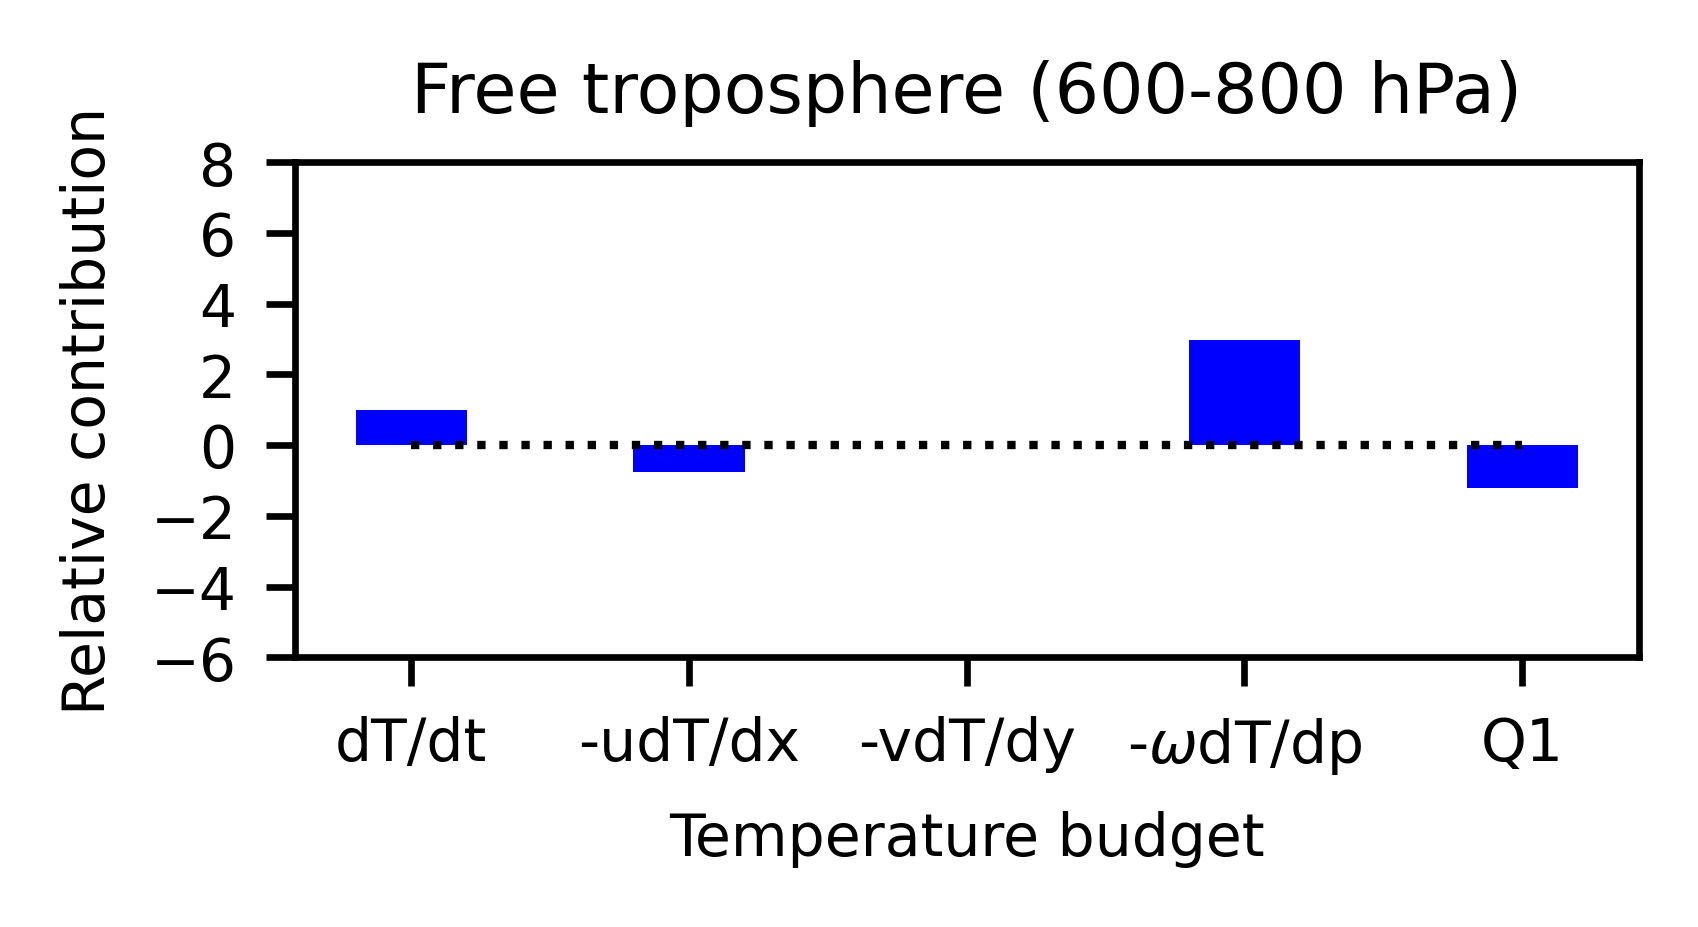

In [70]:
###################
# Calculate contribution of each term to maintenance and propagation
###################################
nlev_KW = np.size(plev_KW)
if inudge == 0:
    plev_min = 600
    plev_max = 800
elif inudge == 4:
    plev_min = 400
    plev_max = 600

# contributino to dTdt
for i in range(0,1):
    
    if i==0: # THe vertical level where temperature peaks
        ilev_min = np.argwhere(plev_KW==plev_min).squeeze()
        ilev_max = np.argwhere(plev_KW==plev_max).squeeze()
    
    r_dTdt  = np.sum(dTdt_KW[:,ilev_min:ilev_max+1]*dTdt_KW[:,ilev_min:ilev_max+1])/np.sum(dTdt_KW[:,ilev_min:ilev_max+1]**2)
    r_udTdx = np.sum(dTdt_KW[:,ilev_min:ilev_max+1]*(-udTdx_KW[:,ilev_min:ilev_max+1]))/np.sum(dTdt_KW[:,ilev_min:ilev_max+1]**2)
    r_vdTdy = np.sum(dTdt_KW[:,ilev_min:ilev_max+1]*(-vdTdy_KW[:,ilev_min:ilev_max+1]))/np.sum(dTdt_KW[:,ilev_min:ilev_max+1]**2)
    r_wdTdp = np.sum(dTdt_KW[:,ilev_min:ilev_max+1]*(-wdTdp_KW[:,ilev_min:ilev_max+1]))/np.sum(dTdt_KW[:,ilev_min:ilev_max+1]**2)
    r_Q1    = np.sum(dTdt_KW[:,ilev_min:ilev_max+1]*(Q1_KW[:,ilev_min:ilev_max+1]))/np.sum(dTdt_KW[:,ilev_min:ilev_max+1]**2)
    r_res   = 1-r_udTdx-r_vdTdy-r_wdTdp-r_Q1
    r = np.array([r_dTdt, r_udTdx, r_vdTdy, r_wdTdp, r_Q1, r_res])
    print(r)
    
    # Plot bar plot of relative contribution of each buget term
    fig,axes = plt.subplots(1,1,figsize=(3.2, 1.5),dpi=600)
    ax = plt.gca()
    plt.subplots_adjust(left=0.2,right=0.9,top=0.8,bottom=0.25)
    plt.rcParams.update({'font.size': font})
    x = np.arange(0,5)
    zero = np.zeros([np.size(x)])
    plt.bar(x, r[:-1], color='blue',width=0.4)
    plt.plot(x, zero, 'k:', linewidth=1)
    plt.xticks(x,('dT/dt','-udT/dx','-vdT/dy','-$\omega$dT/dp','Q1'))
    plt.xlabel('Temperature budget')
    plt.ylabel('Relative contribution')
    plt.title('Free troposphere ('+str(plev_min)+'-'+str(plev_max)+' hPa)')
    if i == 0:
        plt.yticks(np.arange(-6,10,2))
        plt.ylim([-6,8])
    plt.savefig(figdir+'dTdt_contribution_'+str(plev_min)+'-'+str(plev_max)+'.png',dpi=600)
    plt.show()

Finish term 4
Finish term 5


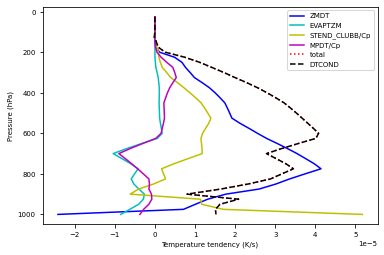

In [78]:
#######################################
# B. KW composite dTCOND decomposition
######################################
# Load each tendency term
DTDt_saved = 1
latmax = 10

if DTDt_saved == 0:
    
    # (0) Get nfile_skip
    nfile_skip = KW.find_nfile_skip(CASENAME, CASENAME_SHORT, iyr_min, iyr_max, from_cheyenne=0)

    # (1) Load each temperature tendency term & Calculate anomaly
    # Note that we have verified that ZMDT + EVAPTZM + ZMMTT (very small) + STEND_CLUBB/Cp + MPDT/Cp
    vname = list(['DTCOND'])
    DTCOND_proj, DTCOND_m, time, plev, lon = KW.load_3D_data_as_1variable(CASENAME, CASENAME_SHORT, vname, iyr_min, iyr_max, latmax, nfile_skip, from_cheyenne=0)
    DTCOND_ano = MJO.remove_10d_from_3hr_data(DTCOND_proj) #(time, plev, lon)
    # Save Term 1 data
    np.savez(output_dir+'dTdt_each_term.npz', \
             DTCOND_proj=DTCOND_proj, DTCOND_m=DTCOND_m, DTCOND_ano=DTCOND_ano,\
             time=time, plev=plev, lon=lon)
    print('Finish term 1')

    
    vname = list(['ZMDT'])
    ZMDT_proj, ZMDT_m, time, plev, lon = KW.load_3D_data_as_1variable(CASENAME, CASENAME_SHORT, vname, iyr_min, iyr_max, latmax, nfile_skip, from_cheyenne=0)
    ZMDT_ano = MJO.remove_10d_from_3hr_data(ZMDT_proj) #(time, plev, lon)
    # Save Term 2 data
    np.savez(output_dir+'dTdt_each_term.npz', \
             DTCOND_proj=DTCOND_proj, DTCOND_m=DTCOND_m, DTCOND_ano=DTCOND_ano,\
             ZMDT_proj=ZMDT_proj, ZMDT_m=ZMDT_m, ZMDT_ano=ZMDT_ano,\
             time=time, plev=plev, lon=lon)
    print('Finish term 2')

    vname = list(['EVAPTZM'])
    EVAPTZM_proj, EVAPTZM_m, time, plev, lon = KW.load_3D_data_as_1variable(CASENAME, CASENAME_SHORT, vname, iyr_min, iyr_max, latmax, nfile_skip, from_cheyenne=0)
    EVAPTZM_ano = MJO.remove_10d_from_3hr_data(EVAPTZM_proj) #(time, plev, lon)
    # Save Term 3 data
    np.savez(output_dir+'dTdt_each_term.npz', \
             DTCOND_proj=DTCOND_proj, DTCOND_m=DTCOND_m, DTCOND_ano=DTCOND_ano,\
             ZMDT_proj=ZMDT_proj, ZMDT_m=ZMDT_m, ZMDT_ano=ZMDT_ano,\
             EVAPTZM_proj=EVAPTZM_proj, EVAPTZM_m=EVAPTZM_m, EVAPTZM_ano=EVAPTZM_ano,\
             time=time, plev=plev, lon=lon)
    print('Finish term 3')

    
    vname = list(['STEND_CLUBB']) # this is normalized by Cp so that it is the same unit as other terms (K/s)
    STEND_CLUBB_proj, STEND_CLUBB_m, time, plev, lon = KW.load_3D_data_as_1variable(CASENAME, CASENAME_SHORT, vname, iyr_min, iyr_max, latmax, nfile_skip, from_cheyenne=0)
    STEND_CLUBB_ano = MJO.remove_10d_from_3hr_data(STEND_CLUBB_proj) #(time, plev, lon)
    STEND_CLUBB_proj = STEND_CLUBB_proj/Cp
    STEND_CLUBB_m    = STEND_CLUBB_m/Cp
    STEND_CLUBB_ano  = STEND_CLUBB_ano/Cp
    # Save Term 4 data
    np.savez(output_dir+'dTdt_each_term.npz', \
             DTCOND_proj=DTCOND_proj, DTCOND_m=DTCOND_m, DTCOND_ano=DTCOND_ano,\
             ZMDT_proj=ZMDT_proj, ZMDT_m=ZMDT_m, ZMDT_ano=ZMDT_ano,\
             EVAPTZM_proj=EVAPTZM_proj, EVAPTZM_m=EVAPTZM_m, EVAPTZM_ano=EVAPTZM_ano,\
             STEND_CLUBB_proj=STEND_CLUBB_proj, STEND_CLUBB_m=STEND_CLUBB_m, STEND_CLUBB_ano=STEND_CLUBB_ano,\
             time=time, plev=plev, lon=lon)   
    print('Finish term 4')
    
    vname = list(['MPDT']) # this is normalized by Cp so that it is the same unit as other terms (K/s)
    MPDT_proj, MPDT_m, time, plev, lon = KW.load_3D_data_as_1variable(CASENAME, CASENAME_SHORT, vname, iyr_min, iyr_max, latmax, nfile_skip, from_cheyenne=0)
    MPDT_ano = MJO.remove_10d_from_3hr_data(MPDT_proj) #(time, plev, lon)
    MPDT_proj = MPDT_proj/Cp
    MPDT_m    = MPDT_m/Cp
    MPDT_ano  = MPDT_ano/Cp
    # Save Term 5 data
    np.savez(output_dir+'dTdt_each_term.npz', \
             DTCOND_proj=DTCOND_proj, DTCOND_m=DTCOND_m, DTCOND_ano=DTCOND_ano,\
             ZMDT_proj=ZMDT_proj, ZMDT_m=ZMDT_m, ZMDT_ano=ZMDT_ano,\
             EVAPTZM_proj=EVAPTZM_proj, EVAPTZM_m=EVAPTZM_m, EVAPTZM_ano=EVAPTZM_ano,\
             STEND_CLUBB_proj=STEND_CLUBB_proj, STEND_CLUBB_m=STEND_CLUBB_m, STEND_CLUBB_ano=STEND_CLUBB_ano,\
             MPDT_proj=MPDT_proj, MPDT_m=MPDT_m, MPDT_ano=MPDT_ano,\
             time=time, plev=plev, lon=lon) 
    print('Finish term 5')
    
    DTDT_tot_m = ZMDT_m + EVAPTZM_m + STEND_CLUBB_m + MPDT_m
    # Test: check mean state makes sense
    plt.plot(ZMDT_m, plev, 'b')
    plt.plot(EVAPTZM_m, plev, 'c')
    plt.plot(STEND_CLUBB_m, plev, 'y')
    plt.plot(MPDT_m, plev, 'm')
    plt.plot(DTDT_tot_m, plev, 'r:')
    plt.plot(DTCOND_m, plev, 'k--')
    plt.gca().invert_yaxis()
    plt.legend(['ZMDT','EVAPTZM','STEND_CLUBB/Cp','MPDT/Cp','total','DTCOND'])
    plt.xlabel('Temperature tendency (K/s)')
    plt.ylabel('Pressure (hPa)')
    plt.show()
    
else:
    data = np.load(output_dir+'dTdt_each_term.npz')
    DTCOND_ano = data['DTCOND_ano'] #(time, plev, lon), projected DTCOND, without 10-day low pass filtered variability
    ZMDT_ano   = data['ZMDT_ano'] 
    EVAPTZM_ano = data['EVAPTZM_ano']
    STEND_CLUBB_ano = data['STEND_CLUBB_ano']
    MPDT_ano   = data['MPDT_ano']
    time  = data['time']
    plev  = data['plev']
    lon   = data['lon']

In [79]:
# KW composite DTCOND decomposition term
T_tendency_kw_saved = 1

# Load KW phase
data          = np.load(output_dir+'precip_kw.npz')
time_pr       = data['time_pr']
phase_correct = data['phase_correct']
pr_kw         = data['pr_kw']
kw_amp  = (np.max(pr_kw)-np.min(pr_kw))/2  
print('KW amp:',kw_amp)
print('Shape of time_pr:',np.shape(time_pr))


if T_tendency_kw_saved == 0:

    # Make sure each tendency term have the same size as kw-filtered precip
    DTCOND_trim      = DTCOND_ano[time_pr[0]:time_pr[-1]+1, :, :]
    del DTCOND_ano
    ZMDT_trim        = ZMDT_ano[time_pr[0]:time_pr[-1]+1, :, :]
    del ZMDT_ano
    EVAPTZM_trim     = EVAPTZM_ano[time_pr[0]:time_pr[-1]+1, :, :]
    del EVAPTZM_ano
    STEND_CLUBB_trim = STEND_CLUBB_ano[time_pr[0]:time_pr[-1]+1, :, :]
    del STEND_CLUBB_ano
    MPDT_trim        = MPDT_ano[time_pr[0]:time_pr[-1]+1, :, :]
    del MPDT_ano
    
    DTCOND_KW,      phase = KW.composite_by_kw_phase(DTCOND_trim[:,:,:],      phase_correct[:,:], time_pr[:]) #(phase, plev)
    del DTCOND_trim
    ZMDT_KW,        phase = KW.composite_by_kw_phase(ZMDT_trim[:,:,:],        phase_correct[:,:], time_pr[:])
    del ZMDT_trim
    EVAPTZM_KW,     phase = KW.composite_by_kw_phase(EVAPTZM_trim[:,:,:],     phase_correct[:,:], time_pr[:])
    del EVAPTZM_trim
    STEND_CLUBB_KW, phase = KW.composite_by_kw_phase(STEND_CLUBB_trim[:,:,:], phase_correct[:,:], time_pr[:])
    del STEND_CLUBB_trim
    MPDT_KW,        phase = KW.composite_by_kw_phase(MPDT_trim[:,:,:],        phase_correct[:,:], time_pr[:])
    del MPDT_trim
    
    np.savez(output_dir+'dTdt_each_term_kwcomposite.npz', DTCOND_KW=DTCOND_KW, ZMDT_KW=ZMDT_KW, \
             EVAPTZM_KW=EVAPTZM_KW, STEND_CLUBB_KW=STEND_CLUBB_KW, MPDT_KW=MPDT_KW,\
             plev=plev, phase=phase)
    
else:
    
    data           = np.load(output_dir+'dTdt_each_term_kwcomposite.npz')
    DTCOND_KW      = data['DTCOND_KW'][:,:]*s2d
    ZMDT_KW        = data['ZMDT_KW'][:,:]*s2d
    EVAPTZM_KW     = data['EVAPTZM_KW'][:,:]*s2d
    STEND_CLUBB_KW = data['STEND_CLUBB_KW'][:,:]*s2d
    MPDT_KW        = data['MPDT_KW'][:,:]*s2d
    
    plev  = data['plev']
    phase = data['phase']
    nphase = np.size(phase)

KW amp: 0.6718159816739131
Shape of time_pr: (8099,)


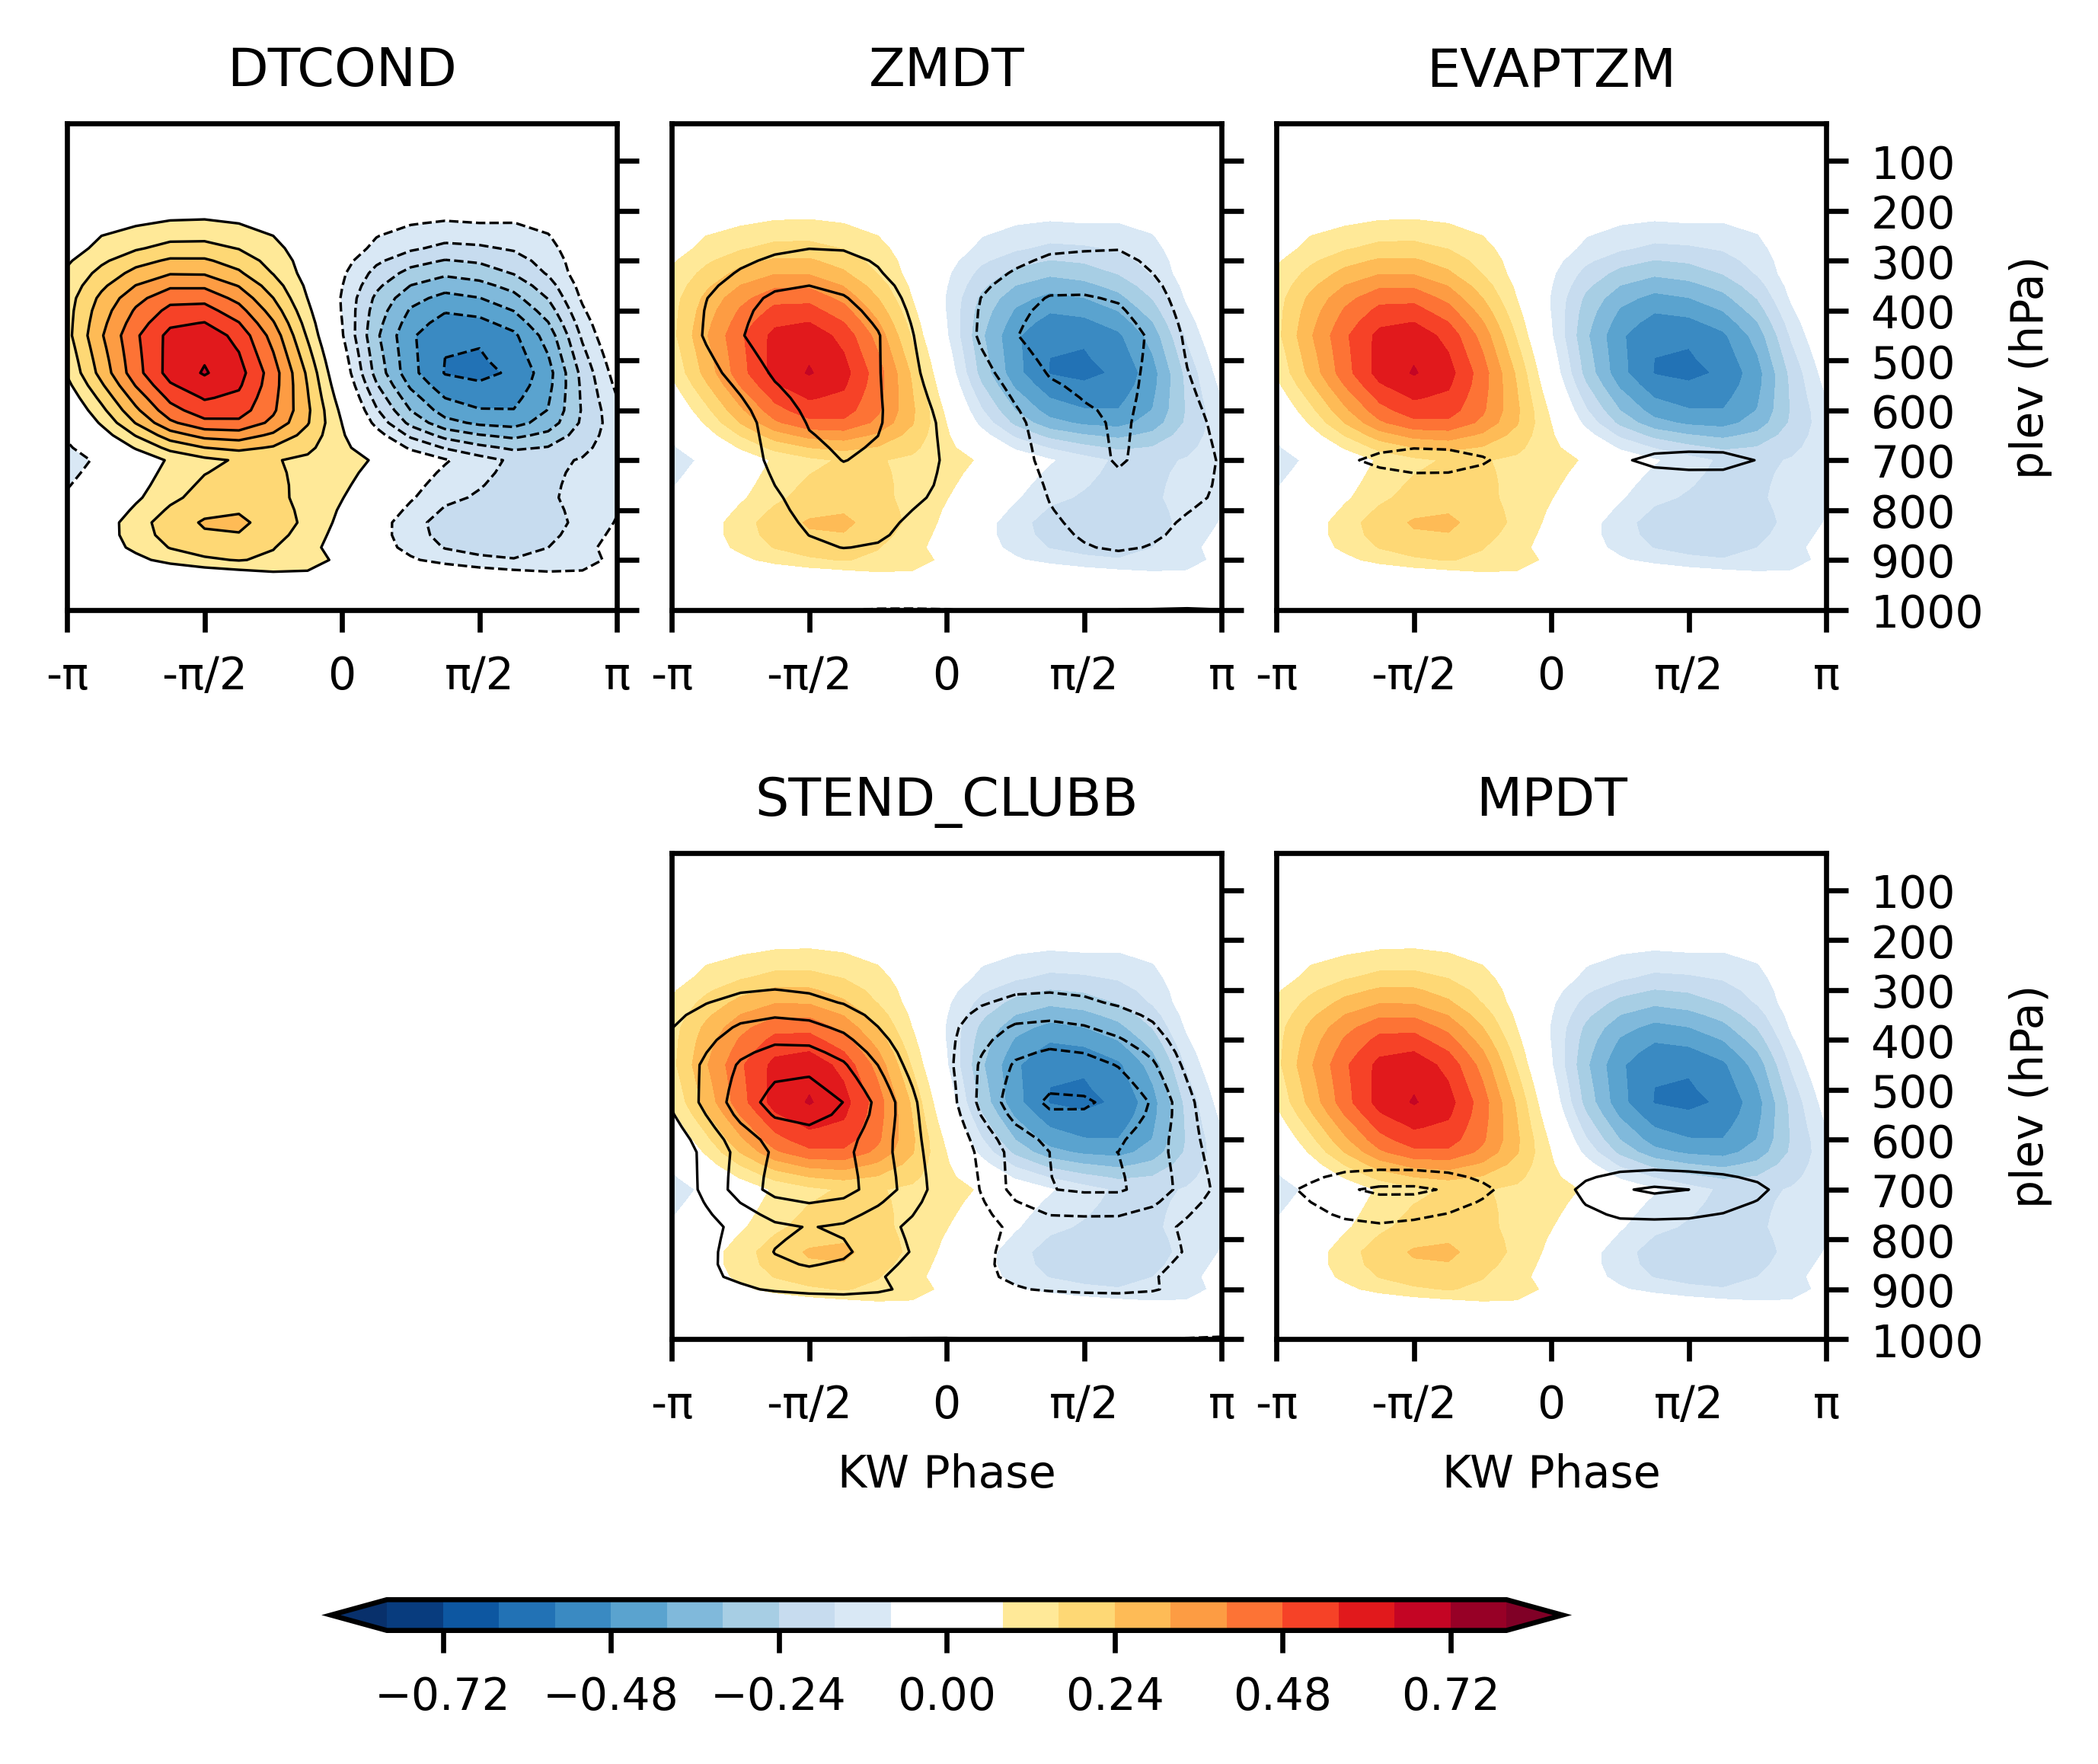

In [81]:
# Plot KW composite vertical structure of each temperature tendency term
vname_temp_tendency = list(['DTCOND','ZMDT','EVAPTZM','STEND_CLUBB','MPDT'])
font = 7

normalize_by_kwpr = 1
# contour levels
if normalize_by_kwpr == 1:
    c = kw_amp
    const_clev = 2.5
else:
    c = 1
    const_clev = 1
iplt_list = np.array([1,2,3,5,6])

fig,axes = plt.subplots(2,3,figsize=(5.5, 4),dpi=600)
plt.subplots_adjust(left=0.2,right=0.9,top=0.95,bottom=0,hspace=0.5,wspace=0.1)
plt.rcParams.update({'font.size': font})

clev_n = np.arange(-2,0,0.2)/const_clev
clev_p = np.arange(0.2,2.2,0.2)/const_clev
clev   = np.arange(-2,2.2,0.2)/const_clev
xx, yy = np.meshgrid(phase, plev)

for iplt in range(0,5):
    plt.subplot(2,3,iplt_list[iplt])
    ax = plt.gca()
    VAR_cn = globals() [vname_temp_tendency[iplt]+'_KW']
    VAR_cf = globals() [vname_temp_tendency[0]+'_KW'] # Q total
    if T_tendency_kw_saved == 0:
        VAR_cn = VAR_cn*s2d
        VAR_cf = VAR_cf*s2d
    VAR_cf = VAR_cf/c
    VAR_cn = VAR_cn/c
    cf   = plt.contourf(xx, yy, VAR_cf.T, levels=clev, cmap=get_cmap(RWB), extend='both' )
    cn_p = plt.contour(xx, yy, VAR_cn.T, levels=clev_p, colors='k', linewidths=0.4)
    #cn_0 = plt.contour(xx, yy, VAR_cn.T, levels=clev_0, colors='g', linewidths=1.2)
    cn_n = plt.contour(xx, yy, VAR_cn.T, levels=clev_n, colors='k', linestyles='dashed',linewidths=0.4)
    plt.ylim([np.min(plev), np.max(plev)])
    plt.title(vname_temp_tendency[iplt])
    plt.yticks(np.arange(100,1100,100))
    plt.gca().invert_yaxis()
    plt.xticks(np.arange(-pi,pi+pi/2,pi/2),('-'+PI,'-'+PI+'/2','0',PI+'/2',PI),fontsize=font)
    ax.yaxis.set_label_position("right")
    plt.tick_params(bottom=True,top=False,left=False,right=True)
    if iplt == 2 or iplt == 4:
        plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=True)
        ax.set_ylabel('plev (hPa)',fontsize=font)
    else:
        plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=False)       

    if iplt > 2:
        plt.xlabel('KW Phase',fontsize=font)

cb = plt.colorbar(cf,ax=axes,orientation = 'horizontal', shrink=.7, aspect=40,pad=0.15) 
for ax in axes[1:,0]:
    ax.remove()
plt.savefig(figdir+'dTCOND_decomposition_KW.png',dpi=600)
plt.show()
plt.close()